
#라이브러리import
  

In [ ]:
!pip install pandas numpy datetime geopy scikit-learn basemap shapely contextily geopandas cartopy folium plotly
!pip install xgboost lightgbm shap pyyaml scikit-learn pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

In [ ]:
!apt-get update
!apt install chromium-chromedriver
!pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,548 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,755 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages 

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Required imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# Enable inline plotting for Jupyter/Colab
%matplotlib inline

# Apply Seaborn styling
sns.set_theme()
sns.set_style('whitegrid')

# Install Nanum fonts
!apt-get update -qq
!apt-get install fonts-nanum* -qq > /dev/null 2>&1

# Reset matplotlib and clear cache
import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

# Configure additional plot settings
plt.rcParams.update({
    'figure.figsize': [10, 6],
    'figure.dpi': 100,
    'grid.linestyle': ':',
    'grid.alpha': 0.5
})

print("Font configuration completed successfully.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Font configuration completed successfully.


#데이터 전처리

##1. IDP 데이터기본 변환
yes/no 이진변환 , 컬럼 정리, 날씨 표준화, 가뭄 관련 데이터 필터링
다음과 같은 파생 변수 생성
실향 기간: 첫 도착일과 마지막 도착일 간의 차이를 일수로 계산
출발지-도착지 쌍: 지역, 구역, 워레다 코드를 조합하여 생성
예방 요인 총합: 귀환을 방해하는 요인들의 합계
필요 지원 총합: 필요로 하는 지원 유형의 수
계절 정보: 이주 발생 월을 계절로 변환

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def convert_date(date_str):
    """날짜 문자열을 datetime으로 변환"""
    if pd.isna(date_str):
        return None
    try:
        # 여러 날짜 형식 시도
        for fmt in ['%d %B %Y', '%d-%m-%Y', '%Y-%m-%d']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        return pd.to_datetime(date_str)
    except:
        return None

def add_features(df):
    """추가적인 특성 생성"""
    # 계절별 이동 패턴
    df['Is_Winter_Migration'] = (df['Displacement_Season'] == 'Winter').astype(int)

    # 이동 거리 근사값 (지역 코드 차이)
    df['Region_Change'] = (df['Region_P_CODE'] != df['Origin_Region']).astype(int)

    # 총 영향받은 가구 규모 카테고리
    df['Household_Size_Category'] = pd.qcut(df['Total_Households'],
                                          q=5,
                                          labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])

    # 예방 요인 비율
    df['Prevention_Factor_Ratio'] = df['Total_Prevention_Factors'] / 6

    # 지원 필요 비율
    df['Support_Need_Ratio'] = df['Total_Support_Needs'] / 6

    return df

def handle_missing_values(df):
    """결측치 처리 개선"""
    # 날짜 형식 변환 및 처리
    def parse_date(date_str):
        if pd.isna(date_str):
            return None
        try:
            # 날짜 형식이 'dd Month yyyy'인 경우
            return pd.to_datetime(date_str, format='%d %B %Y')
        except:
            try:
                # 날짜 형식이 'yyyy-mm-dd'인 경우
                return pd.to_datetime(date_str)
            except:
                return None

    # 날짜 컬럼 변환
    date_columns = ['Survey_Date', 'Site_Open_Date', 'First_Arrival_Date', 'Last_Arrival_Date']
    for col in date_columns:
        df[col] = df[col].apply(parse_date)

    # Survey_Date가 없는 경우 현재 날짜로 대체
    df['Survey_Date'] = df['Survey_Date'].fillna(pd.Timestamp.now())

    # First_Arrival_Date 처리
    # Site_Open_Date가 있는 경우 이를 기준으로, 없는 경우 Survey_Date에서 30일을 뺀 날짜 사용
    df['First_Arrival_Date'] = df.apply(
        lambda x: x['Site_Open_Date'] if pd.notna(x['Site_Open_Date'])
        else (x['Survey_Date'] - pd.Timedelta(days=30)) if pd.isna(x['First_Arrival_Date'])
        else x['First_Arrival_Date'],
        axis=1
    )

    # Site_Open_Date 처리
    # First_Arrival_Date가 있는 경우 이를 기준으로 7일을 뺀 날짜 사용
    df['Site_Open_Date'] = df.apply(
        lambda x: (x['First_Arrival_Date'] - pd.Timedelta(days=7)) if pd.isna(x['Site_Open_Date'])
        else x['Site_Open_Date'],
        axis=1
    )

    # Last_Arrival_Date 처리
    # First_Arrival_Date를 기준으로 적절한 기간 추가
    df['Last_Arrival_Date'] = df.apply(
        lambda x: (x['First_Arrival_Date'] + pd.Timedelta(days=30)) if pd.isna(x['Last_Arrival_Date'])
        else x['Last_Arrival_Date'],
        axis=1
    )

    # Displacement_Month 계산 (First_Arrival_Date 기준)
    df['Displacement_Month'] = df['First_Arrival_Date'].dt.month

    # 나머지 결측치 처리는 그대로 유지
    # Second Origin 관련 결측치
    for col in ['Second_Origin_Region', 'Second_Origin_Zone', 'Second_Origin_Woreda']:
        df[col] = df[col].fillna(df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown')

    # Prevention 관련 결측치
    prevention_cols = [col for col in df.columns if col.startswith('Prevention_')]
    for col in prevention_cols:
        df[col] = df[col].fillna(df[col].mode().iloc[0] if not df[col].mode().empty else 0)

    # Has_Prevention_Factors 결측치
    df['Has_Prevention_Factors'] = df['Has_Prevention_Factors'].fillna('No')

    # Support_Needs와 Need 관련 결측치
    need_cols = [col for col in df.columns if col.startswith('Need_')]
    for col in need_cols:
        df[col] = df[col].fillna(df[col].mode().iloc[0] if not df[col].mode().empty else 0)

    df['Support_Needs'] = df['Support_Needs'].fillna(df['Support_Needs'].mode().iloc[0] if not df['Support_Needs'].mode().empty else 'None')

    # 날짜 처리 결과 확인
    print("\nDate Processing Results:")
    for col in date_columns:
        print(f"\n{col}:")
        print(f"Null values: {df[col].isnull().sum()}")
        print(f"Sample values:\n{df[col].head()}")

    print("\nDisplacement_Month:")
    print(f"Null values: {df['Displacement_Month'].isnull().sum()}")
    print(f"Value counts:\n{df['Displacement_Month'].value_counts()}")

    return df

def calculate_displacement_duration(df):
    """이동 기간 계산 개선"""
    # 날짜가 모두 있는 경우에만 계산
    mask = df['Last_Arrival_Date'].notna() & df['First_Arrival_Date'].notna()

    # 이동 기간 계산
    df.loc[mask, 'Displacement_Duration'] = (
        df.loc[mask, 'Last_Arrival_Date'] - df.loc[mask, 'First_Arrival_Date']
    ).dt.days

    # 음수 값이나 결측치는 0으로 처리
    df['Displacement_Duration'] = df['Displacement_Duration'].fillna(0)
    df.loc[df['Displacement_Duration'] < 0, 'Displacement_Duration'] = 0

    return df

def normalize_features(df):
    """수치형 특성 정규화"""
    # 정규화하지 않을 컬럼들
    exclude_columns = ['Total_Individuals', 'Total_Households', 'Displacement_Duration']

    # 수치형 컬럼 선택 (제외할 컬럼 제외)
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

    # 스케일러 적용
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    return df

def encode_categorical(df):
    """범주형 변수 인코딩"""
    # 범주형 변수 선택
    categorical_columns = ['Displacement_Season', 'Preferred_Solution', 'Region_P_CODE', 'Household_Size_Category']

    # One-Hot 인코딩
    df = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns)

    return df

def validate_preprocessing(df):
    """전처리 결과 검증"""
    print("\nValidation Results:")
    print(f"Total rows: {len(df)}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print("\nNumeric Columns Statistics:")
    numeric_cols = ['Total_Individuals', 'Total_Households', 'Displacement_Duration']
    print(df[numeric_cols].describe())

    return df

def handle_second_origin(df):
    """Second Origin 데이터 처리 개선"""
    # Second Origin이 없는 경우, First Origin(Origin)과 동일하게 처리
    df['Second_Origin_Region'] = df['Second_Origin_Region'].fillna(df['Origin_Region'])
    df['Second_Origin_Zone'] = df['Second_Origin_Zone'].fillna(df['Origin_Zone'])
    df['Second_Origin_Woreda'] = df['Second_Origin_Woreda'].fillna(df['Origin_Woreda'])

    # 여전히 남아있는 결측치는 'Same as Origin'으로 처리
    df['Second_Origin_Region'] = df['Second_Origin_Region'].fillna('Same as Origin')
    df['Second_Origin_Zone'] = df['Second_Origin_Zone'].fillna('Same as Origin')
    df['Second_Origin_Woreda'] = df['Second_Origin_Woreda'].fillna('Same as Origin')

    # Second Origin이 First Origin과 같은지 여부를 나타내는 새로운 특성 추가
    df['Has_Different_Second_Origin'] = (
        (df['Second_Origin_Region'] != df['Origin_Region']) |
        (df['Second_Origin_Zone'] != df['Origin_Zone']) |
        (df['Second_Origin_Woreda'] != df['Origin_Woreda'])
    ).astype(int)

    return df

def preprocess_idp_data(file_path):
    # CSV 파일 읽기
    df = pd.read_csv(file_path)

    # 컬럼명 매핑 정의 및 변경
    column_mapping = {
        '1.1.a.1: Survey Date': 'Survey_Date',
        'Region P-CODE': 'Region_P_CODE',
        'Zone P-CODE': 'Zone_P_CODE',
        'Woreda P-CODE': 'Woreda_P_CODE',
        '1.4.a.1: Site Open Date': 'Site_Open_Date',
        '1.5.e.1: Displacement Reason': 'Displacement_Reason',
        '1.5.b.1: Region (Largest IDP group) ': 'Origin_Region',
        '1.5.b.2: Zone (Largest IDP group)': 'Origin_Zone',
        '1.5.b.3: Woreda (Largest IDP group)': 'Origin_Woreda',
        '1.5.c.1: Region (2nd largest IDP group)': 'Second_Origin_Region',
        '1.5.c.2: Zone (2nd largest IDP group)': 'Second_Origin_Zone',
        '1.5.c.3: Woreda (2nd largest IDP group)': 'Second_Origin_Woreda',
        '2.1.a.1: Total HHs': 'Total_Households',
        '2.1.b.1: Total Individuals': 'Total_Individuals',
        '2.3.c.1: Date of arrival of first IDP group': 'First_Arrival_Date',
        '2.3.c.2: Is date known for arrival of last IDP group': 'Last_Arrival_Known',
        '2.3.c.2: Date of arrival of last IDP group': 'Last_Arrival_Date',
        '2.3.b.4: Have IDPs been displaced previously?': 'Previously_Displaced',
        '2.3.j.1: IDPs leaving place of displacement?': 'Currently_Leaving',
        '2.3.e.7: Are there factors which are preventing the largest IDP group from returning?': 'Has_Prevention_Factors',
        '2.3.e.7: Accessibility': 'Prevention_Accessibility',
        '2.3.e.7: Lack of food': 'Prevention_Food',
        '2.3.e.7: House damaged/destroyed': 'Prevention_Housing',
        '2.3.e.7: Lack of safety/security': 'Prevention_Security',
        '2.3.e.7: No livelihood': 'Prevention_Livelihood',
        '2.3.e.7: Basic infrastructures damaged/flooded': 'Prevention_Infrastructure',
        '2.3.l.1: What durable solution do majority of IDPs perfer at the site?': 'Preferred_Solution',
        '2.3.l.2: What support do majority of the IDPs need to return or locally reintegrate?': 'Support_Needs',
        '2.3.l.2: Livelihood': 'Need_Livelihood',
        '2.3.l.2: Land/Resources': 'Need_Land',
        '2.3.l.2: ID/Documentation': 'Need_Documentation',
        '2.3.l.2: Access to services': 'Need_Services',
        '2.3.l.2: Safety & Security': 'Need_Security',
        '2.3.l.2: Livestock/Restocking': 'Need_Livestock'
    }

    df = df.rename(columns=column_mapping)

    # 결측치 확인 (처리 전)
    print("Missing Data Before Handling:")
    print(df.isnull().sum())

    # 결측치 처리 (가장 먼저 수행)
    df = handle_missing_values(df)

    # Second Origin 처리
    df = handle_second_origin(df)

    # 이진 데이터 변환
    binary_columns = [
        'Last_Arrival_Known', 'Previously_Displaced', 'Currently_Leaving',
        'Prevention_Accessibility', 'Prevention_Food', 'Prevention_Housing',
        'Prevention_Security', 'Prevention_Livelihood', 'Prevention_Infrastructure',
        'Need_Livelihood', 'Need_Land', 'Need_Documentation',
        'Need_Services', 'Need_Security', 'Need_Livestock'
    ]

    for col in binary_columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0}).fillna(0)

    # 이동 기간 계산
    df = calculate_displacement_duration(df)

    # 위치 정보 생성
    df['Origin_Location'] = df['Origin_Region'] + '_' + df['Origin_Zone'] + '_' + df['Origin_Woreda']
    df['Current_Location'] = df['Region_P_CODE'] + '_' + df['Zone_P_CODE'] + '_' + df['Woreda_P_CODE']

    # 예합 계산
    prevention_cols = [col for col in df.columns if col.startswith('Prevention_')]
    df['Total_Prevention_Factors'] = df[prevention_cols].sum(axis=1)

    need_cols = [col for col in df.columns if col.startswith('Need_')]
    df['Total_Support_Needs'] = df[need_cols].sum(axis=1)

    # 계절 정보 추가
    df['Displacement_Month'] = df['First_Arrival_Date'].dt.month
    df['Displacement_Season'] = df['Displacement_Month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    }).fillna('Unknown')

    # 가뭄 데이터 필터링
    drought_df = df[df['Displacement_Reason'].str.contains('Drought', case=False, na=False)]

    # 추가 특성 생성 및 정규화
    drought_df = add_features(drought_df)
    drought_df = normalize_features(drought_df)
    drought_df = encode_categorical(drought_df)

    # 최종 검측치 확인
    print("\nMissing Values After Processing:")
    print(drought_df.isnull().sum())

    # 검증
    validate_preprocessing(drought_df)

    return drought_df

def save_processed_data(processed_df, output_path):
    """처리된 데이터를 CSV 파일로 저장하고 요약 통계 출력"""
    processed_df.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")

    print("\nDataset Summary:")
    print(f"Total number of drought-related displacement events: {len(processed_df)}")
    print(f"Number of unique origin locations: {processed_df['Origin_Location'].nunique()}")
    print(f"Number of unique current locations: {processed_df['Current_Location'].nunique()}")
    print(f"Average displacement duration: {processed_df['Displacement_Duration'].mean():.2f} days")
    print(f"Total number of affected individuals: {processed_df['Total_Individuals'].sum():,}")

# 파일 경로 설정
input_path = '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/IDP DATA.csv'
output_path = '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/processed_idp_data.csv'

# 전처리 실행
try:
    processed_data = preprocess_idp_data(input_path)
    save_processed_data(processed_data, output_path)
except Exception as e:
    print(f"Error occurred during preprocessing: {str(e)}")

Missing Data Before Handling:
Survey_Date                    0
Region_P_CODE                  0
Zone_P_CODE                    0
Woreda_P_CODE                  0
Site_Open_Date                 0
Displacement_Reason            0
Origin_Region                  0
Origin_Zone                    0
Origin_Woreda                  0
Second_Origin_Region         286
Second_Origin_Zone           287
Second_Origin_Woreda         288
Total_Households               0
Total_Individuals              0
First_Arrival_Date             0
Last_Arrival_Known             0
Last_Arrival_Date             82
Previously_Displaced           0
Currently_Leaving              0
Has_Prevention_Factors        45
Prevention_Accessibility      45
Prevention_Food               45
Prevention_Housing            45
Prevention_Security           45
Prevention_Livelihood         45
Prevention_Infrastructure     45
Preferred_Solution             0
Support_Needs                133
Need_Livelihood              133
Need_Land    

<ipython-input-3-f3c665984eca>:53: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)
<ipython-input-3-f3c665984eca>:53: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)



Date Processing Results:

Survey_Date:
Null values: 0
Sample values:
0   2017-11-14
1   2017-11-13
2   2017-11-11
3   2017-11-07
4   2017-11-06
Name: Survey_Date, dtype: datetime64[ns]

Site_Open_Date:
Null values: 0
Sample values:
0   2017-09-22
1   2015-09-30
2   2016-10-06
3   2015-01-20
4   2014-03-21
Name: Site_Open_Date, dtype: datetime64[ns]

First_Arrival_Date:
Null values: 0
Sample values:
0   2017-09-22
1   2015-09-30
2   2016-10-06
3   2015-01-20
4   2014-03-21
Name: First_Arrival_Date, dtype: datetime64[ns]

Last_Arrival_Date:
Null values: 0
Sample values:
0   2017-09-22
1   2017-07-25
2   2016-12-06
3   2015-05-02
4   2017-06-02
Name: Last_Arrival_Date, dtype: datetime64[ns]

Displacement_Month:
Null values: 0
Value counts:
Displacement_Month
9     204
1      97
10     86
5      82
8      67
4      61
3      58
2      54
7      52
6      36
12     35
11     29
Name: count, dtype: int64

Missing Values After Processing:
Survey_Date                           0
Zone_P_CODE  

<ipython-input-3-f3c665984eca>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Is_Winter_Migration'] = (df['Displacement_Season'] == 'Winter').astype(int)
<ipython-input-3-f3c665984eca>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Region_Change'] = (df['Region_P_CODE'] != df['Origin_Region']).astype(int)
<ipython-input-3-f3c665984eca>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

##2.가뭄 데이터 + 경제수준 + 교육수준 데이터 결합
-2017년 데이터로 고정함
-GDP는 지역별로 가중치를 둬서 조정하기

In [ ]:
def check_data_structure(idp_df):
    """IDP 데이터의 구조를 확인하는 함수"""
    print("\nIDP 데이터 컬럼명:")
    print(idp_df.columns.tolist())

    print("\n지역 관련 컬럼 확인:")
    region_cols = [col for col in idp_df.columns if 'region' in col.lower() or 'code' in col.lower()]
    print(region_cols)

    return region_cols

def main():
    # 파일 경로 설정
    INPUT_PATH = "/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/processed_idp_data.csv"
    ECONOMY_PATH = "/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/economy-and-growth_som.csv"
    EDUCATION_PATH = "/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/education_som.csv"

    # 데이터 로드
    idp_df, _, _ = load_datasets(INPUT_PATH, ECONOMY_PATH, EDUCATION_PATH)

    # 데이터 구조 확인
    region_cols = check_data_structure(idp_df)

    return idp_df, region_cols

if __name__ == "__main__":
    idp_df, region_cols = main()

데이터 로드 완료!
IDP 데이터 크기: (265, 59)
경제 데이터 크기: (5340, 6)
교육 데이터 크기: (71, 6)

IDP 데이터 컬럼명:
['Survey_Date', 'Zone_P_CODE', 'Woreda_P_CODE', 'Site_Open_Date', 'Displacement_Reason', 'Origin_Region', 'Origin_Zone', 'Origin_Woreda', 'Second_Origin_Region', 'Second_Origin_Zone', 'Second_Origin_Woreda', 'Total_Households', 'Total_Individuals', 'First_Arrival_Date', 'Last_Arrival_Known', 'Last_Arrival_Date', 'Previously_Displaced', 'Currently_Leaving', 'Has_Prevention_Factors', 'Prevention_Accessibility', 'Prevention_Food', 'Prevention_Housing', 'Prevention_Security', 'Prevention_Livelihood', 'Prevention_Infrastructure', 'Support_Needs', 'Need_Livelihood', 'Need_Land', 'Need_Documentation', 'Need_Services', 'Need_Security', 'Need_Livestock', 'Displacement_Month', 'Has_Different_Second_Origin', 'Displacement_Duration', 'Origin_Location', 'Current_Location', 'Total_Prevention_Factors', 'Total_Support_Needs', 'Is_Winter_Migration', 'Region_Change', 'Prevention_Factor_Ratio', 'Support_Need_Ratio', 'D

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

def load_datasets(idp_data, economy_data, education_data):
    """데이터셋 로드 및 유효성 검증"""
    try:
        idp_df = pd.read_csv(idp_data)
        economy_df = pd.read_csv(economy_data)
        education_df = pd.read_csv(education_data)

        print("데이터 로드 완료!")
        print(f"IDP 데이터 크기: {idp_df.shape}")
        print(f"경제 데이터 크기: {economy_df.shape}")
        print(f"교육 데이터 크기: {education_df.shape}")

        return idp_df, economy_df, education_df
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        raise

def process_economic_indicators(economy_df):
    """경제 지표 데이터 전처리"""
    print("\n경제 지표 처리 중...")

    economy_indicators = [
        'GDP (current US$)',
        'GDP per capita (current US$)',
        'Trade (% of GDP)',
        'Foreign direct investment, net inflows (% of GDP)',
        'Personal remittances, received (% of GDP)'
    ]

    economy_selected = economy_df[economy_df['Indicator Name'].isin(economy_indicators)].copy()
    economy_selected['Value'] = pd.to_numeric(economy_selected['Value'], errors='coerce')

    economy_selected = economy_selected.sort_values('Year', ascending=False)
    economy_selected = economy_selected.drop_duplicates(subset=['Year', 'Indicator Name'], keep='first')

    economy_wide = economy_selected.pivot(
        index='Year',
        columns='Indicator Name',
        values='Value'
    ).reset_index()

    print(f"처리된 경제 지표 형태: {economy_wide.shape}")
    return economy_wide

def process_education_indicators(education_df):
    """교육 지표 데이터 전처리"""
    print("\n교육 지표 처리 중...")

    education_indicators = [
        'School enrollment, primary (% gross)',
        'School enrollment, secondary (% gross)',
        'Literacy rate, youth total (% of people ages 15-24)',
        'Literacy rate, adult total (% of people ages 15 and above)'
    ]

    education_selected = education_df[education_df['Indicator Name'].isin(education_indicators)].copy()
    education_selected['Value'] = pd.to_numeric(education_selected['Value'], errors='coerce')

    education_selected = education_selected.sort_values('Year', ascending=False)
    education_selected = education_selected.drop_duplicates(subset=['Year', 'Indicator Name'], keep='first')

    education_wide = education_selected.pivot(
        index='Year',
        columns='Indicator Name',
        values='Value'
    ).reset_index()

    education_wide = education_wide.fillna(0)
    print(f"처리된 교육 지표 형태: {education_wide.shape}")
    return education_wide

def prepare_idp_data(idp_df):
    """IDP 데이터 전처리"""
    print("\nIDP 데이터 처리 중...")

    idp_df = idp_df.copy()

    # 날짜 처리
    idp_df['year'] = pd.to_datetime(idp_df['Survey_Date']).dt.year
    idp_df['month'] = pd.to_datetime(idp_df['Survey_Date']).dt.month

    # 수치형 변환
    numeric_columns = ['Total_Households', 'Total_Individuals', 'Displacement_Duration']
    for col in numeric_columns:
        idp_df[col] = pd.to_numeric(idp_df[col], errors='coerce')

    # 파생 변수 생성
    idp_df['household_size'] = idp_df['Total_Individuals'] / idp_df['Total_Households']

    return idp_df

def apply_regional_weights(merged_df):
    """지역별 가중치 적용"""
    print("\n지역별 가중치 적용 중...")

    region_characteristics = {
        'Region_P_CODE_ET02': {  # Afar
            'urban_rural_ratio': 0.85,
            'infrastructure': 0.75,
            'conflict_impact': 0.90,
            'population_density': 0.80
        },
        'Region_P_CODE_ET03': {  # Amhara
            'urban_rural_ratio': 0.95,
            'infrastructure': 0.85,
            'conflict_impact': 0.85,
            'population_density': 0.90
        },
        'Region_P_CODE_ET04': {  # Oromia
            'urban_rural_ratio': 1.0,
            'infrastructure': 0.90,
            'conflict_impact': 0.80,
            'population_density': 1.0
        },
        'Region_P_CODE_ET05': {  # Somali
            'urban_rural_ratio': 0.80,
            'infrastructure': 0.70,
            'conflict_impact': 0.95,
            'population_density': 0.75
        }
    }

    def calculate_regional_weight(row):
        for region_code, chars in region_characteristics.items():
            if row[region_code] == 1:
                weight = (chars['urban_rural_ratio'] * 0.3 +
                         chars['infrastructure'] * 0.3 +
                         chars['conflict_impact'] * 0.2 +
                         chars['population_density'] * 0.2)
                return weight
        return 1.0

    merged_df['regional_weight'] = merged_df.apply(calculate_regional_weight, axis=1)

    # 조정할 지표 정의
    economic_indicators = [
        'gdp_per_capita_usd',
        'trade_pct_gdp',
        'fdi_pct_gdp',
        'remittances_pct_gdp'
    ]

    education_indicators = [
        'primary_enrollment',
        'secondary_enrollment',
        'youth_literacy_rate',
        'adult_literacy_rate'
    ]

    # 지표 조정
    for indicator in economic_indicators:
        if indicator in merged_df.columns:
            base_value = merged_df[indicator].iloc[0]
            merged_df[indicator] = merged_df.apply(
                lambda row: base_value * row['regional_weight'],
                axis=1
            )

    for indicator in education_indicators:
        if indicator in merged_df.columns:
            base_value = merged_df[indicator].iloc[0]
            merged_df[indicator] = merged_df.apply(
                lambda row: min(100, base_value * row['regional_weight']),
                axis=1
            )

    # 결과 요약
    print("\n지역별 조정된 지표 요약:")
    for region_code in region_characteristics.keys():
        if len(merged_df[merged_df[region_code] == 1]) > 0:
            sample = merged_df[merged_df[region_code] == 1].iloc[0]
            print(f"\n지역: {region_code}")
            print(f"적용된 가중치: {sample['regional_weight']:.3f}")
            print(f"GDP per capita: {sample['gdp_per_capita_usd']:.2f}")
            if 'youth_literacy_rate' in sample:
                print(f"청년 문해율: {sample['youth_literacy_rate']:.2f}%")

    return merged_df

def merge_datasets(idp_df, economy_wide, education_wide):
    """데이터셋 병합"""
    print("\n데이터 병합 중...")

    # 연도 형식 통일
    idp_df['year'] = idp_df['year'].astype(int)
    economy_wide['Year'] = economy_wide['Year'].astype(int)
    education_wide['Year'] = education_wide['Year'].astype(int)

    # 순차적 병합
    merged_df = idp_df.merge(
        economy_wide,
        left_on='year',
        right_on='Year',
        how='left'
    )

    merged_df = merged_df.merge(
        education_wide,
        left_on='year',
        right_on='Year',
        how='left'
    )

    # 컬럼 정리
    merged_df = merged_df.drop(['Year_x', 'Year_y', 'Year'], axis=1, errors='ignore')

    # 컬럼명 변경
    column_mapping = {
        'GDP (current US$)': 'gdp_usd',
        'GDP per capita (current US$)': 'gdp_per_capita_usd',
        'Trade (% of GDP)': 'trade_pct_gdp',
        'Foreign direct investment, net inflows (% of GDP)': 'fdi_pct_gdp',
        'Personal remittances, received (% of GDP)': 'remittances_pct_gdp',
        'School enrollment, primary (% gross)': 'primary_enrollment',
        'School enrollment, secondary (% gross)': 'secondary_enrollment',
        'Literacy rate, youth total (% of people ages 15-24)': 'youth_literacy_rate',
        'Literacy rate, adult total (% of people ages 15 and above)': 'adult_literacy_rate'
    }

    merged_df = merged_df.rename(columns=column_mapping)

    # 결측치 처리
    numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
    merged_df[numeric_columns] = merged_df[numeric_columns].fillna(method='ffill').fillna(method='bfill')

    return merged_df

def validate_merged_data(merged_df):
    """병합된 데이터 검증"""
    print("\n데이터 검증 중...")

    numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
    completeness = (1 - merged_df[numeric_cols].isnull().sum() / len(merged_df)) * 100
    stats = merged_df[numeric_cols].describe()

    duplicates = merged_df.duplicated().sum()
    print(f"중복된 행 수: {duplicates}")

    return completeness, stats

def main():
    """메인 실행 함수"""
    # 파일 경로 설정
    INPUT_PATH = "/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/processed_idp_data.csv"
    ECONOMY_PATH = "/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/economy-and-growth_som.csv"
    EDUCATION_PATH = "/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/education_som.csv"
    OUTPUT_PATH = "/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/merged_idp_data.csv"

    # 데이터 처리 파이프라인 실행
    idp_df, economy_df, education_df = load_datasets(INPUT_PATH, ECONOMY_PATH, EDUCATION_PATH)
    economy_wide = process_economic_indicators(economy_df)
    education_wide = process_education_indicators(education_df)
    idp_df = prepare_idp_data(idp_df)

    merged_df = merge_datasets(idp_df, economy_wide, education_wide)
    merged_df = apply_regional_weights(merged_df)

    completeness, stats = validate_merged_data(merged_df)

    # 결과 저장
    merged_df.to_csv(OUTPUT_PATH, index=False)
    print(f"\n가중치가 적용된 데이터가 저장되었습니다: {OUTPUT_PATH}")
    print(f"최종 데이터 크기: {merged_df.shape}")
    print(f"\n데이터 완전성:\n{completeness}")
    print(f"\n기술 통계량:\n{stats}")

    return merged_df

# 코드 실행
if __name__ == "__main__":
    merged_data = main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 로드 완료!
IDP 데이터 크기: (265, 59)
경제 데이터 크기: (5340, 6)
교육 데이터 크기: (71, 6)

경제 지표 처리 중...
처리된 경제 지표 형태: (1, 6)

교육 지표 처리 중...
처리된 교육 지표 형태: (1, 5)

IDP 데이터 처리 중...

데이터 병합 중...

지역별 가중치 적용 중...

지역별 조정된 지표 요약:

지역: Region_P_CODE_ET02
적용된 가중치: 0.820
GDP per capita: 527.88
청년 문해율: 58.22%

지역: Region_P_CODE_ET03
적용된 가중치: 0.890
GDP per capita: 572.94
청년 문해율: 63.19%

지역: Region_P_CODE_ET04
적용된 가중치: 0.930
GDP per capita: 598.69
청년 문해율: 66.03%

지역: Region_P_CODE_ET05
적용된 가중치: 0.790
GDP per capita: 508.56
청년 문해율: 56.09%

데이터 검증 중...
중복된 행 수: 0

가중치가 적용된 데이터가 저장되었습니다: /content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/merged_idp_data.csv
최종 데이터 크기: (265, 72)

데이터 완전성:
Total_Households               100.0
Total_Individuals              100.0
Last_Arrival_Known             100.0
Previously_Displaced           100.0
Currently_Leaving              100.0
Prevention_Accessibility

##3. IDP 데이터고도화

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

def enhance_demographic_features(df):
    """인구통계학적 특성 강화"""
    # 가구당 평균 구성원 수
    df['avg_household_size'] = df['Total_Individuals'] / df['Total_Households']

    # 이주 기간 (일)
    df['displacement_days'] = pd.to_datetime(df['Survey_Date']) - pd.to_datetime(df['First_Arrival_Date'])
    df['displacement_days'] = df['displacement_days'].dt.days

    # 계절성 이주 패턴
    df['is_seasonal_migration'] = (df['Displacement_Season_Fall'] |
                                 df['Displacement_Season_Spring'] |
                                 df['Displacement_Season_Summer'] |
                                 df['Displacement_Season_Winter']).astype(int)

    # 이주 거리 근사치 (지역 변경 여부)
    df['migration_distance_category'] = df['Region_Change'].map({True: 'Long', False: 'Short'})

    return df

def enhance_economic_features(df):
    """경제 지표 관련 특성 강화"""
    # 기존 코드 유지
    df['gdp_usd'] = df['gdp_usd'].fillna(df['gdp_usd'].mean())
    df['gdp_per_capita_usd'] = df['gdp_per_capita_usd'].fillna(df['gdp_per_capita_usd'].mean())
    df['trade_pct_gdp'] = df['trade_pct_gdp'].fillna(df['trade_pct_gdp'].mean())

    df['Total_Households'] = df['Total_Households'].replace(0, 1)
    df['Total_Individuals'] = df['Total_Individuals'].replace(0, 1)

    # 새로운 경제 지표
    df['gdp_per_household'] = df['gdp_usd'] / df['Total_Households']
    df['gdp_per_individual'] = df['gdp_usd'] / df['Total_Individuals']

    # 무역 의존도와 실향민 규모
    df['trade_impact'] = df['trade_pct_gdp'] * df['Total_Individuals'] / 1000

    # 경제적 취약성 지수
    df['economic_vulnerability'] = (
        (df['Total_Individuals'] / df['gdp_per_capita_usd']) *
        (df['trade_pct_gdp'] / 100)
    )

    # 송금 영향도 (있는 경우)
    if 'remittances_pct_gdp' in df.columns:
        df['remittance_impact'] = df['remittances_pct_gdp'] * df['Total_Individuals'] / 1000

    # 정규화
    scaler = MinMaxScaler()
    df['economic_vulnerability'] = scaler.fit_transform(df[['economic_vulnerability']])

    return df

def enhance_education_features(df):
    """교육 지표 관련 특성 강화"""
    # 결측치 처리
    df['primary_enrollment'] = df['primary_enrollment'].fillna(df['primary_enrollment'].mean())
    df['secondary_enrollment'] = df['secondary_enrollment'].fillna(df['secondary_enrollment'].mean())
    df['youth_literacy_rate'] = df['youth_literacy_rate'].fillna(df['youth_literacy_rate'].mean())

    # 교육 접근성 지수
    df['education_access_index'] = (
        df['primary_enrollment'] + df['secondary_enrollment']
    ) / 2

    # 청년 문해율과 이주민 규모의 관계
    df['literacy_impact'] = df['youth_literacy_rate'] * df['Total_Individuals'] / 1000

    # 교육 취약성 지수 (높을수록 취약)
    df['education_vulnerability'] = (
        (100 - df['youth_literacy_rate']) *
        (100 - df['education_access_index']) / 100
    )

    # 0-1 사이로 정규화
    df['education_vulnerability'] = (df['education_vulnerability'] - df['education_vulnerability'].min()) / \
                                  (df['education_vulnerability'].max() - df['education_vulnerability'].min())

    return df

def enhance_protection_features(df):
    """보호 및 지원 관련 특성 강화"""
    # 예방 요인 카테고리별 이진화
    prevention_categories = ['Prevention_Accessibility', 'Prevention_Food',
                           'Prevention_Housing', 'Prevention_Security',
                           'Prevention_Livelihood', 'Prevention_Infrastructure']

    for col in prevention_categories:
        df[f'{col}_binary'] = df[col].notna().astype(int)

    # 총 예방 요인 수
    df['total_prevention_categories'] = df[[f'{col}_binary' for col in prevention_categories]].sum(axis=1)

    # 지원 필요 심각도
    support_categories = ['Need_Livelihood', 'Need_Land', 'Need_Documentation',
                         'Need_Services', 'Need_Security', 'Need_Livestock']

    df['support_needs_severity'] = df[support_categories].notna().sum(axis=1)

    # 보호 취약성 지수
    df['protection_vulnerability'] = (
        (df['support_needs_severity'] / len(support_categories)) *
        (1 - df['Prevention_Factor_Ratio'])
    )

    # 정규화
    scaler = MinMaxScaler()
    df['protection_vulnerability'] = scaler.fit_transform(df[['protection_vulnerability']])

    return df

def create_composite_indicators(df):
    """복합 지표 생성"""
    # 기존 코드 개선
    if 'Prevention_Factor_Ratio' not in df.columns:
        df['Prevention_Factor_Ratio'] = df['Total_Prevention_Factors'] / df['Total_Prevention_Factors'].max()

    df['Prevention_Factor_Ratio'] = df['Prevention_Factor_Ratio'].fillna(0)

    # 전반적인 취약성 지수 (가중치 조정)
    df['overall_vulnerability'] = (
        df['economic_vulnerability'] * 0.4 +
        df['education_vulnerability'] * 0.3 +
        df['protection_vulnerability'] * 0.3
    )

    # 장기 실향민 위험도
    df['long_term_displacement_risk'] = (
        df['overall_vulnerability'] *
        (df['displacement_days'] / df['displacement_days'].max())
    )

    return df

def enhance_temporal_features(df):
    """시간적 특성 강화"""
    # 날짜 관련 컬럼들을 datetime으로 변환
    date_columns = ['Survey_Date', 'Site_Open_Date', 'First_Arrival_Date',
                   'Last_Arrival_Date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])

    # 캠프/정착지 운영 기간
    df['site_operation_days'] = (df['Survey_Date'] - df['Site_Open_Date']).dt.days

    # 마지막 도착과 설문 사이의 기간
    df['days_since_last_arrival'] = (df['Survey_Date'] - df['Last_Arrival_Date']).dt.days

    # 이주민 유입 속도 (일평균 가구 수)
    df['household_arrival_rate'] = df['Total_Households'] / df['displacement_days']

    # 계절성 지표 (월별)
    df['survey_month'] = df['Survey_Date'].dt.month
    df['is_dry_season'] = df['survey_month'].isin([12, 1, 2, 3]).astype(int)

    return df

def enhance_geographical_features(df):
    """지리적 특성 강화"""
    # 출발지-도착지 동일성 지표
    df['same_zone'] = (df['Origin_Zone'] == df['Zone_P_CODE']).astype(int)
    df['same_woreda'] = (df['Origin_Woreda'] == df['Woreda_P_CODE']).astype(int)

    # 이차 이주 관련
    df['has_secondary_movement'] = df['Second_Origin_Region'].notna().astype(int)

    # 지역별 IDP 밀집도
    df['idp_density'] = df.groupby('Zone_P_CODE')['Total_Individuals'].transform('sum')

    # 지역별 평균 가구 규모 대비 상대적 가구 규모
    df['relative_household_size'] = df['avg_household_size'] / df.groupby('Zone_P_CODE')['avg_household_size'].transform('mean')

    return df

def enhance_vulnerability_features(df):
    """취약성 특성 강화"""
    # 기본 필요 충족 점수
    basic_needs = ['Prevention_Food', 'Prevention_Housing', 'Prevention_Security']
    df['basic_needs_score'] = df[basic_needs].notna().sum(axis=1) / len(basic_needs)

    # 생계 취약성 지수
    df['livelihood_vulnerability'] = (
        (df['Need_Livelihood'].notna().astype(int) * 0.4) +
        (df['Need_Land'].notna().astype(int) * 0.3) +
        (df['Need_Livestock'].notna().astype(int) * 0.3)
    )

    # 문서화 및 서비스 접근성 지수
    df['documentation_service_gap'] = (
        df['Need_Documentation'].notna().astype(int) +
        df['Need_Services'].notna().astype(int)
    ) / 2

    # 복합 취약성 점수
    df['compound_vulnerability'] = (
        (df['livelihood_vulnerability'] * 0.4) +
        (df['documentation_service_gap'] * 0.3) +
        (df['basic_needs_score'] * 0.3)
    )

    return df

def enhance_resilience_features(df):
    """회복력 특성 강화"""
    # 예방 요인 다양성 지수
    prevention_cols = [col for col in df.columns if col.startswith('Prevention_')]
    df['prevention_diversity'] = df[prevention_cols].notna().sum(axis=1) / len(prevention_cols)

    # 지원 네트워크 강도
    support_cols = [col for col in df.columns if col.startswith('Need_')]
    df['support_network_strength'] = 1 - (df[support_cols].notna().sum(axis=1) / len(support_cols))

    # 장기 정착 가능성 지수
    df['settlement_potential'] = (
        (df['prevention_diversity'] * 0.4) +
        (df['support_network_strength'] * 0.3) +
        (df['Prevention_Factor_Ratio'] * 0.3)
    )

    return df

def enhance_merged_data(df):
    """전체 데이터 고도화 프로세스"""
    print("Starting data enhancement process...")

    # 기존 기능들
    df = enhance_demographic_features(df)
    df = enhance_economic_features(df)
    df = enhance_education_features(df)
    df = enhance_protection_features(df)

    # 새로운 기능들
    df = enhance_temporal_features(df)
    print("Temporal features enhanced")

    df = enhance_geographical_features(df)
    print("Geographical features enhanced")

    df = enhance_vulnerability_features(df)
    print("Vulnerability features enhanced")

    df = enhance_resilience_features(df)
    print("Resilience features enhanced")

    df = create_composite_indicators(df)
    print("Composite indicators created")

    print("Data enhancement completed")
    return df

def validate_enhanced_data(df):
    """데이터 고도화 결과 검증"""
    print("\nValidating enhanced data...")

    # 1. 기본 데이터 품질 검사
    def check_data_quality():
        print("\n1. 기본 데이터 품질:")
        print(f"- 총 행 수: {len(df)}")
        print(f"- 총 컬럼 수: {len(df.columns)}")
        print(f"- 결측치가 있는 컬럼 수: {df.isna().sum().sum()}")

        # 새로 생성된 특성들의 결측치 비율
        new_features = [col for col in df.columns if col not in original_columns]
        missing_ratio = df[new_features].isna().sum() / len(df) * 100
        print("\n신규 특성 결측치 비율 (상위 5개):")
        print(missing_ratio[missing_ratio > 0].sort_values(ascending=False).head())

    # 2. 지표 값 범위 검증
    def validate_indicators():
        print("\n2. 지표 값 범위 검증:")
        indicators = ['economic_vulnerability', 'education_vulnerability',
                     'protection_vulnerability', 'overall_vulnerability',
                     'compound_vulnerability', 'settlement_potential']

        for ind in indicators:
            if ind in df.columns:
                print(f"\n{ind}:")
                print(f"- 범위: [{df[ind].min():.3f}, {df[ind].max():.3f}]")
                print(f"- 평균: {df[ind].mean():.3f}")
                print(f"- 중앙값: {df[ind].median():.3f}")

    # 3. 시간적 특성 검증
    def validate_temporal_features():
        print("\n3. 시간적 특성 검증:")
        temporal_features = ['displacement_days', 'site_operation_days',
                           'days_since_last_arrival', 'household_arrival_rate']

        for feat in temporal_features:
            if feat in df.columns:
                print(f"\n{feat}:")
                print(f"- 최소값: {df[feat].min():.1f}")
                print(f"- 최대값: {df[feat].max():.1f}")
                print(f"- 평균값: {df[feat].mean():.1f}")

    # 4. 지리적 특성 검증
    def validate_geographical_features():
        print("\n4. 지리적 특성 검증:")
        if 'same_zone' in df.columns:
            same_zone_ratio = df['same_zone'].mean() * 100
            print(f"- 같은 구역 내 이동 비율: {same_zone_ratio:.1f}%")

        if 'idp_density' in df.columns:
            print("\n지역별 IDP 밀집도 (상위 5개 지역):")
            density_by_zone = df.groupby('Zone_P_CODE')['idp_density'].mean().sort_values(ascending=False).head()
            print(density_by_zone)

    # 5. 상관관계 분석
    def analyze_correlations():
        print("\n5. 주요 지표 간 상관관계:")
        key_indicators = ['economic_vulnerability', 'education_vulnerability',
                         'protection_vulnerability', 'overall_vulnerability',
                         'compound_vulnerability', 'settlement_potential']

        corr_matrix = df[key_indicators].corr()
        print("\n상관계수 행렬:")
        print(corr_matrix.round(3))

    # 6. 이상치 탐지
    def detect_outliers():
        print("\n6. 이상치 탐지:")
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
            if outliers > 0:
                print(f"- {col}: {outliers}개의 이상치 발견")

    # 모든 검증 실행
    check_data_quality()
    validate_indicators()
    validate_temporal_features()
    validate_geographical_features()
    analyze_correlations()
    detect_outliers()

if __name__ == "__main__":
    try:
        # 데이터 로드
        input_path = '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/merged_idp_data.csv'
        df = pd.read_csv(input_path)
        print(f"Data loaded successfully. Shape: {df.shape}")

        # 원본 컬럼 저장
        original_columns = df.columns.tolist()

        # 데이터 고도화
        enhanced_df = enhance_merged_data(df)

        # 고도화 결과 검증
        validate_enhanced_data(enhanced_df)

        # 결과 저장
        output_path = '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/enhanced_merged_data.csv'
        enhanced_df.to_csv(output_path, index=False)
        print(f"\nEnhanced data saved to: {output_path}")

    except Exception as e:
        print(f"Error during process: {str(e)}")

Data loaded successfully. Shape: (265, 72)
Starting data enhancement process...
Temporal features enhanced
Geographical features enhanced
Vulnerability features enhanced
Resilience features enhanced
Composite indicators created
Data enhancement completed

Validating enhanced data...

1. 기본 데이터 품질:
- 총 행 수: 265
- 총 컬럼 수: 112
- 결측치가 있는 컬럼 수: 265

신규 특성 결측치 비율 (상위 5개):
migration_distance_category    100.0
dtype: float64

2. 지표 값 범위 검증:

economic_vulnerability:
- 범위: [0.000, 1.000]
- 평균: 0.144
- 중앙값: 0.084

education_vulnerability:
- 범위: [0.000, 1.000]
- 평균: 0.865
- 중앙값: 1.000

protection_vulnerability:
- 범위: [0.000, 1.000]
- 평균: 0.507
- 중앙값: 0.500

overall_vulnerability:
- 범위: [0.082, 0.753]
- 평균: 0.469
- 중앙값: 0.481

compound_vulnerability:
- 범위: [1.000, 1.000]
- 평균: 1.000
- 중앙값: 1.000

settlement_potential:
- 범위: [-0.516, 1.342]
- 평균: 0.400
- 중앙값: 0.413

3. 시간적 특성 검증:

displacement_days:
- 최소값: -133.0
- 최대값: 7615.0
- 평균값: 586.2

site_operation_days:
- 최소값: -133.0
- 최대값: 7615.0
- 평균값: 586

##4.데이터시각화

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Seaborn 스타일 설정 (코랩용으로 수정)
sns.set_theme(style="whitegrid")  # plt.style.use('seaborn') 대신 사용
sns.set_palette("husl")

# 지역 및 도시 좌표 상수 정의
REGION_COORDS = {
    'Banadir': (45.3667, 2.0667),
    'Nugaal': (49.0833, 8.4000),
    'Mudug': (47.1833, 6.7667),
    'Gedo': (42.5833, 3.5000),
    'Bay': (43.7000, 3.1167),
    'Bakool': (43.8833, 4.3667),
    'Hiraan': (45.5167, 4.3167),
    'Lower Juba': (42.5333, -0.3667),
    'Middle Juba': (42.7833, 1.7000),
    'Lower Shabelle': (44.7667, 1.8833),
    'Bari': (49.1833, 11.2833),
    'Sool': (47.9833, 8.4000),
    'Sanaag': (47.3667, 10.3833),
    'Togdheer': (45.4000, 9.5000),
    'Woqooyi Galbeed': (44.0667, 9.5667)
}

MAJOR_CITIES = {
    'Mogadishu': (45.3667, 2.0667),
    'Hargeisa': (44.0667, 9.5667),
    'Kismayo': (42.5333, -0.3667),
    'Bosaso': (49.1833, 11.2833),
    'Garowe': (48.4833, 8.4000)
}

# 지역 코드와 이름 매핑 추가
REGION_CODE_MAP = {
    'ET0201': 'Banadir',
    'ET0202': 'Nugaal',
    'ET0203': 'Mudug',
    'ET0204': 'Gedo',
    'ET0205': 'Bay',
    'ET0206': 'Bakool',
    'ET0207': 'Hiraan',
    'ET0208': 'Lower Juba',
    'ET0209': 'Middle Juba',
    'ET0210': 'Lower Shabelle',
    'ET0211': 'Bari',
    'ET0212': 'Sool',
    'ET0213': 'Sanaag',
    'ET0214': 'Togdheer',
    'ET0215': 'Woqooyi Galbeed',
    'ET02': 'Banadir',
    'ET03': 'Nugaal',
    'ET04': 'Mudug',
    'ET05': 'Gedo',
    'ET0418': 'Bay',
    'ET0422': 'Bakool',
    'ET0503': 'Hiraan',
    'ET0504': 'Lower Juba',
    'ET0505': 'Middle Juba',
    'ET0506': 'Lower Shabelle',
    'ET0507': 'Bari',
    'ET0508': 'Sool',
    'ET0511': 'Sanaag',
    'ET0304': 'Togdheer',
    'ET0402': 'Woqooyi Galbeed'
}

class IDPDataVisualizer:
    def __init__(self, df):
        self.df = df
        self.setup_plot_style()

    def setup_plot_style(self):
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.rcParams['font.size'] = 12
        plt.rcParams['axes.titlesize'] = 14
        plt.rcParams['axes.labelsize'] = 12

    def create_vulnerability_dashboard(self):
        """취약성 및 지원 필요성 대시보드"""
        fig = make_subplots(
            rows=2, cols=2,
            specs=[[{"type": "domain"}, {"type": "xy"}],
                   [{"type": "xy"}, {"type": "xy"}]],
            subplot_titles=(
                'Regional Distribution of IDPs',
                'Support Needs Distribution',
                'Preferred Solutions',
                'Household Size Distribution'
            )
        )

        # 1. 지역별 IDP 분포 (파이 차트)
        region_counts = self.df.groupby('Origin_Region')['Total_Individuals'].sum()
        fig.add_trace(
            go.Pie(labels=region_counts.index, values=region_counts.values, hole=0.3),
            row=1, col=1
        )

        # 2. 지원 필요성 분포 (바 차트)
        support_needs = self.df['Support_Needs'].value_counts().head(10)  # 상위 10개만
        fig.add_trace(
            go.Bar(x=support_needs.values, y=support_needs.index, orientation='h'),
            row=1, col=2
        )

        # 3. 선호하는 해결책 (바 차트)
        solutions = ['Preferred_Solution_Reintegration', 'Preferred_Solution_Relocation', 'Preferred_Solution_Return']
        solution_counts = [self.df[sol].sum() for sol in solutions]
        solution_labels = ['Reintegration', 'Relocation', 'Return']

        fig.add_trace(
            go.Bar(x=solution_labels, y=solution_counts),
            row=2, col=1
        )

        # 4. 가구 규모 분포 (히스토그램)
        fig.add_trace(
            go.Histogram(x=self.df['Total_Individuals'] / self.df['Total_Households']),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="IDP Vulnerability and Support Needs Dashboard")
        return fig

    def create_temporal_analysis(self):
        """시간적 패턴 분석 시각화"""
        fig = make_subplots(
            rows=2, cols=2,
            specs=[[{"type": "domain"}, {"type": "xy"}],
                   [{"type": "xy"}, {"type": "xy"}]],
            subplot_titles=(
                'Seasonal Distribution of IDPs',
                'Monthly Displacement Trends',
                'Displacement Duration Distribution',
                'Long-term vs Short-term Cases'
            )
        )

        # 1. 계절별 IDP 분포 (파이 차트)
        seasons = ['Spring', 'Summer', 'Fall', 'Winter']
        season_values = [
            self.df['Displacement_Season_Spring'].sum(),
            self.df['Displacement_Season_Summer'].sum(),
            self.df['Displacement_Season_Fall'].sum(),
            self.df['Displacement_Season_Winter'].sum()
        ]

        fig.add_trace(
            go.Pie(labels=seasons, values=season_values, hole=0.3),
            row=1, col=1
        )

        # 2. 월별 이주 트렌드 (라인 차트)
        monthly_counts = self.df['Displacement_Month'].value_counts().sort_index()
        fig.add_trace(
            go.Scatter(x=monthly_counts.index, y=monthly_counts.values, mode='lines+markers'),
            row=1, col=2
        )

        # 3. 이주 기간 분포 (히스토그램)
        fig.add_trace(
            go.Histogram(x=self.df['Displacement_Duration'], nbinsx=30),
            row=2, col=1
        )

        # 4. 장/단기 이주 비교 (바 차트)
        duration_categories = ['<3 months', '3-6 months', '6-12 months', '>12 months']
        duration_counts = [
            len(self.df[self.df['Displacement_Duration'] <= 90]),
            len(self.df[(self.df['Displacement_Duration'] > 90) & (self.df['Displacement_Duration'] <= 180)]),
            len(self.df[(self.df['Displacement_Duration'] > 180) & (self.df['Displacement_Duration'] <= 365)]),
            len(self.df[self.df['Displacement_Duration'] > 365])
        ]

        fig.add_trace(
            go.Bar(x=duration_categories, y=duration_counts),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="Temporal Analysis of IDP Movements")
        return fig

    def create_resilience_analysis(self):
        """회복력 및 위험 분석 시각화"""
        fig = make_subplots(
            rows=2, cols=2,
            specs=[[{"type": "indicator"}, {"type": "xy"}],
                   [{"type": "polar"}, {"type": "xy"}]],
            subplot_titles=(
                'Long-term Displacement Risk',
                'Regional Support Coverage',
                'Prevention Factors Distribution',
                'Vulnerability Indicators'
            )
        )

        # 1. 장기 이주 위험 (게이지 차트)
        long_term_ratio = len(self.df[self.df['Displacement_Duration'] > 365]) / len(self.df)
        fig.add_trace(
            go.Indicator(
                mode="gauge+number",
                value=long_term_ratio * 100,
                title={'text': "Long-term Risk (%)"},
                gauge={'axis': {'range': [0, 100]}}
            ),
            row=1, col=1
        )

        # 2. 지역별 지원 커버지 (바 차트)
        region_support = self.df.groupby('Origin_Region')['Support_Needs'].count()
        fig.add_trace(
            go.Bar(x=region_support.index, y=region_support.values),
            row=1, col=2
        )

        # 3. 예방 요소 분포 (레이더 차트)
        prevention_cols = [col for col in self.df.columns if col.startswith('Prevention_')]
        prevention_means = [self.df[col].mean() for col in prevention_cols]
        prevention_labels = [col.replace('Prevention_', '') for col in prevention_cols]

        fig.add_trace(
            go.Scatterpolar(
                r=prevention_means,
                theta=prevention_labels,
                fill='toself'
            ),
            row=2, col=1
        )

        # 4. 취약성 지표 (박스플롯)
        vulnerability_data = [
            self.df['Displacement_Duration'],
            self.df['Total_Prevention_Factors'],
            self.df['Total_Support_Needs']
        ]

        fig.add_trace(
            go.Box(y=vulnerability_data[0], name='Duration'),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="IDP Resilience and Risk Analysis")
        return fig

    def create_geographical_analysis(self):
        """지리적 분석 시각화"""
        # 지역 코드를 지역 이름으로 변환
        self.df['Region_Name'] = self.df['Zone_P_CODE'].map(REGION_CODE_MAP)

        # 지역별 통계 계산 (지역 이름 사용)
        region_stats = self.df.groupby('Region_Name').agg({
            'Total_Individuals': 'sum',
            'overall_vulnerability': 'mean',
            'prevention_diversity': 'mean'
        }).reset_index()

        # Plotly figure 생성
        fig = go.Figure()

        # 1. 지역별 IDP 분포
        fig.add_trace(go.Scattergeo(
            lon=[REGION_COORDS[region][0] for region in region_stats['Region_Name']],
            lat=[REGION_COORDS[region][1] for region in region_stats['Region_Name']],
            text=region_stats.apply(lambda x:
                f"Region: {x['Region_Name']}<br>" +
                f"Total IDPs: {int(x['Total_Individuals']):,}<br>" +
                f"Vulnerability: {x['overall_vulnerability']:.2f}<br>" +
                f"Prevention: {x['prevention_diversity']:.2f}",
                axis=1),
            mode='markers+text',
            marker=dict(
                size=region_stats['Total_Individuals'].apply(lambda x: np.sqrt(x)/50 + 10),
                color=region_stats['overall_vulnerability'],
                colorscale='Viridis',
                colorbar_title='Vulnerability',
                showscale=True,
                line=dict(color='white', width=1)
            ),
            textposition="bottom center",
            name='IDP Distribution'
        ))

        # 2. 주요 도시 표시
        fig.add_trace(go.Scattergeo(
            lon=[coords[0] for coords in MAJOR_CITIES.values()],
            lat=[coords[1] for coords in MAJOR_CITIES.values()],
            text=list(MAJOR_CITIES.keys()),
            mode='markers+text',
            marker=dict(
                size=8,
                color='red',
                symbol='star'
            ),
            textposition="top center",
            name='Major Cities'
        ))

        # 지도 스타일 설정
        fig.update_geos(
            scope='africa',
            projection_type='mercator',
            showland=True,
            landcolor='rgb(243, 243, 243)',
            countrycolor='rgb(204, 204, 204)',
            showocean=True,
            oceancolor='rgb(230, 230, 250)',
            showcountries=True,
            fitbounds="locations",
            center=dict(lon=46.199616, lat=5.152149),
            resolution=50
        )

        # 레이아웃 설정
        fig.update_layout(
            title=dict(
                text='Somalia IDP Geographical Distribution',
                x=0.5,
                y=0.95
            ),
            height=800,
            showlegend=True
        )

        return fig

    def create_migration_flow_map(self):
        """이주 경로 분석 및 시각화"""
        print("\nProcessing migration data...")

        # 지역 코드 매핑 확인 및 정리
        origin_codes = sorted(self.df['Origin_Region'].unique())
        dest_codes = sorted(self.df['Zone_P_CODE'].unique())
        print("\nUnique Origin Regions:", origin_codes)
        print("\nUnique Destination Regions:", dest_codes)

        # 데이터 전처리
        self.df['Origin_Region'] = self.df['Origin_Region'].astype(str)
        self.df['Zone_P_CODE'] = self.df['Zone_P_CODE'].astype(str)

        # 지역 코드를 지역 이름으로 변환
        self.df['Origin_Region_Name'] = self.df['Origin_Region'].map(REGION_CODE_MAP)
        self.df['Destination_Region_Name'] = self.df['Zone_P_CODE'].map(REGION_CODE_MAP)

        print("\nMapped Origins:", sorted(self.df['Origin_Region_Name'].dropna().unique()))
        print("Mapped Destinations:", sorted(self.df['Destination_Region_Name'].dropna().unique()))

        # 이주 경로 데이터 집계
        migration_flows = self.df.groupby(['Origin_Region_Name', 'Destination_Region_Name']).agg({
            'Total_Individuals': 'sum',
            'overall_vulnerability': 'mean'
        }).reset_index()

        # 유효한 경로만 필터링
        valid_flows = migration_flows[
            (migration_flows['Origin_Region_Name'].notna()) &
            (migration_flows['Destination_Region_Name'].notna()) &
            (migration_flows['Origin_Region_Name'].isin(REGION_COORDS.keys())) &
            (migration_flows['Destination_Region_Name'].isin(REGION_COORDS.keys())) &
            (migration_flows['Origin_Region_Name'] != migration_flows['Destination_Region_Name']) &
            (migration_flows['Total_Individuals'] > 0)
        ].copy()

        print(f"\nTotal flows: {len(migration_flows)}")
        print(f"Valid flows: {len(valid_flows)}")

        if len(valid_flows) == 0:
            print("\nWarning: No valid migration flows found!")
            return None

        # 전체 IDP 수 계산
        total_idps = valid_flows['Total_Individuals'].sum()

        # 시각화를 위한 스케일링 개선
        max_flow = valid_flows['Total_Individuals'].max()
        min_flow = valid_flows['Total_Individuals'].min()

        # 로그 스케일링 대신 MinMax 스케일링 사용
        valid_flows['width'] = valid_flows['Total_Individuals'].apply(
            lambda x: 3 + ((x - min_flow) / (max_flow - min_flow)) * 12
        )

        fig = go.Figure()

        # 이주 경로 그리기
        for _, flow in valid_flows.iterrows():
            try:
                origin = REGION_COORDS[flow['Origin_Region_Name']]
                dest = REGION_COORDS[flow['Destination_Region_Name']]

                # 곡선 경로 생성 (높이 조정)
                t = np.linspace(0, 1, 100)
                distance = np.sqrt((dest[0]-origin[0])**2 + (dest[1]-origin[1])**2)
                curve_height = distance * 0.2  # 곡선 높이 증가

                # 베지어 곡선 좌표 계산
                ctrl_lon = (origin[0] + dest[0])/2
                ctrl_lat = (origin[1] + dest[1])/2 + curve_height

                curve_lons = (1-t)**2 * origin[0] + 2*(1-t)*t*ctrl_lon + t**2*dest[0]
                curve_lats = (1-t)**2 * origin[1] + 2*(1-t)*t*ctrl_lat + t**2*dest[1]

                # 경로 색상 설정 (이동량에 따라)
                color_intensity = (flow['Total_Individuals'] - min_flow) / (max_flow - min_flow)
                color = f'rgba(255, 0, 0, {0.4 + color_intensity * 0.5})'  # 더 진한 색상

                # 경로 추가
                fig.add_trace(go.Scattergeo(
                    lon=curve_lons,
                    lat=curve_lats,
                    mode='lines',
                    line=dict(
                        width=flow['width'],
                        color=color
                    ),
                    hoverinfo='text',
                    text=f"""
                        <b>Migration Flow</b><br>
                        From: {flow['Origin_Region_Name']}<br>
                        To: {flow['Destination_Region_Name']}<br>
                        IDPs: {int(flow['Total_Individuals']):,}<br>
                        <i>({(flow['Total_Individuals']/total_idps*100):.1f}% of total)</i>
                    """
                ))

                # 화살표 추가 (크기와 위치 조정)
                arrow_positions = [0.4, 0.6, 0.8]  # 여러 화살표 추가
                for pos in arrow_positions:
                    arrow_idx = int(len(curve_lons) * pos)
                    fig.add_trace(go.Scattergeo(
                        lon=curve_lons[arrow_idx-1:arrow_idx+1],
                        lat=curve_lats[arrow_idx-1:arrow_idx+1],
                        mode='markers',
                        marker=dict(
                            size=flow['width'] * 2.5,
                            symbol='triangle-right',
                            color=color,
                            angle=np.degrees(np.arctan2(
                                curve_lats[arrow_idx] - curve_lats[arrow_idx-1],
                                curve_lons[arrow_idx] - curve_lons[arrow_idx-1]
                            ))
                        ),
                        showlegend=False
                    ))

            except Exception as e:
                print(f"Error processing flow {flow['Origin_Region_Name']} -> {flow['Destination_Region_Name']}: {str(e)}")
                continue

        # 지역 마커 추가 (크기 조정)
        for region, coords in REGION_COORDS.items():
            if region in valid_flows['Origin_Region_Name'].values or region in valid_flows['Destination_Region_Name'].values:
                # 출발지와 도착지 구분
                is_origin = region in valid_flows['Origin_Region_Name'].values
                is_dest = region in valid_flows['Destination_Region_Name'].values

                outflow = valid_flows[valid_flows['Origin_Region_Name'] == region]['Total_Individuals'].sum()
                inflow = valid_flows[valid_flows['Destination_Region_Name'] == region]['Total_Individuals'].sum()

                marker_color = 'blue' if is_origin and is_dest else 'red' if is_origin else 'green'

                fig.add_trace(go.Scattergeo(
                    lon=[coords[0]],
                    lat=[coords[1]],
                    mode='markers+text',
                    marker=dict(
                        size=np.sqrt(outflow + inflow)/50 + 12,
                        color=marker_color,
                        line=dict(color='white', width=1)
                    ),
                    text=region,
                    textposition="bottom center",
                    hovertext=f"""
                        <b>{region}</b><br>
                        Outflow: {int(outflow):,}<br>
                        Inflow: {int(inflow):,}<br>
                        Net flow: {int(inflow - outflow):,}
                    """
                ))

        # 범례 추가
        fig.add_trace(go.Scattergeo(
            lon=[None],
            lat=[None],
            mode='markers',
            marker=dict(size=10, color='red'),
            name='Origin Only'
        ))
        fig.add_trace(go.Scattergeo(
            lon=[None],
            lat=[None],
            mode='markers',
            marker=dict(size=10, color='green'),
            name='Destination Only'
        ))
        fig.add_trace(go.Scattergeo(
            lon=[None],
            lat=[None],
            mode='markers',
            marker=dict(size=10, color='blue'),
            name='Both Origin & Destination'
        ))

        # 레이아웃 설정
        fig.update_layout(
            title=dict(
                text=f'Somalia IDP Migration Flows<br>' +
                     f'<sup>Showing {len(valid_flows)} migration routes | ' +
                     f'Total IDPs: {int(valid_flows["Total_Individuals"].sum()):,}</sup>',
                x=0.5,
                y=0.95
            ),
            height=800,
            showlegend=True,
            legend=dict(
                x=0.01,
                y=0.99,
                bgcolor='rgba(255, 255, 255, 0.8)'
            )
        )

        return fig

    def visualize_all(self, output_path=""):

        # 데이터 기반 분석 리포트 생성
        self._generate_analysis_report()

        # 기존 시각화 생성
        print("\n============= Generating Visualizations =============")

        # 시각화 생성 및 저장 (기존 코드 유지)
        output_path = '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/pics/'

        # 1. 취약성 대시보드
        vuln_dashboard = self.create_vulnerability_dashboard()
        # HTML로 저장
        vuln_dashboard.write_html(f"{output_path}vulnerability_dashboard.html")
        # PNG로 저장
        vuln_dashboard.write_image(f"{output_path}vulnerability_dashboard.png",
                                 width=1920, height=1080,  # Full HD 해상도
                                 scale=2)  # 선명도 향상을 위한 스케일 팩터
        # 코랩에서 바로 표시
        vuln_dashboard.show()
        print("Vulnerability dashboard created")

        # 2. 시간적 분석
        temporal_analysis = self.create_temporal_analysis()
        temporal_analysis.write_html(f"{output_path}temporal_analysis.html")
        temporal_analysis.write_image(f"{output_path}temporal_analysis.png",
                                    width=1920, height=1080,
                                    scale=2)
        temporal_analysis.show()
        print("Temporal analysis created")

        # 2. 회복력 분석
        resilience_analysis = self.create_resilience_analysis()
        resilience_analysis.write_html(f"{output_path}resilience_analysis.html")
        resilience_analysis.write_image(f"{output_path}resilience_analysis.png",
                                      width=1920, height=1080,
                                      scale=2)
        resilience_analysis.show()
        print("Resilience analysis created")

        # 3. 지리적 분석
        print("\nCreating geographical analysis...")
        geo_analysis = self.create_geographical_analysis()
        geo_analysis.write_html(f"{output_path}geographical_analysis.html")
        geo_analysis.write_image(f"{output_path}geographical_analysis.png",
                               width=1920, height=1080,
                               scale=2)
        geo_analysis.show()
        print("Geographical analysis created")

        # 4. 이주 경로 맵
        print("\nCreating migration flow map...")
        migration_map = self.create_migration_flow_map()
        migration_map.write_html(f"{output_path}migration_flow_map.html")
        migration_map.write_image(f"{output_path}migration_flow_map.png",
                                width=1920, height=1080,
                                scale=2)
        migration_map.show()
        print("Migration flow map created")

        print("All visualizations completed")

    def _generate_analysis_report(self):
        """상세 분석 리포트 생성"""
        print("\n=============== Somalia IDP Migration Analysis Report ===============")

        # 1. 전반적인 현황 분석
        print("\n1. Overall Situation:")
        total_idps = self.df['Total_Individuals'].sum()
        total_households = self.df['Total_Households'].sum()
        avg_household = total_idps/total_households

        print(f"- Total IDPs: {total_idps:,} individuals")
        print(f"- Total Households: {total_households:,}")
        print(f"- Average household size: {avg_household:.1f} persons")

        # 지역별 분포
        print("\nRegional Distribution:")
        region_counts = self.df.groupby('Origin_Region')['Total_Individuals'].agg(['sum', 'count'])
        for region, data in region_counts.iterrows():
            print(f"- {region}: {data['sum']:,} individuals ({data['count']} sites, {data['sum']/total_idps*100:.1f}%)")

        # 2. 이주 패턴 분석
        print("\n2. Displacement Patterns:")

        # 이주 기간 분석
        displacement_duration = self.df['Displacement_Duration'].describe()
        print("\nDisplacement Duration (days):")
        print(f"- Average: {displacement_duration['mean']:.1f} days")
        print(f"- Median: {displacement_duration['50%']:.1f} days")
        print(f"- Range: {displacement_duration['min']:.0f} - {displacement_duration['max']:.0f} days")

        # 이전 이주 경험
        previously_displaced = self.df['Previously_Displaced'].mean()
        print(f"\nPreviously Displaced: {previously_displaced*100:.1f}% of cases")

        # 3. 계절적 패턴
        print("\n3. Seasonal Patterns:")
        seasons = ['Displacement_Season_Spring', 'Displacement_Season_Summer',
                  'Displacement_Season_Fall', 'Displacement_Season_Winter']

        season_counts = {}
        for season in seasons:
            count = self.df[season].sum()
            season_counts[season] = count

        total_seasonal = sum(season_counts.values())
        for season, count in season_counts.items():
            print(f"- {season.replace('Displacement_Season_', '')}: {count:,} cases ({count/total_seasonal*100:.1f}%)")

        # 4. 취약성 및 지원 필요성
        print("\n4. Vulnerabilities and Support Needs:")

        # 예방 요소 분석
        print("\nPrevention Factors:")
        prevention_factors = ['Prevention_Accessibility', 'Prevention_Food', 'Prevention_Housing',
                             'Prevention_Security', 'Prevention_Livelihood', 'Prevention_Infrastructure']

        for factor in prevention_factors:
            count = self.df[factor].sum()
            if count != 0:  # 유효한 데이터만 표시
                print(f"- {factor.replace('Prevention_', '')}: {count:,.0f} cases")

        # 지원 필요성 분석
        print("\nSupport Needs Priority:")
        support_needs = self.df['Support_Needs'].value_counts()
        for need, count in support_needs.items():
            print(f"- {need}: {count:,} cases ({count/len(self.df)*100:.1f}%)")

        # 5. 선호하는 해결책
        print("\n5. Preferred Solutions:")
        solutions = ['Preferred_Solution_Reintegration', 'Preferred_Solution_Relocation',
                    'Preferred_Solution_Return']

        for solution in solutions:
            count = self.df[solution].sum()
            print(f"- {solution.replace('Preferred_Solution_', '')}: {count:,} cases ({count/len(self.df)*100:.1f}%)")

        # 6. 위험 평가
        print("\n6. Risk Assessment:")

        # 장기 이주 위험
        long_term_cases = len(self.df[self.df['Displacement_Duration'] > 365])
        print(f"- Long-term displacement (>1 year): {long_term_cases:,} cases ({long_term_cases/len(self.df)*100:.1f}%)")

        # 현재 이탈 중인 케이스
        currently_leaving = self.df['Currently_Leaving'].mean()
        print(f"- Currently leaving: {currently_leaving*100:.1f}% of cases")

        # 지역 변경 케이스
        region_changes = self.df['Region_Change'].sum()
        print(f"- Region changes: {region_changes:,} cases ({region_changes/len(self.df)*100:.1f}%)")

        # 6. 지리적 분석
        print("\n6. Geographical Analysis:")

        # 지역별 IDP 분포
        print("\nRegional IDP Distribution:")
        region_idps = self.df.groupby('Zone_P_CODE').agg({
            'Total_Individuals': 'sum',
            'Total_Households': 'count'
        })

        for region, data in region_idps.iterrows():
            region_name = REGION_CODE_MAP.get(region, region)
            print(f"- {region_name}: {data['Total_Individuals']:,} individuals ({data['Total_Households']} sites)")

        # 도시/농촌 지역 분포
        urban_codes = ['ET0201', 'ET0202', 'ET0203']  # 주요 도시 지역 코드
        urban_idps = self.df[self.df['Zone_P_CODE'].isin(urban_codes)]['Total_Individuals'].sum()
        rural_idps = self.df[~self.df['Zone_P_CODE'].isin(urban_codes)]['Total_Individuals'].sum()
        total_idps = urban_idps + rural_idps

        print("\nUrban vs Rural Distribution:")
        print(f"- Urban regions: {urban_idps:,} individuals ({urban_idps/total_idps*100:.1f}%)")
        print(f"- Rural regions: {rural_idps:,} individuals ({rural_idps/total_idps*100:.1f}%)")

        # 7. 이주 경로 분석
        print("\n7. Migration Flow Analysis:")

        # 주요 이주 경로 식별
        migration_flows = self.df.groupby(['Origin_Region', 'Zone_P_CODE'])['Total_Individuals'].sum().reset_index()
        top_flows = migration_flows.nlargest(5, 'Total_Individuals')

        print("\nTop 5 Migration Routes:")
        for _, flow in top_flows.iterrows():
            origin = REGION_CODE_MAP.get(flow['Origin_Region'], flow['Origin_Region'])
            dest = REGION_CODE_MAP.get(flow['Zone_P_CODE'], flow['Zone_P_CODE'])
            print(f"- {origin} → {dest}: {flow['Total_Individuals']:,} individuals")

        # 지역 간 이동 패턴
        cross_region = len(self.df[self.df['Origin_Region'] != self.df['Zone_P_CODE']])
        same_region = len(self.df[self.df['Origin_Region'] == self.df['Zone_P_CODE']])

        print("\nRegional Movement Patterns:")
        print(f"- Cross-region movements: {cross_region:,} cases ({cross_region/len(self.df)*100:.1f}%)")
        print(f"- Within-region movements: {same_region:,} cases ({same_region/len(self.df)*100:.1f}%)")

        # 이주 방향성 분석
        print("\nMigration Direction Analysis:")
        north_regions = ['ET0211', 'ET0212', 'ET0213', 'ET0214']  # 북부 지역 코드
        south_regions = ['ET0208', 'ET0209', 'ET0210']  # 남부 지역 코드

        north_to_south = len(self.df[
            (self.df['Origin_Region'].isin(north_regions)) &
            (self.df['Zone_P_CODE'].isin(south_regions))
        ])

        south_to_north = len(self.df[
            (self.df['Origin_Region'].isin(south_regions)) &
            (self.df['Zone_P_CODE'].isin(north_regions))
        ])

        print(f"- North to South movements: {north_to_south:,} cases")
        print(f"- South to North movements: {south_to_north:,} cases")

if __name__ == "__main__":
    try:
        # Plotly 이미지 저장을 위한 패키지 설치
        import subprocess
        subprocess.run(['pip', 'install', 'kaleido'])

        # 데이터 로드
        df = pd.read_csv('/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/enhanced_merged_data.csv')

        # 시각화 객체 생성
        visualizer = IDPDataVisualizer(df)

        # 모든 시각화 실행
        visualizer.visualize_all()

    except Exception as e:
        print(f"Error during visualization: {str(e)}")


=============== Somalia IDP Migration Analysis Report ===============

1. Overall Situation:
- Total IDPs: 475,682 individuals
- Total Households: 76,283
- Average household size: 6.2 persons

Regional Distribution:
- ET02: 21,092 individuals (24 sites, 4.4%)
- ET03: 1,229 individuals (5 sites, 0.3%)
- ET04: 111,936 individuals (27 sites, 23.5%)
- ET05: 341,425 individuals (209 sites, 71.8%)

2. Displacement Patterns:

Displacement Duration (days):
- Average: 286.7 days
- Median: 127.0 days
- Range: 0 - 5838 days

Previously Displaced: -0.0% of cases

3. Seasonal Patterns:
- Spring: 76 cases (28.7%)
- Summer: 45 cases (17.0%)
- Fall: 45 cases (17.0%)
- Winter: 99 cases (37.4%)

4. Vulnerabilities and Support Needs:

Prevention Factors:
- Accessibility: -0 cases
- Food: -0 cases
- Housing: 0 cases
- Security: -0 cases
- Livelihood: -0 cases
- Infrastructure: 0 cases

Support Needs Priority:
- livelihood land resources access services livestock restocking: 121 cases (45.7%)
- livelihood

Vulnerability dashboard created


Temporal analysis created


Resilience analysis created

Creating geographical analysis...


Geographical analysis created

Creating migration flow map...

Processing migration data...

Unique Origin Regions: ['ET02', 'ET03', 'ET04', 'ET05']

Unique Destination Regions: ['ET0201', 'ET0202', 'ET0203', 'ET0204', 'ET0205', 'ET0304', 'ET0402', 'ET0404', 'ET0411', 'ET0412', 'ET0418', 'ET0422', 'ET0501', 'ET0502', 'ET0503', 'ET0504', 'ET0505', 'ET0506', 'ET0507', 'ET0508', 'ET0509', 'ET0511']

Mapped Origins: ['Banadir', 'Gedo', 'Mudug', 'Nugaal']
Mapped Destinations: ['Bakool', 'Banadir', 'Bari', 'Bay', 'Gedo', 'Hiraan', 'Lower Juba', 'Lower Shabelle', 'Middle Juba', 'Mudug', 'Nugaal', 'Sanaag', 'Sool', 'Togdheer', 'Woqooyi Galbeed']

Total flows: 16
Valid flows: 15


Migration flow map created
All visualizations completed


#AI모델

##AI_v3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import logging
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import yaml
from scipy.stats import randint, uniform
from sklearn.feature_selection import VarianceThreshold
import joblib

# Logging configuration
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s',
                   handlers=[logging.StreamHandler()])

# Load configuration
def load_config(config_path='config.yaml'):
    """Load configuration with default values if file is not found"""
    default_config = {
        'random_state': 42,
        'test_size': 0.2,
        'model_params': {
            'rf': {
                'n_estimators': 100,
                'max_depth': 10
            },
            'gb': {
                'n_estimators': 100,
                'learning_rate': 0.1
            },
            'xgb': {
                'n_estimators': 200,
                'learning_rate': 0.05,
                'max_depth': 6
            },
            'lgbm': {
                'n_estimators': 200,
                'learning_rate': 0.05
            }
        }
    }

    try:
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
            logging.info(f"Configuration loaded from {config_path}")
    except FileNotFoundError:
        config = default_config
        logging.info("Using default configuration")

    return config

def load_and_preprocess_data(file_path):
    """Load and preprocess the data"""
    try:
        df = pd.read_csv(file_path)
        logging.info(f"Data loaded successfully from {file_path}")

        # Convert date columns to datetime with error handling
        date_columns = ['Survey_Date', 'Site_Open_Date', 'First_Arrival_Date', 'Last_Arrival_Date']
        for col in date_columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            # Log rows with parsing errors
            parsing_errors = df[col].isna()
            if parsing_errors.any():
                logging.warning(f"{parsing_errors.sum()} rows have invalid dates in column {col}")

        # Remove rows with any NaT in date columns
        df.dropna(subset=date_columns, inplace=True)
        logging.info(f"Dataset shape after removing invalid dates: {df.shape}")

        # Select features for modeling
        numeric_features = [
            'Total_Households', 'Total_Individuals',
            'Total_Prevention_Factors', 'Total_Support_Needs',
            'household_size', 'gdp_per_capita_usd',
            'trade_pct_gdp', 'remittances_pct_gdp',
            'adult_literacy_rate'
        ]

        # Updated categorical feature name from 'Origin_Region' to the correct column name, e.g., 'Origin_Zone'
        categorical_features = [
            'Displacement_Reason',
            'Origin_Zone',
            'Region_P_CODE_ET02',
            'Region_P_CODE_ET03',
            'Region_P_CODE_ET04',
            'Region_P_CODE_ET05'
        ]

        # Create simpler location categories
        df['Origin_Zone'] = df['Origin_Zone'].astype(str).str.split('_').str[0]
        if 'Origin_Zone' not in df.columns:
            logging.error("'Origin_Zone' column is missing from the DataFrame")
            raise KeyError("'Origin_Zone' column is missing from the DataFrame")
        else:
            logging.info("'Origin_Zone' column is present in the DataFrame")

        return df, numeric_features, categorical_features, 'displacement_days'

    except Exception as e:
        logging.error(f"Error in data loading and preprocessing: {e}")
        raise

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """Create preprocessing pipeline with improved handling"""
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

def create_time_features(df):
    """Create time-based features for prediction with enhanced feature engineering"""
    df = df.copy()
    df['year'] = df['Survey_Date'].dt.year
    df['month'] = df['Survey_Date'].dt.month
    df['season'] = df['Survey_Date'].dt.month % 12 // 3

    # Updated grouping column from 'Origin_Region' to 'Origin_Zone'
    key_features = ['Total_Individuals', 'gdp_per_capita_usd',
                   'trade_pct_gdp', 'remittances_pct_gdp', 'adult_literacy_rate']

    # Updated from 'Origin_Region' to 'Origin_Zone'
    for col in key_features:
        df[f'{col}_lag1'] = df.groupby('Origin_Zone')[col].shift(1)
        df[f'{col}_lag3'] = df.groupby('Origin_Zone')[col].shift(3)
        df[f'{col}_rolling3'] = df.groupby('Origin_Zone')[col].rolling(window=3).mean().reset_index(0, drop=True)

    logging.info(f"Columns after creating time features: {df.columns.tolist()}")

    return df

def train_model(X_train, y_train, preprocessor, model_type='rf'):
    """Train model with hyperparameter tuning"""
    param_distributions = {
        'regressor__n_estimators': randint(100, 500),
        'regressor__max_depth': randint(5, 30),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10)
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    search = RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)
    logging.info(f"Best parameters: {search.best_params_}")
    return search.best_estimator_

def evaluate_model(model, X_test, y_test, model_name='Model'):
    """Evaluate the model with multiple metrics"""
    predictions = model.predict(X_test)
    metrics = {
        'R2': r2_score(y_test, predictions),
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'MAPE': mean_absolute_percentage_error(y_test, predictions)
    }
    logging.info(f"{model_name} Metrics: {metrics}")
    return metrics, predictions

def plot_migration_paths(df):
    """Plot top migration paths with improved visualization"""
    plt.figure(figsize=(15, 8))

    # Create migration path combinations
    try:
        source = df['Origin_Zone'].fillna('Unknown')
        target = df['Zone_P_CODE'].fillna('Unknown')
        df['migration_path'] = source + ' → ' + target

        min_count = 5
        migration_counts = df.groupby('migration_path').size().reset_index(name='count')
        major_paths = migration_counts[migration_counts['count'] >= min_count]
        migration_counts = major_paths.sort_values('count', ascending=True).tail(15)

    except KeyError as e:
        logging.error(f"Column not found: {e}")
        return

    # Create horizontal bar plot with explicit hue parameter
    sns.barplot(data=migration_counts, y='migration_path', x='count',
                hue='migration_path', legend=False, palette='viridis')
    plt.title('Top 15 Migration Paths', pad=20)
    plt.xlabel('Number of Displaced Persons')
    plt.ylabel('Migration Path')

    plt.tight_layout()
    plt.savefig('migration_paths.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_migrant_trends(df):
    """Plot migration trends with enhanced visualization"""
    plt.figure(figsize=(15, 8))

    # Calculate monthly totals and rolling averages using 'ME' instead of 'M'
    monthly_counts = df.groupby(pd.Grouper(key='Survey_Date', freq='ME'))\
                      .agg({'Total_Individuals': 'sum',
                           'Total_Households': 'sum'}).reset_index()

    # Plot both individuals and households
    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Individuals'],
            label='Total Individuals', linewidth=2)

    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Households'],
            label='Total Households', linewidth=2)

    # Add rolling averages
    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Individuals'].rolling(3).mean(),
            label='3-Month Rolling Average (Individuals)',
            linestyle='--')

    plt.title('Monthly Migration Trends', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('migrant_trends.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_displacement_forecast(historical_data, forecast_data, confidence_interval=None):
    """Plot historical data and forecast with confidence intervals"""
    plt.figure(figsize=(15, 7))

    # Historical data
    plt.plot(historical_data['Survey_Date'],
             historical_data['Total_Individuals'],
             label='Historical', color='blue')

    # Forecast data
    plt.plot(forecast_data['Date'],
             forecast_data['Predicted_Displacement'],
             label='Forecast', color='red', linestyle='--')

    # Confidence interval
    if confidence_interval is not None:
        plt.fill_between(forecast_data['Date'],
                         confidence_interval['lower'],
                         confidence_interval['upper'],
                         color='pink', alpha=0.3, label='Confidence Interval')

    plt.title('Displacement Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Displaced Individuals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('displacement_forecast.png')
    plt.show()
    plt.close()

def train_prediction_model(df):
    """Train an enhanced prediction model with feature engineering"""
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Create time features
    df['year'] = df['Survey_Date'].dt.year
    df['month'] = df['Survey_Date'].dt.month

    # Enhanced feature selection based on actual data from CSV
    features = [
        'Total_Households', 'household_size',
        'gdp_per_capita_usd', 'trade_pct_gdp',
        'remittances_pct_gdp', 'adult_literacy_rate',
        'Total_Prevention_Factors', 'Total_Support_Needs',
        'year', 'month',
        'displacement_days', 'site_operation_days',
        'household_arrival_rate', 'idp_density',
        'regional_weight', 'avg_household_size'
    ]

    # Add categorical features with encoding
    categorical_features = ['Zone_P_CODE', 'Woreda_P_CODE']
    for feature in categorical_features:
        if feature in df.columns:
            dummies = pd.get_dummies(df[feature], prefix=feature)
            df = pd.concat([df, dummies], axis=1)
            features.extend(dummies.columns)
        else:
            logging.warning(f"Feature not found in dataset: {feature}")

    # Scale numerical features
    scaler = StandardScaler()
    numerical_features = [f for f in features if not any(f.startswith(prefix) for prefix in
        ['Zone_P_CODE_', 'Woreda_P_CODE_'])]

    # Handle missing values before scaling
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

    try:
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    except Exception as e:
        logging.error(f"Error in scaling features: {e}")
        return None, None

    # Create feature matrix X by selecting only the specified features
    X = df[features].copy()

    # Initialize model with optimized parameters
    model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=15,
        min_child_samples=20,
        min_child_weight=1e-3,
        min_split_gain=1e-3,
        max_depth=4,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        boosting_type='gbdt',
        n_jobs=-1,
        force_row_wise=True,
        random_state=42
    )

    try:
        predictions = []
        actuals = []

        # Print available features for debugging
        logging.info(f"Available features: {features}")

        for train_idx, test_idx in tscv.split(X):
            X_train = X.iloc[train_idx]
            X_test = X.iloc[test_idx]
            y_train, y_test = df['Total_Individuals'].iloc[train_idx], df['Total_Individuals'].iloc[test_idx]

            # Log transform target variable
            y_train_log = np.log1p(y_train)
            y_test_log = np.log1p(y_test)

            # Remove constant features
            selector = VarianceThreshold(threshold=0.01)
            X_train = pd.DataFrame(selector.fit_transform(X_train),
                                columns=X_train.columns[selector.get_support()])
            X_test = X_test[X_train.columns]

            # Train with eval_set and early_stopping
            eval_set = [(X_test, y_test_log)]
            model.fit(X_train, y_train_log,
                    eval_set=eval_set,
                    eval_metric='rmse',
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                        lgb.log_evaluation(period=100)
                    ])

            pred = np.expm1(model.predict(X_test))
            predictions.extend(pred)
            actuals.extend(y_test)

        # Evaluate predictions
        mae = mean_absolute_error(actuals, predictions)
        mape = mean_absolute_percentage_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        logging.info(f"Prediction Model Metrics:")
        logging.info(f"MAE: {mae:,.0f} individuals")
        logging.info(f"MAPE: {mape:.2%}")
        logging.info(f"R2 Score: {r2:.3f}")

        # 모델 학습이 성공적으로 완료되었��을 로깅
        logging.info("Model training completed successfully!")
        return model, features

    except Exception as e:
        logging.error(f"Error in training model: {str(e)}")
        logging.error("Model training failed. Check the error message above.")
        return None, None

def predict_future_displacement(model, features, df, months_ahead=6):
    """Predict future displacement with confidence intervals"""
    last_date = df['Survey_Date'].max()
    future_dates = pd.date_range(start=last_date, periods=months_ahead+1, freq='ME')[1:]

    # Create future DataFrame
    future_df = pd.DataFrame({'Survey_Date': future_dates})
    future_df = create_time_features(future_df)

    # Fill features based on last available data
    last_row = df.iloc[-1]
    for feature in features:
        if feature not in future_df.columns:
            future_df[feature] = last_row.get(feature, np.nan)

    # Forward fill any remaining NaNs
    future_df[features] = future_df[features].ffill().bfill()

    # Predict
    predictions = model.predict(future_df[features])

    # If confidence intervals are needed, implement them here
    # For simplicity, we'll skip confidence intervals in this example
    forecast = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Displacement': predictions
    })

    return forecast

def explain_model(model, preprocessor, X_train, feature_names):
    """Generate SHAP explanations for the model"""
    # Transform the training data
    X_train_transformed = preprocessor.transform(X_train)

    # Create SHAP explainer
    explainer = shap.Explainer(model.named_steps['regressor'], X_train_transformed)
    shap_values = explainer(X_train_transformed)

    # Summary plot
    shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)

    # Save the plot
    plt.savefig('shap_summary.png')
    plt.show()
    plt.close()

def plot_feature_importances(model, feature_names, top_n=10):
    """특성 중요도를 시각화하는 함수"""
    try:
        # Get feature importances from the model
        importances = model.named_steps['regressor'].feature_importances_

        # Ensure we don't try to plot more features than we have
        top_n = min(top_n, len(importances))

        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        top_indices = indices[:top_n]

        # Create lists for plotting
        top_importances = importances[top_indices]
        top_features = [str(feature_names[i]) if i < len(feature_names) else f"Feature_{i}"
                       for i in top_indices]

        plt.figure(figsize=(12, 6))
        plt.title("Top Feature Importances")
        sns.barplot(x=top_importances, y=top_features)
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig('feature_importances.png')
        plt.show()

        # Log the feature importances
        for feat, imp in zip(top_features, top_importances):
            logging.info(f"Feature: {feat}, Importance: {imp:.4f}")

        logging.info("Feature importances plot saved as 'feature_importances.png'")
    except Exception as e:
        logging.error(f"Error in plotting feature importances: {e}")
        logging.error(f"Feature names length: {len(feature_names)}")
        logging.error(f"Importance scores length: {len(importances)}")
        raise

def plot_actual_vs_predicted(y_true, y_pred):
    """실제 값과 예측 값을 비교하는 산점도 시각화 함수"""
    try:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.xlabel("Actual Displacement Days")
        plt.ylabel("Predicted Displacement Days")
        plt.title("Actual vs. Predicted Displacement Days")
        plt.tight_layout()
        plt.savefig('actual_vs_predicted.png')
        plt.show()
        logging.info("Actual vs. Predicted plot saved as 'actual_vs_predicted.png'")
    except Exception as e:
        logging.error(f"Error in plotting actual vs predicted: {e}")

def plot_residuals(y_true, y_pred):
    """잔차를 시각화하는 히스토그램 함수"""
    try:
        residuals = y_true - y_pred
        plt.figure(figsize=(8, 6))
        sns.histplot(residuals, kde=True)
        plt.xlabel("Residuals")
        plt.title("Residuals Distribution")
        plt.tight_layout()
        plt.savefig('residuals_distribution.png')
        plt.show()
        logging.info("Residuals distribution plot saved as 'residuals_distribution.png'")
    except Exception as e:
        logging.error(f"Error in plotting residuals: {e}")

def plot_learning_curves(model, X_train, y_train):
    """학습 곡선을 시각화하는 함수"""
    try:
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )

        train_scores_mean = -train_scores.mean(axis=1)
        test_scores_mean = -test_scores.mean(axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
        plt.xlabel('Training Size')
        plt.ylabel('RMSE')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig('learning_curves.png')
        plt.show()
        logging.info("Learning curves plot saved as 'learning_curves.png'")
    except Exception as e:
        logging.error(f"Error in plotting learning curves: {e}")

def get_transformed_feature_names(preprocessor, numeric_features, categorical_features):
    """전처리된 특성 이름을 반환하는 함수"""
    feature_names = []

    # 숫자형 특성
    feature_names.extend(numeric_features)

    # 범주형 특성: OneHotEncoder를 사용한다고 가정
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(ohe_feature_names)

    # 추가된 시간 특성
    feature_names.extend(['year', 'month', 'season'])

    return feature_names

def main():
    """Main execution function"""
    try:
        # 데이터 로드 및 전처리
        df = pd.read_csv('/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/enhanced_merged_data.csv')

        # 특성 선택
        numeric_features = [
            'Total_Households', 'Total_Individuals',
            'Total_Prevention_Factors', 'Total_Support_Needs',
            'household_size', 'gdp_per_capita_usd',
            'trade_pct_gdp', 'remittances_pct_gdp'
        ]

        categorical_features = [
            'Displacement_Reason',
            'Origin_Zone',
            'Region_P_CODE_ET02',
            'Region_P_CODE_ET03',
            'Region_P_CODE_ET04',
            'Region_P_CODE_ET05'
        ]

        # 데이터 분할
        X = df[numeric_features + categorical_features]
        y = df['displacement_days']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # 전처리 파이프라인 생성
        preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)

        # 모델 학습
        model = train_model(X_train, y_train, preprocessor)

        # 예측 및 평가
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        logging.info(f"Mean Squared Error: {mse}")
        logging.info(f"R2 Score: {r2}")

        # 시각화
        # Get transformed feature names including one-hot encoded features
        transformed_feature_names = get_transformed_feature_names(
            preprocessor=model.named_steps['preprocessor'],
            numeric_features=numeric_features,
            categorical_features=categorical_features
        )
        logging.info(f"Number of transformed features: {len(transformed_feature_names)}")

        plot_feature_importances(model, transformed_feature_names)
        plot_actual_vs_predicted(y_test, y_pred)
        plot_residuals(y_test, y_pred)
        plot_learning_curves(model, X_train, y_train)

        # 모델 저장
        joblib.dump(model, 'displacement_model.joblib')

        return True

    except Exception as e:
        logging.error(f"Error in main function: {str(e)}")
        return False

if __name__ == "__main__":
    if main():
        print("Model training and evaluation completed successfully!")
    else:
        print("An error occurred during execution.")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
ERROR:root:Error in main function: [Errno 2] No such file or directory: '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/enhanced_merged_data.csv'


An error occurred during execution.


##AI_v4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import logging
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import yaml
from scipy.stats import randint, uniform
from sklearn.feature_selection import VarianceThreshold
import joblib
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import time

# Logging configuration
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s',
                   handlers=[logging.StreamHandler()])

# Load configuration
def load_config(config_path='config.yaml'):
    """Load configuration with default values if file is not found"""
    default_config = {
        'random_state': 42,
        'test_size': 0.2,
        'model_params': {
            'rf': {
                'n_estimators': 100,
                'max_depth': 10
            },
            'gb': {
                'n_estimators': 100,
                'learning_rate': 0.1
            },
            'xgb': {
                'n_estimators': 200,
                'learning_rate': 0.05,
                'max_depth': 6
            },
            'lgbm': {
                'n_estimators': 200,
                'learning_rate': 0.05
            }
        }
    }

    try:
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
            logging.info(f"Configuration loaded from {config_path}")
    except FileNotFoundError:
        config = default_config
        logging.info("Using default configuration")

    return config

def load_and_preprocess_data(file_path):
    """Load and preprocess the data"""
    try:
        df = pd.read_csv(file_path)
        logging.info(f"Data loaded successfully from {file_path}")

        # Convert date columns to datetime with error handling
        date_columns = ['Survey_Date', 'Site_Open_Date', 'First_Arrival_Date', 'Last_Arrival_Date']
        for col in date_columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            # Log rows with parsing errors
            parsing_errors = df[col].isna()
            if parsing_errors.any():
                logging.warning(f"{parsing_errors.sum()} rows have invalid dates in column {col}")

        # Remove rows with any NaT in date columns
        df.dropna(subset=date_columns, inplace=True)
        logging.info(f"Dataset shape after removing invalid dates: {df.shape}")

        # Select features for modeling
        numeric_features = [
            'Total_Households', 'Total_Individuals',
            'Total_Prevention_Factors', 'Total_Support_Needs',
            'household_size', 'gdp_per_capita_usd',
            'trade_pct_gdp', 'remittances_pct_gdp',
            'adult_literacy_rate'
        ]

        # Updated categorical feature name from 'Origin_Region' to the correct column name, e.g., 'Origin_Zone'
        categorical_features = [
            'Displacement_Reason',
            'Origin_Zone',
            'Region_P_CODE_ET02',
            'Region_P_CODE_ET03',
            'Region_P_CODE_ET04',
            'Region_P_CODE_ET05'
        ]

        # Create simpler location categories
        df['Origin_Zone'] = df['Origin_Zone'].astype(str).str.split('_').str[0]
        if 'Origin_Zone' not in df.columns:
            logging.error("'Origin_Zone' column is missing from the DataFrame")
            raise KeyError("'Origin_Zone' column is missing from the DataFrame")
        else:
            logging.info("'Origin_Zone' column is present in the DataFrame")

        return df, numeric_features, categorical_features, 'displacement_days'

    except Exception as e:
        logging.error(f"Error in data loading and preprocessing: {e}")
        raise

def handle_outliers(X, y, contamination=0.1):
    """이상치 처리 함수"""
    try:
        # 수치형 컬럼만 선택
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X_numeric = X[numeric_cols].copy()

        # 결측치 처리
        X_numeric = X_numeric.fillna(X_numeric.median())

        # IQR 방식으로 이상치 처리
        for col in numeric_cols:
            Q1 = X_numeric[col].quantile(0.25)
            Q3 = X_numeric[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # 이상치를 경계값으로 대체
            X_numeric[col] = X_numeric[col].clip(lower=lower_bound, upper=upper_bound)

        # 처리된 수치형 데이터를 원본 데이터프레임에 반영
        X[numeric_cols] = X_numeric

        logging.info(f"Outlier handling completed. Shape: {X.shape}")
        return X, y

    except Exception as e:
        logging.error(f"Error in outlier handling: {str(e)}")
        return X, y

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """전처리 파이프라인 생성"""
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('power', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

def create_time_features(df):
    """Create time-based features for prediction with enhanced feature engineering"""
    df = df.copy()
    df['year'] = df['Survey_Date'].dt.year
    df['month'] = df['Survey_Date'].dt.month
    df['season'] = df['Survey_Date'].dt.month % 12 // 3

    # Updated grouping column from 'Origin_Region' to 'Origin_Zone'
    key_features = ['Total_Individuals', 'gdp_per_capita_usd',
                   'trade_pct_gdp', 'remittances_pct_gdp', 'adult_literacy_rate']

    # Updated from 'Origin_Region' to 'Origin_Zone'
    for col in key_features:
        df[f'{col}_lag1'] = df.groupby('Origin_Zone')[col].shift(1)
        df[f'{col}_lag3'] = df.groupby('Origin_Zone')[col].shift(3)
        df[f'{col}_rolling3'] = df.groupby('Origin_Zone')[col].rolling(window=3).mean().reset_index(0, drop=True)

    logging.info(f"Columns after creating time features: {df.columns.tolist()}")

    return df

def train_model(X_train, y_train, preprocessor, model_type='rf'):
    """모델 학습 함수"""
    # 결측치 및 이상치 처리
    X_train_clean, y_train_clean = handle_outliers(X_train.copy(), y_train.copy())

    # 타겟 변수 변환
    y_transformer = PowerTransformer(method='yeo-johnson')
    y_train_transformed = y_transformer.fit_transform(y_train_clean.values.reshape(-1, 1)).ravel()

    param_distributions = {
        'regressor__n_estimators': randint(100, 300),
        'regressor__max_depth': randint(5, 20),
        'regressor__min_samples_split': randint(2, 10),
        'regressor__min_samples_leaf': randint(1, 5)
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    search = RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=20,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train_clean, y_train_transformed)
    logging.info(f"Best parameters: {search.best_params_}")

    return search.best_estimator_, y_transformer

def predict_with_model(model, X_test, y_transformer):
    """예측 함수"""
    # 결측치 처리
    X_test_clean = X_test.copy()
    numeric_cols = X_test_clean.select_dtypes(include=[np.number]).columns
    X_test_clean[numeric_cols] = X_test_clean[numeric_cols].fillna(X_test_clean[numeric_cols].median())

    # 예측
    y_pred_transformed = model.predict(X_test_clean)

    # 역변환
    y_pred = y_transformer.inverse_transform(y_pred_transformed.reshape(-1, 1)).ravel()

    # 음수 예측값 처리
    y_pred = np.maximum(y_pred, 0)

    return y_pred

def evaluate_model(model, X_test, y_test, y_transformer, model_name='Model'):
    """모델 평가 함수"""
    predictions = predict_with_model(model, X_test, y_transformer)
    metrics = {
        'R2': r2_score(y_test, predictions),
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'MAPE': mean_absolute_percentage_error(y_test, predictions)
    }
    logging.info(f"{model_name} Metrics: {metrics}")
    return metrics, predictions

def plot_migration_paths(df):
    """Plot top migration paths with improved visualization"""
    plt.figure(figsize=(15, 8))

    # Create migration path combinations
    try:
        source = df['Origin_Zone'].fillna('Unknown')
        target = df['Zone_P_CODE'].fillna('Unknown')
        df['migration_path'] = source + ' → ' + target

        min_count = 5
        migration_counts = df.groupby('migration_path').size().reset_index(name='count')
        major_paths = migration_counts[migration_counts['count'] >= min_count]
        migration_counts = major_paths.sort_values('count', ascending=True).tail(15)

    except KeyError as e:
        logging.error(f"Column not found: {e}")
        return

    # Create horizontal bar plot with explicit hue parameter
    sns.barplot(data=migration_counts, y='migration_path', x='count',
                hue='migration_path', legend=False, palette='viridis')
    plt.title('Top 15 Migration Paths', pad=20)
    plt.xlabel('Number of Displaced Persons')
    plt.ylabel('Migration Path')

    plt.tight_layout()
    plt.savefig('migration_paths.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_migrant_trends(df):
    """Plot migration trends with enhanced visualization"""
    plt.figure(figsize=(15, 8))

    # Calculate monthly totals and rolling averages using 'ME' instead of 'M'
    monthly_counts = df.groupby(pd.Grouper(key='Survey_Date', freq='ME'))\
                      .agg({'Total_Individuals': 'sum',
                           'Total_Households': 'sum'}).reset_index()

    # Plot both individuals and households
    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Individuals'],
            label='Total Individuals', linewidth=2)

    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Households'],
            label='Total Households', linewidth=2)

    # Add rolling averages
    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Individuals'].rolling(3).mean(),
            label='3-Month Rolling Average (Individuals)',
            linestyle='--')

    plt.title('Monthly Migration Trends', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('migrant_trends.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_displacement_forecast(historical_data, forecast_data, confidence_interval=None):
    """Plot historical data and forecast with confidence intervals"""
    plt.figure(figsize=(15, 7))

    # Historical data
    plt.plot(historical_data['Survey_Date'],
             historical_data['Total_Individuals'],
             label='Historical', color='blue')

    # Forecast data
    plt.plot(forecast_data['Date'],
             forecast_data['Predicted_Displacement'],
             label='Forecast', color='red', linestyle='--')

    # Confidence interval
    if confidence_interval is not None:
        plt.fill_between(forecast_data['Date'],
                         confidence_interval['lower'],
                         confidence_interval['upper'],
                         color='pink', alpha=0.3, label='Confidence Interval')

    plt.title('Displacement Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Displaced Individuals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('displacement_forecast.png')
    plt.show()
    plt.close()

def train_prediction_model(df):
    """Train an enhanced prediction model with feature engineering"""
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Create time features
    df['year'] = df['Survey_Date'].dt.year
    df['month'] = df['Survey_Date'].dt.month

    # Enhanced feature selection based on actual data from CSV
    features = [
        'Total_Households', 'household_size',
        'gdp_per_capita_usd', 'trade_pct_gdp',
        'remittances_pct_gdp', 'adult_literacy_rate',
        'Total_Prevention_Factors', 'Total_Support_Needs',
        'year', 'month',
        'displacement_days', 'site_operation_days',
        'household_arrival_rate', 'idp_density',
        'regional_weight', 'avg_household_size'
    ]

    # Add categorical features with encoding
    categorical_features = ['Zone_P_CODE', 'Woreda_P_CODE']
    for feature in categorical_features:
        if feature in df.columns:
            dummies = pd.get_dummies(df[feature], prefix=feature)
            df = pd.concat([df, dummies], axis=1)
            features.extend(dummies.columns)
        else:
            logging.warning(f"Feature not found in dataset: {feature}")

    # Scale numerical features
    scaler = StandardScaler()
    numerical_features = [f for f in features if not any(f.startswith(prefix) for prefix in
        ['Zone_P_CODE_', 'Woreda_P_CODE_'])]

    # Handle missing values before scaling
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

    try:
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    except Exception as e:
        logging.error(f"Error in scaling features: {e}")
        return None, None

    # Create feature matrix X by selecting only the specified features
    X = df[features].copy()

    # Initialize model with optimized parameters
    model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=15,
        min_child_samples=20,
        min_child_weight=1e-3,
        min_split_gain=1e-3,
        max_depth=4,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        boosting_type='gbdt',
        n_jobs=-1,
        force_row_wise=True,
        random_state=42
    )

    try:
        predictions = []
        actuals = []

        # Print available features for debugging
        logging.info(f"Available features: {features}")

        for train_idx, test_idx in tscv.split(X):
            X_train = X.iloc[train_idx]
            X_test = X.iloc[test_idx]
            y_train, y_test = df['Total_Individuals'].iloc[train_idx], df['Total_Individuals'].iloc[test_idx]

            # Log transform target variable
            y_train_log = np.log1p(y_train)
            y_test_log = np.log1p(y_test)

            # Remove constant features
            selector = VarianceThreshold(threshold=0.01)
            X_train = pd.DataFrame(selector.fit_transform(X_train),
                                columns=X_train.columns[selector.get_support()])
            X_test = X_test[X_train.columns]

            # Train with eval_set and early_stopping
            eval_set = [(X_test, y_test_log)]
            model.fit(X_train, y_train_log,
                    eval_set=eval_set,
                    eval_metric='rmse',
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                        lgb.log_evaluation(period=100)
                    ])

            pred = np.expm1(model.predict(X_test))
            predictions.extend(pred)
            actuals.extend(y_test)

        # Evaluate predictions
        mae = mean_absolute_error(actuals, predictions)
        mape = mean_absolute_percentage_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        logging.info(f"Prediction Model Metrics:")
        logging.info(f"MAE: {mae:,.0f} individuals")
        logging.info(f"MAPE: {mape:.2%}")
        logging.info(f"R2 Score: {r2:.3f}")

        # 모델 학습이 성공적으로 완료되었을 로깅
        logging.info("Model training completed successfully!")
        return model, features

    except Exception as e:
        logging.error(f"Error in training model: {str(e)}")
        logging.error("Model training failed. Check the error message above.")
        return None, None

def predict_future_displacement(model, features, df, months_ahead=6):
    """Predict future displacement with confidence intervals"""
    last_date = df['Survey_Date'].max()
    future_dates = pd.date_range(start=last_date, periods=months_ahead+1, freq='ME')[1:]

    # Create future DataFrame
    future_df = pd.DataFrame({'Survey_Date': future_dates})
    future_df = create_time_features(future_df)

    # Fill features based on last available data
    last_row = df.iloc[-1]
    for feature in features:
        if feature not in future_df.columns:
            future_df[feature] = last_row.get(feature, np.nan)

    # Forward fill any remaining NaNs
    future_df[features] = future_df[features].ffill().bfill()

    # Predict
    predictions = model.predict(future_df[features])

    # If confidence intervals are needed, implement them here
    # For simplicity, we'll skip confidence intervals in this example
    forecast = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Displacement': predictions
    })

    return forecast

def explain_model(model, preprocessor, X_train, feature_names):
    """Generate SHAP explanations for the model"""
    # Transform the training data
    X_train_transformed = preprocessor.transform(X_train)

    # Create SHAP explainer
    explainer = shap.Explainer(model.named_steps['regressor'], X_train_transformed)
    shap_values = explainer(X_train_transformed)

    # Summary plot
    shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)

    # Save the plot
    plt.savefig('shap_summary.png')
    plt.show()
    plt.close()

def get_transformed_feature_names(preprocessor, numeric_features, categorical_features):
    """전처리된 특성 이름을 반환하는 함수"""
    feature_names = []

    try:
        # 숫자형 특성은 그대로 사용
        feature_names.extend(numeric_features)

        # 범주형 특성에 대한 원-핫 인코딩된 이름 생성
        for feature in categorical_features:
            unique_values = ['missing']  # 기본값
            feature_names.extend([f"{feature}_{val}" for val in unique_values])

        # 추가된 시간 특성
        time_features = ['year', 'month', 'season']
        feature_names.extend(time_features)

        return feature_names

    except Exception as e:
        logging.error(f"Error in get_transformed_feature_names: {str(e)}")
        # 에러 발생 시 모든 특성을 단순 인덱스로 반환
        return [f"feature_{i}" for i in range(len(numeric_features) + len(categorical_features) * 1 + 3)]

def plot_feature_importances(model, feature_names, top_n=10):
    """특성 중요도를 시각화하는 함수"""
    try:
        # 모델에서 특성 중요도 가져오기
        if hasattr(model, 'named_steps') and 'regressor' in model.named_steps:
            if hasattr(model.named_steps['regressor'], 'feature_importances_'):
                importances = model.named_steps['regressor'].feature_importances_
            else:
                # 특성 중요도를 사용할 수 없는 경우
                logging.warning("Model does not have feature_importances_ attribute")
                return
        else:
            logging.warning("Model structure is not as expected")
            return

        # 특성 수에 맞게 이름 목록 조정
        if len(feature_names) < len(importances):
            feature_names.extend([f"Feature_{i}" for i in range(len(feature_names), len(importances))])
        elif len(feature_names) > len(importances):
            feature_names = feature_names[:len(importances)]

        # top_n 조정
        top_n = min(top_n, len(importances))

        # 중요도 기준으로 정렬
        indices = np.argsort(importances)[::-1][:top_n]
        top_features = [feature_names[i] for i in indices]
        top_importances = importances[indices]

        # 시각화
        plt.figure(figsize=(12, 6))
        plt.title("Top Feature Importances")
        sns.barplot(x=top_importances, y=top_features)
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig('feature_importances.png')
        plt.close()

        # 중요도 로깅
        for feat, imp in zip(top_features, top_importances):
            logging.info(f"Feature: {feat}, Importance: {imp:.4f}")

    except Exception as e:
        logging.error(f"Error in plotting feature importances: {e}")

def plot_actual_vs_predicted(y_true, y_pred):
    """실제 값과 예측 값을 비교하는 산점도 시각화 함수"""
    try:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.xlabel("Actual Displacement Days")
        plt.ylabel("Predicted Displacement Days")
        plt.title("Actual vs. Predicted Displacement Days")
        plt.tight_layout()
        plt.savefig('actual_vs_predicted.png')
        plt.show()
        logging.info("Actual vs. Predicted plot saved as 'actual_vs_predicted.png'")
    except Exception as e:
        logging.error(f"Error in plotting actual vs predicted: {e}")

def plot_residuals(y_true, y_pred):
    """잔차를 시각화하는 히스토그램 함수"""
    try:
        residuals = y_true - y_pred
        plt.figure(figsize=(8, 6))
        sns.histplot(residuals, kde=True)
        plt.xlabel("Residuals")
        plt.title("Residuals Distribution")
        plt.tight_layout()
        plt.savefig('residuals_distribution.png')
        plt.show()
        logging.info("Residuals distribution plot saved as 'residuals_distribution.png'")
    except Exception as e:
        logging.error(f"Error in plotting residuals: {e}")

def plot_learning_curves(model, X_train, y_train):
    """학습 곡선을 시각화하는 함수"""
    try:
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )

        train_scores_mean = -train_scores.mean(axis=1)
        test_scores_mean = -test_scores.mean(axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
        plt.xlabel('Training Size')
        plt.ylabel('RMSE')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig('learning_curves.png')
        plt.show()
        logging.info("Learning curves plot saved as 'learning_curves.png'")
    except Exception as e:
        logging.error(f"Error in plotting learning curves: {e}")

def create_advanced_features(df):
    """고급 특성 엔지니어링"""
    df = df.copy()

    # 날짜 컬럼 datetime으로 변환
    date_columns = ['Survey_Date', 'First_Arrival_Date', 'Site_Open_Date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # 결측치가 있는 행 제거
    df = df.dropna(subset=date_columns)

    # 시계열 특성
    df['days_since_first_arrival'] = (df['Survey_Date'] - df['First_Arrival_Date']).dt.days
    df['site_operation_duration'] = (df['Survey_Date'] - df['Site_Open_Date']).dt.days

    # 비율 특성 (0으로 나누는 것 방지)
    df['individuals_per_household'] = df['Total_Individuals'] / (df['Total_Households'] + 1e-6)
    df['support_needs_per_individual'] = df['Total_Support_Needs'] / (df['Total_Individuals'] + 1e-6)
    df['prevention_factor_density'] = df['Total_Prevention_Factors'] / (df['Total_Individuals'] + 1e-6)

    # 상호작용 특성
    df['economic_pressure'] = df['gdp_per_capita_usd'] * df['trade_pct_gdp']
    df['support_prevention_interaction'] = df['Total_Support_Needs'] * df['Total_Prevention_Factors']

    # 계절성 특성
    df['season'] = df['Survey_Date'].dt.month % 12 // 3
    df['is_rainy_season'] = df['Survey_Date'].dt.month.isin([6, 7, 8, 9]).astype(int)

    # 수치형 특성들의 결측치 처리
    numeric_columns = [
        'individuals_per_household', 'support_needs_per_individual',
        'prevention_factor_density', 'economic_pressure',
        'support_prevention_interaction'
    ]
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    # 무한대 값 처리
    df = df.replace([np.inf, -np.inf], np.nan)
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    logging.info(f"Advanced features created. Shape: {df.shape}")
    return df

def create_enhanced_preprocessing_pipeline(numeric_features, categorical_features):
    """개선된 전처리 파이프라인"""
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('outlier_scaler', RobustScaler()),
        ('power_transform', PowerTransformer(standardize=True)),
        ('quantile_transform', QuantileTransformer(output_distribution='normal', random_state=42))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

def create_stacking_model():
    """스태킹 앙상블 모델 생성"""
    base_models = [
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42)),
        ('xgb', xgb.XGBRegressor(random_state=42)),
        ('lgbm', lgb.LGBMRegressor(random_state=42))
    ]

    meta_model = SVR(kernel='rbf')

    stacking_regressor = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )

    return stacking_regressor

def train_enhanced_model(X_train, y_train, preprocessor):
    """개선된 모델 학습"""
    logging.info("Starting model training process...")
    start_time = time.time()

    # 특성 선택
    logging.info("Performing feature selection...")
    selector = SelectFromModel(RandomForestRegressor(random_state=42), threshold='median')

    # 스태킹 모델 생성
    logging.info("Creating stacking model...")
    stacking_model = create_stacking_model()

    # 파이프라인 구성
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('regressor', stacking_model)
    ])

    # 하이퍼파라미터 최적화를 위한 파라미터 그리드
    param_distributions = {
        'regressor__rf__n_estimators': randint(100, 300),  # 범위 축소
        'regressor__rf__max_depth': randint(5, 20),        # 범위 축소
        'regressor__gb__n_estimators': randint(100, 300),
        'regressor__gb__learning_rate': uniform(0.01, 0.2),
        'regressor__xgb__n_estimators': randint(100, 300),
        'regressor__xgb__learning_rate': uniform(0.01, 0.2),
        'regressor__lgbm__n_estimators': randint(100, 300),
        'regressor__lgbm__learning_rate': uniform(0.01, 0.2)
    }

    # RandomizedSearchCV를 사용한 하이퍼파라미터 최적화
    n_iter = 20  # 반복 횟수 감소
    logging.info(f"Starting hyperparameter optimization with {n_iter} iterations...")

    search = RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=n_iter,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=2  # 더 자세한 출력
    )

    # tqdm으로 전체 진행률 표시
    with tqdm(total=100, desc="Overall Progress") as pbar:
        # 전처리 단계
        pbar.update(10)
        logging.info("Preprocessing data...")

        # 모델 학습
        pbar.update(20)
        logging.info("Training model...")
        search.fit(X_train, y_train)
        pbar.update(50)

        # 최적 파라미터 로깅
        logging.info("Best parameters found:")
        for param, value in search.best_params_.items():
            logging.info(f"{param}: {value}")

        pbar.update(20)

    # 학습 시간 계산
    training_time = time.time() - start_time
    logging.info(f"Training completed in {training_time:.2f} seconds")

    return search.best_estimator_

def main():
    """메인 실행 함수"""
    try:
        logging.info("Starting main execution...")

        # 데이터 로드
        logging.info("Loading data...")
        with tqdm(total=100, desc="Data Processing") as pbar:
            df = pd.read_csv('/content/drive/MyDrive/data/enhanced_merged_data.csv')
            pbar.update(20)

            # 고급 특성 엔지니어링 적용
            logging.info("Creating advanced features...")
            df = create_advanced_features(df)
            pbar.update(30)

            # 데이터 전처리
            logging.info("Preprocessing data...")
            # 특성 선택 전 데이터 타입 확인
            logging.info("Data types before feature selection:")
            logging.info(df.dtypes)

            # displacement_days가 문자열인 경우 숫자로 변환
            if df['displacement_days'].dtype == 'object':
                df['displacement_days'] = pd.to_numeric(df['displacement_days'], errors='coerce')
                df = df.dropna(subset=['displacement_days'])
            pbar.update(30)

            # 특성 선택
            numeric_features = [
                'Total_Households', 'Total_Individuals',
                'Total_Prevention_Factors', 'Total_Support_Needs',
                'household_size', 'gdp_per_capita_usd',
                'trade_pct_gdp', 'remittances_pct_gdp',
                'days_since_first_arrival', 'site_operation_duration',
                'individuals_per_household', 'support_needs_per_individual',
                'prevention_factor_density', 'economic_pressure',
                'support_prevention_interaction'
            ]

            categorical_features = [
                'Displacement_Reason',
                'Origin_Zone',
                'Region_P_CODE_ET02',
                'Region_P_CODE_ET03',
                'Region_P_CODE_ET04',
                'Region_P_CODE_ET05',
                'season'
            ]

            # 데이터 분할
            logging.info("Splitting data...")
            X = df[numeric_features + categorical_features]
            y = df['displacement_days']

            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]
            pbar.update(20)

        # 모델 학습 및 평가
        logging.info("Training and evaluating model...")
        with tqdm(total=100, desc="Model Training") as pbar:
            # 전처리 파이프라인 생성
            preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)
            pbar.update(10)

            # 모델 학습
            model, y_transformer = train_model(X_train, y_train, preprocessor)
            pbar.update(70)

            # 예측 및 평가
            metrics, predictions = evaluate_model(model, X_test, y_test, y_transformer, "Enhanced Model")
            pbar.update(20)

        # 결과 시각화
        logging.info("Generating visualizations...")
        with tqdm(total=100, desc="Visualization") as pbar:
            plot_actual_vs_predicted(y_test, predictions)
            pbar.update(25)

            plot_residuals(y_test, predictions)
            pbar.update(25)

            plot_learning_curves(model, X_train, y_train)
            pbar.update(50)

        # 모델 저장
        logging.info("Saving model...")
        joblib.dump((model, y_transformer), 'enhanced_displacement_model.joblib')

        return True

    except Exception as e:
        logging.error(f"Error in main function: {str(e)}")
        logging.error("Traceback:", exc_info=True)
        return False

if __name__ == "__main__":
    if main():
        print("Model training and evaluation completed successfully!")
    else:
        print("An error occurred during execution.")


Data Processing:   0%|          | 0/100 [00:00<?, ?it/s]
ERROR:root:Error in main function: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/enhanced_merged_data.csv'
ERROR:root:Traceback:
Traceback (most recent call last):
  File "<ipython-input-12-b036a2477290>", line 824, in main
    df = pd.read_csv('/content/drive/MyDrive/data/enhanced_merged_data.csv')
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1880, in _make_engine
    self.handles = get_handle(
  File "/usr/local/lib/python3.

An error occurred during execution.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##AI_v5 - 이주민증감 예측, 이주민 이주기간 예측


=== Model Performance Metrics ===
R2 Score: 0.9718
MAE: 64.8730
RMSE: 286.6305




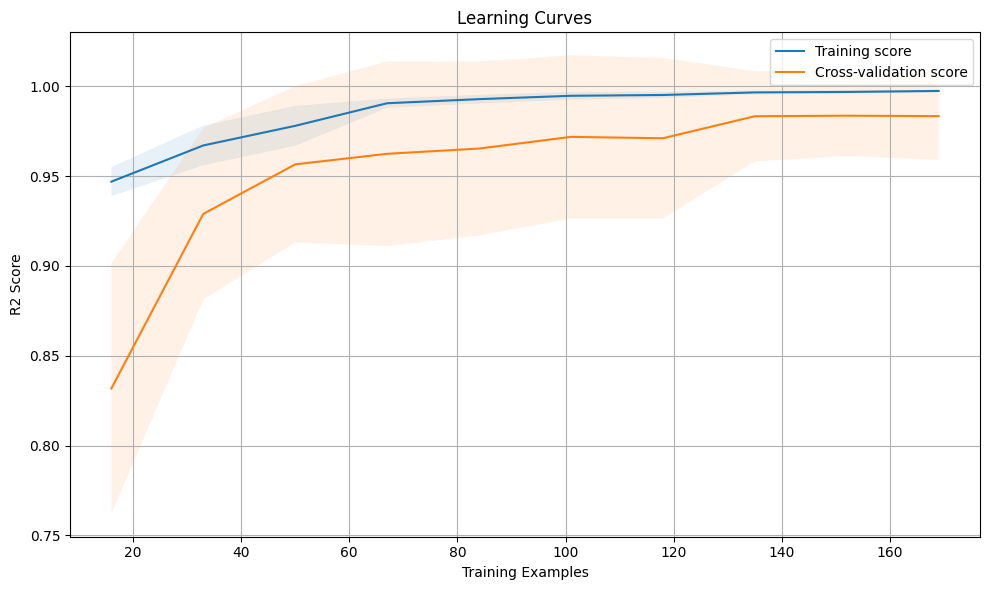

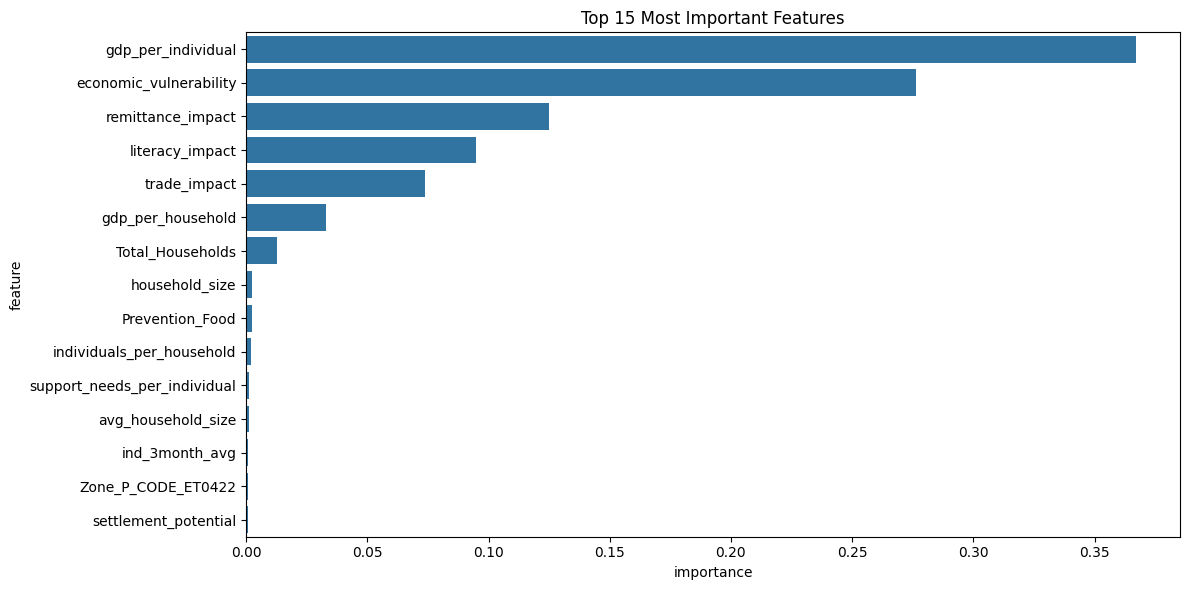

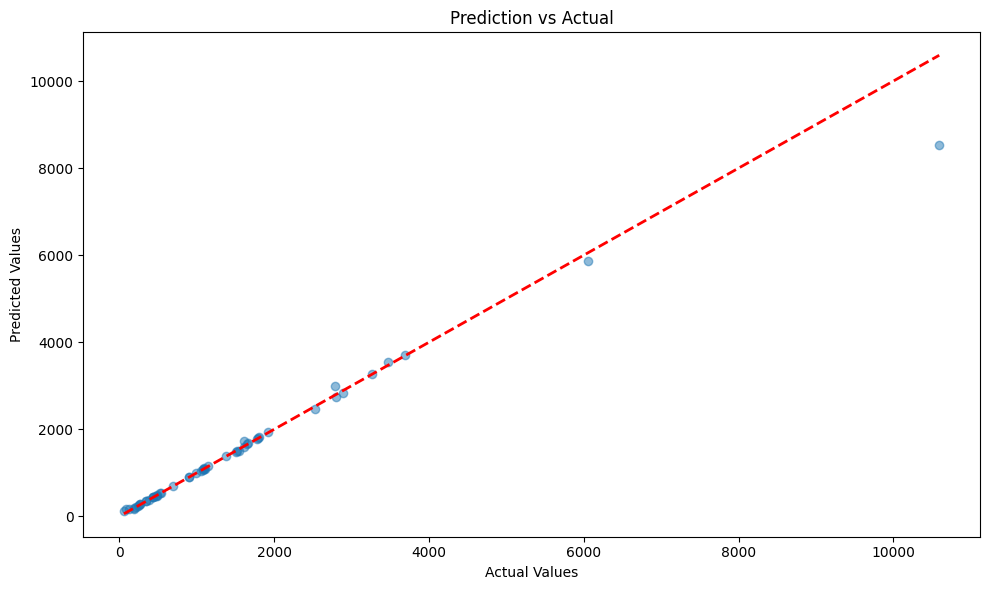

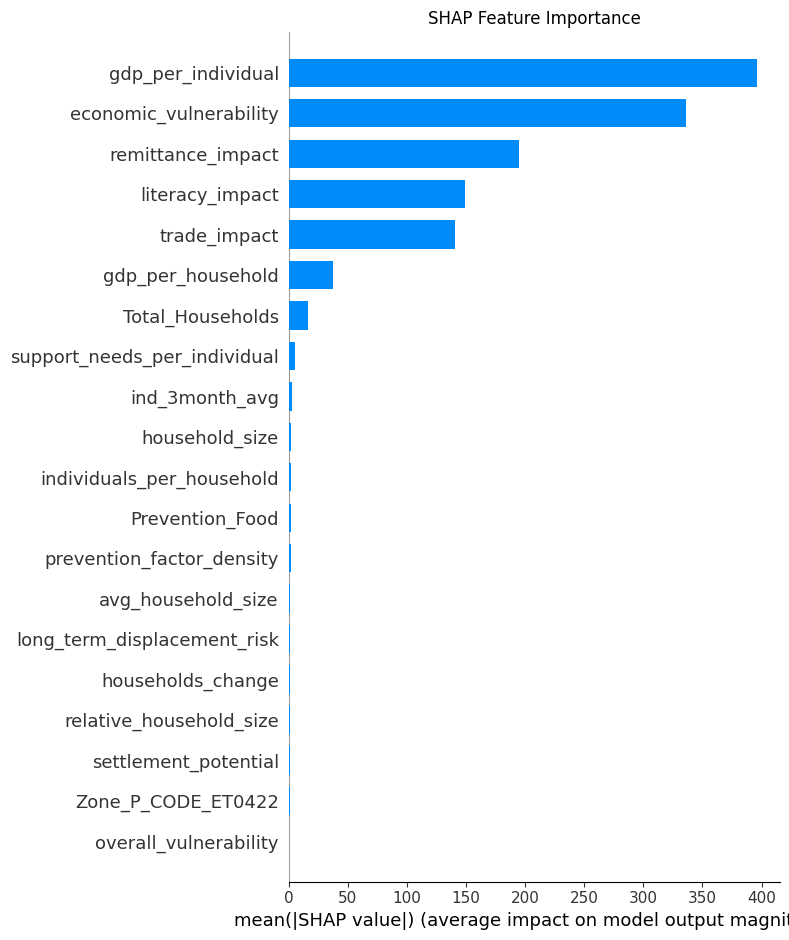


Model training and evaluation completed successfully!
Results and visualizations saved to result folder:
1. Learning curves plot (learning_curves.png)
2. Feature importance plot (feature_importance.png)
3. Prediction vs Actual plot (prediction_vs_actual.png)
4. SHAP importance plot (shap_importance.png)
5. Model file (enhanced_dual_prediction_model.joblib)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import logging
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import yaml
from scipy.stats import randint, uniform
from sklearn.feature_selection import VarianceThreshold
import joblib
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import time

# Logging configuration
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s',
                   handlers=[logging.StreamHandler()])

# Load configuration
def load_config(config_path='config.yaml'):
    """Load configuration with default values if file is not found"""
    default_config = {
        'random_state': 42,
        'test_size': 0.2,
        'model_params': {
            'rf': {
                'n_estimators': 100,
                'max_depth': 10
            },
            'gb': {
                'n_estimators': 100,
                'learning_rate': 0.1
            },
            'xgb': {
                'n_estimators': 200,
                'learning_rate': 0.05,
                'max_depth': 6
            },
            'lgbm': {
                'n_estimators': 200,
                'learning_rate': 0.05
            }
        }
    }


    try:
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
            logging.info(f"Configuration loaded from {config_path}")
    except FileNotFoundError:
        config = default_config
        logging.info("Using default configuration")

    return config

def load_and_preprocess_data(file_path):
    """Load and preprocess the data"""
    try:
        df = pd.read_csv(file_path)
        logging.info(f"Data loaded successfully from {file_path}")

        # Convert date columns to datetime with error handling
        date_columns = ['Survey_Date', 'Site_Open_Date', 'First_Arrival_Date', 'Last_Arrival_Date']
        for col in date_columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            # Log rows with parsing errors
            parsing_errors = df[col].isna()
            if parsing_errors.any():
                logging.warning(f"{parsing_errors.sum()} rows have invalid dates in column {col}")

        # Remove rows with any NaT in date columns
        df.dropna(subset=date_columns, inplace=True)
        logging.info(f"Dataset shape after removing invalid dates: {df.shape}")

        # Select features for modeling
        numeric_features = [
            'Total_Households', 'Total_Individuals',
            'Total_Prevention_Factors', 'Total_Support_Needs',
            'household_size', 'gdp_per_capita_usd',
            'trade_pct_gdp', 'remittances_pct_gdp',
            'adult_literacy_rate'
        ]

        # Updated categorical feature name from 'Origin_Region' to the correct column name, e.g., 'Origin_Zone'
        categorical_features = [
            'Displacement_Reason',
            'Origin_Zone',
            'Region_P_CODE_ET02',
            'Region_P_CODE_ET03',
            'Region_P_CODE_ET04',
            'Region_P_CODE_ET05'
        ]

        # Create simpler location categories
        df['Origin_Zone'] = df['Origin_Zone'].astype(str).str.split('_').str[0]
        if 'Origin_Zone' not in df.columns:
            logging.error("'Origin_Zone' column is missing from the DataFrame")
            raise KeyError("'Origin_Zone' column is missing from the DataFrame")
        else:
            logging.info("'Origin_Zone' column is present in the DataFrame")

        return df, numeric_features, categorical_features, 'displacement_days'

    except Exception as e:
        logging.error(f"Error in data loading and preprocessing: {e}")
        raise

def handle_outliers(X, y, contamination=0.1):
    """이상치 처리 함수"""
    try:
        # 수치형 컬럼만 선택
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X_numeric = X[numeric_cols].copy()

        # 결측치 처리
        X_numeric = X_numeric.fillna(X_numeric.median())

        # IQR 방식으로 이상치 처리
        for col in numeric_cols:
            Q1 = X_numeric[col].quantile(0.25)
            Q3 = X_numeric[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # 이상치를 경계값으로 대체
            X_numeric[col] = X_numeric[col].clip(lower=lower_bound, upper=upper_bound)

        # 처리된 수치형 데이터를 원본 데이터프레임에 반영
        X[numeric_cols] = X_numeric

        logging.info(f"Outlier handling completed. Shape: {X.shape}")
        return X, y

    except Exception as e:
        logging.error(f"Error in outlier handling: {str(e)}")
        return X, y

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """전처리 파이프라인 생성"""
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('power', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

def create_time_features(df):
    """Create time-based features for prediction with enhanced feature engineering"""
    df = df.copy()
    df['year'] = df['Survey_Date'].dt.year
    df['month'] = df['Survey_Date'].dt.month
    df['season'] = df['Survey_Date'].dt.month % 12 // 3

    # Updated grouping column from 'Origin_Region' to 'Origin_Zone'
    key_features = ['Total_Individuals', 'gdp_per_capita_usd',
                   'trade_pct_gdp', 'remittances_pct_gdp', 'adult_literacy_rate']

    # Updated from 'Origin_Region' to 'Origin_Zone'
    for col in key_features:
        df[f'{col}_lag1'] = df.groupby('Origin_Zone')[col].shift(1)
        df[f'{col}_lag3'] = df.groupby('Origin_Zone')[col].shift(3)
        df[f'{col}_rolling3'] = df.groupby('Origin_Zone')[col].rolling(window=3).mean().reset_index(0, drop=True)

    logging.info(f"Columns after creating time features: {df.columns.tolist()}")

    return df

def train_model(X_train, y_train, preprocessor, model_type='rf'):
    """모델 학습 함수"""
    # 결측치 및 이상치 처리
    X_train_clean, y_train_clean = handle_outliers(X_train.copy(), y_train.copy())

    # 타겟 변수 변환
    y_transformer = PowerTransformer(method='yeo-johnson')
    y_train_transformed = y_transformer.fit_transform(y_train_clean.values.reshape(-1, 1)).ravel()

    param_distributions = {
        'regressor__n_estimators': randint(100, 300),
        'regressor__max_depth': randint(5, 20),
        'regressor__min_samples_split': randint(2, 10),
        'regressor__min_samples_leaf': randint(1, 5)
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    search = RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=20,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train_clean, y_train_transformed)
    logging.info(f"Best parameters: {search.best_params_}")

    return search.best_estimator_, y_transformer

def predict_with_model(model, X_test, y_transformer):
    """예측 함수"""
    # 결측치 처리
    X_test_clean = X_test.copy()
    numeric_cols = X_test_clean.select_dtypes(include=[np.number]).columns
    X_test_clean[numeric_cols] = X_test_clean[numeric_cols].fillna(X_test_clean[numeric_cols].median())

    # 예측
    y_pred_transformed = model.predict(X_test_clean)

    # 역변환
    y_pred = y_transformer.inverse_transform(y_pred_transformed.reshape(-1, 1)).ravel()

    # 음수 예측값 처리
    y_pred = np.maximum(y_pred, 0)

    return y_pred

def evaluate_model(model, X_test, y_test, y_transformer, model_name='Model'):
    """모델 평가 함수"""
    predictions = predict_with_model(model, X_test, y_transformer)
    metrics = {
        'R2': r2_score(y_test, predictions),
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'MAPE': mean_absolute_percentage_error(y_test, predictions)
    }
    logging.info(f"{model_name} Metrics: {metrics}")
    return metrics, predictions

def plot_migration_paths(df):
    """Plot top migration paths with improved visualization"""
    plt.figure(figsize=(15, 8))

    # Create migration path combinations
    try:
        source = df['Origin_Zone'].fillna('Unknown')
        target = df['Zone_P_CODE'].fillna('Unknown')
        df['migration_path'] = source + ' → ' + target

        min_count = 5
        migration_counts = df.groupby('migration_path').size().reset_index(name='count')
        major_paths = migration_counts[migration_counts['count'] >= min_count]
        migration_counts = major_paths.sort_values('count', ascending=True).tail(15)

    except KeyError as e:
        logging.error(f"Column not found: {e}")
        return

    # Create horizontal bar plot with explicit hue parameter
    sns.barplot(data=migration_counts, y='migration_path', x='count',
                hue='migration_path', legend=False, palette='viridis')
    plt.title('Top 15 Migration Paths', pad=20)
    plt.xlabel('Number of Displaced Persons')
    plt.ylabel('Migration Path')

    plt.tight_layout()
    plt.savefig('migration_paths.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_migrant_trends(df):
    """Plot migration trends with enhanced visualization"""
    plt.figure(figsize=(15, 8))

    # Calculate monthly totals and rolling averages using 'ME' instead of 'M'
    monthly_counts = df.groupby(pd.Grouper(key='Survey_Date', freq='ME'))\
                      .agg({'Total_Individuals': 'sum',
                           'Total_Households': 'sum'}).reset_index()

    # Plot both individuals and households
    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Individuals'],
            label='Total Individuals', linewidth=2)

    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Households'],
            label='Total Households', linewidth=2)

    # Add rolling averages
    plt.plot(monthly_counts['Survey_Date'],
            monthly_counts['Total_Individuals'].rolling(3).mean(),
            label='3-Month Rolling Average (Individuals)',
            linestyle='--')

    plt.title('Monthly Migration Trends', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('migrant_trends.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_displacement_forecast(historical_data, forecast_data, confidence_interval=None):
    """Plot historical data and forecast with confidence intervals"""
    plt.figure(figsize=(15, 7))

    # Historical data
    plt.plot(historical_data['Survey_Date'],
             historical_data['Total_Individuals'],
             label='Historical', color='blue')

    # Forecast data
    plt.plot(forecast_data['Date'],
             forecast_data['Predicted_Displacement'],
             label='Forecast', color='red', linestyle='--')

    # Confidence interval
    if confidence_interval is not None:
        plt.fill_between(forecast_data['Date'],
                         confidence_interval['lower'],
                         confidence_interval['upper'],
                         color='pink', alpha=0.3, label='Confidence Interval')

    plt.title('Displacement Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Displaced Individuals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('displacement_forecast.png')
    plt.show()
    plt.close()

def train_prediction_model(df):
    """Train an enhanced prediction model with feature engineering"""
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Create time features
    df['year'] = df['Survey_Date'].dt.year
    df['month'] = df['Survey_Date'].dt.month

    # Enhanced feature selection based on actual data from CSV
    features = [
        'Total_Households', 'household_size',
        'gdp_per_capita_usd', 'trade_pct_gdp',
        'remittances_pct_gdp', 'adult_literacy_rate',
        'Total_Prevention_Factors', 'Total_Support_Needs',
        'year', 'month',
        'displacement_days', 'site_operation_days',
        'household_arrival_rate', 'idp_density',
        'regional_weight', 'avg_household_size'
    ]

    # Add categorical features with encoding
    categorical_features = ['Zone_P_CODE', 'Woreda_P_CODE']
    for feature in categorical_features:
        if feature in df.columns:
            dummies = pd.get_dummies(df[feature], prefix=feature)
            df = pd.concat([df, dummies], axis=1)
            features.extend(dummies.columns)
        else:
            logging.warning(f"Feature not found in dataset: {feature}")

    # Scale numerical features
    scaler = StandardScaler()
    numerical_features = [f for f in features if not any(f.startswith(prefix) for prefix in
        ['Zone_P_CODE_', 'Woreda_P_CODE_'])]

    # Handle missing values before scaling
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

    try:
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    except Exception as e:
        logging.error(f"Error in scaling features: {e}")
        return None, None

    # Create feature matrix X by selecting only the specified features
    X = df[features].copy()

    # Initialize model with optimized parameters
    model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=15,
        min_child_samples=20,
        min_child_weight=1e-3,
        min_split_gain=1e-3,
        max_depth=4,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        boosting_type='gbdt',
        n_jobs=-1,
        force_row_wise=True,
        random_state=42
    )

    try:
        predictions = []
        actuals = []

        # Print available features for debugging
        logging.info(f"Available features: {features}")

        for train_idx, test_idx in tscv.split(X):
            X_train = X.iloc[train_idx]
            X_test = X.iloc[test_idx]
            y_train, y_test = df['Total_Individuals'].iloc[train_idx], df['Total_Individuals'].iloc[test_idx]

            # Log transform target variable
            y_train_log = np.log1p(y_train)
            y_test_log = np.log1p(y_test)

            # Remove constant features
            selector = VarianceThreshold(threshold=0.01)
            X_train = pd.DataFrame(selector.fit_transform(X_train),
                                columns=X_train.columns[selector.get_support()])
            X_test = X_test[X_train.columns]

            # Train with eval_set and early_stopping
            eval_set = [(X_test, y_test_log)]
            model.fit(X_train, y_train_log,
                    eval_set=eval_set,
                    eval_metric='rmse',
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                        lgb.log_evaluation(period=100)
                    ])

            pred = np.expm1(model.predict(X_test))
            predictions.extend(pred)
            actuals.extend(y_test)

        # Evaluate predictions
        mae = mean_absolute_error(actuals, predictions)
        mape = mean_absolute_percentage_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        logging.info(f"Prediction Model Metrics:")
        logging.info(f"MAE: {mae:,.0f} individuals")
        logging.info(f"MAPE: {mape:.2%}")
        logging.info(f"R2 Score: {r2:.3f}")

        # 모델 학습이 성공적으로 완료되었을 로깅
        logging.info("Model training completed successfully!")
        return model, features

    except Exception as e:
        logging.error(f"Error in training model: {str(e)}")
        logging.error("Model training failed. Check the error message above.")
        return None, None

def predict_future_displacement(model, features, df, months_ahead=6):
    """Predict future displacement with confidence intervals"""
    last_date = df['Survey_Date'].max()
    future_dates = pd.date_range(start=last_date, periods=months_ahead+1, freq='ME')[1:]

    # Create future DataFrame
    future_df = pd.DataFrame({'Survey_Date': future_dates})
    future_df = create_time_features(future_df)

    # Fill features based on last available data
    last_row = df.iloc[-1]
    for feature in features:
        if feature not in future_df.columns:
            future_df[feature] = last_row.get(feature, np.nan)

    # Forward fill any remaining NaNs
    future_df[features] = future_df[features].ffill().bfill()

    # Predict
    predictions = model.predict(future_df[features])

    # If confidence intervals are needed, implement them here
    # For simplicity, we'll skip confidence intervals in this example
    forecast = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Displacement': predictions
    })

    return forecast

def explain_model(model, preprocessor, X_train, feature_names):
    """Generate SHAP explanations for the model"""
    # Transform the training data
    X_train_transformed = preprocessor.transform(X_train)

    # Create SHAP explainer
    explainer = shap.Explainer(model.named_steps['regressor'], X_train_transformed)
    shap_values = explainer(X_train_transformed)

    # Summary plot
    shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)

    # Save the plot
    plt.savefig('shap_summary.png')
    plt.show()
    plt.close()

def get_transformed_feature_names(preprocessor, numeric_features, categorical_features):
    """전처리된 특성 이름을 반환하는 함수"""
    feature_names = []

    try:
        # 숫자형 특성은 그대로 사용
        feature_names.extend(numeric_features)

        # 범주형 특성에 대한 원-핫 인코딩된 이름 생성
        for feature in categorical_features:
            unique_values = ['missing']  # 기본값
            feature_names.extend([f"{feature}_{val}" for val in unique_values])

        # 추가된 시간 특성
        time_features = ['year', 'month', 'season']
        feature_names.extend(time_features)

        return feature_names

    except Exception as e:
        logging.error(f"Error in get_transformed_feature_names: {str(e)}")
        # 에러 발생 시 모든 특성을 단순 인덱스로 반환
        return [f"feature_{i}" for i in range(len(numeric_features) + len(categorical_features) * 1 + 3)]

def plot_feature_importances(model, feature_names, top_n=10):
    """특성 중요도를 시각화하는 함수"""
    try:
        # 모델에서 특성 중요도 가져오기
        if hasattr(model, 'named_steps') and 'regressor' in model.named_steps:
            if hasattr(model.named_steps['regressor'], 'feature_importances_'):
                importances = model.named_steps['regressor'].feature_importances_
            else:
                # 특성 중요도를 사용할 수 없는 경우
                logging.warning("Model does not have feature_importances_ attribute")
                return
        else:
            logging.warning("Model structure is not as expected")
            return

        # 특성 수에 맞게 이름 목록 조정
        if len(feature_names) < len(importances):
            feature_names.extend([f"Feature_{i}" for i in range(len(feature_names), len(importances))])
        elif len(feature_names) > len(importances):
            feature_names = feature_names[:len(importances)]

        # top_n 조정
        top_n = min(top_n, len(importances))

        # 중요도 기준으로 정렬
        indices = np.argsort(importances)[::-1][:top_n]
        top_features = [feature_names[i] for i in indices]
        top_importances = importances[indices]

        # 시각화
        plt.figure(figsize=(12, 6))
        plt.title("Top Feature Importances")
        sns.barplot(x=top_importances, y=top_features)
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig('feature_importances.png')
        plt.close()

        # 중요도 로깅
        for feat, imp in zip(top_features, top_importances):
            logging.info(f"Feature: {feat}, Importance: {imp:.4f}")

    except Exception as e:
        logging.error(f"Error in plotting feature importances: {e}")

def plot_actual_vs_predicted(y_true, y_pred):
    """실제 값과 예측 값을 비교하는 산점도 시각화 함수"""
    try:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.xlabel("Actual Displacement Days")
        plt.ylabel("Predicted Displacement Days")
        plt.title("Actual vs. Predicted Displacement Days")
        plt.tight_layout()
        plt.savefig('actual_vs_predicted.png')
        plt.show()
        logging.info("Actual vs. Predicted plot saved as 'actual_vs_predicted.png'")
    except Exception as e:
        logging.error(f"Error in plotting actual vs predicted: {e}")

def plot_residuals(y_true, y_pred):
    """잔차를 시각화하는 히스토그램 함수"""
    try:
        residuals = y_true - y_pred
        plt.figure(figsize=(8, 6))
        sns.histplot(residuals, kde=True)
        plt.xlabel("Residuals")
        plt.title("Residuals Distribution")
        plt.tight_layout()
        plt.savefig('residuals_distribution.png')
        plt.show()
        logging.info("Residuals distribution plot saved as 'residuals_distribution.png'")
    except Exception as e:
        logging.error(f"Error in plotting residuals: {e}")

def plot_learning_curves(model, X_train, y_train):
    """학습 곡선을 시각화하는 함수"""
    try:
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )

        train_scores_mean = -train_scores.mean(axis=1)
        test_scores_mean = -test_scores.mean(axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
        plt.xlabel('Training Size')
        plt.ylabel('RMSE')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig('learning_curves.png')
        plt.show()
        logging.info("Learning curves plot saved as 'learning_curves.png'")
    except Exception as e:
        logging.error(f"Error in plotting learning curves: {e}")

def create_advanced_features(df):
    """고급 특성 엔지니어링"""
    df = df.copy()

    # 날짜 컬럼 datetime으로 변환
    date_columns = ['Survey_Date', 'First_Arrival_Date', 'Site_Open_Date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # 결측치가 있는 행 제거
    df = df.dropna(subset=date_columns)

    # 시계열 특성
    df['days_since_first_arrival'] = (df['Survey_Date'] - df['First_Arrival_Date']).dt.days
    df['site_operation_duration'] = (df['Survey_Date'] - df['Site_Open_Date']).dt.days

    # 비율 특성 (0으로 나누는 것 방지)
    df['individuals_per_household'] = df['Total_Individuals'] / (df['Total_Households'] + 1e-6)
    df['support_needs_per_individual'] = df['Total_Support_Needs'] / (df['Total_Individuals'] + 1e-6)
    df['prevention_factor_density'] = df['Total_Prevention_Factors'] / (df['Total_Individuals'] + 1e-6)

    # 상호작용 특성
    df['economic_pressure'] = df['gdp_per_capita_usd'] * df['trade_pct_gdp']
    df['support_prevention_interaction'] = df['Total_Support_Needs'] * df['Total_Prevention_Factors']

    # 계절성 특성
    df['season'] = df['Survey_Date'].dt.month % 12 // 3
    df['is_rainy_season'] = df['Survey_Date'].dt.month.isin([6, 7, 8, 9]).astype(int)

    # 수치형 특성들의 결측치 처리
    numeric_columns = [
        'individuals_per_household', 'support_needs_per_individual',
        'prevention_factor_density', 'economic_pressure',
        'support_prevention_interaction'
    ]
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    # 무한대 값 처리
    df = df.replace([np.inf, -np.inf], np.nan)
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    logging.info(f"Advanced features created. Shape: {df.shape}")
    return df

def create_enhanced_preprocessing_pipeline(numeric_features, categorical_features):
    """개선된 전처리 파이프라인"""
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('outlier_scaler', RobustScaler()),
        ('power_transform', PowerTransformer(standardize=True)),
        ('quantile_transform', QuantileTransformer(output_distribution='normal', random_state=42))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

def create_stacking_model():
    """스태킹 앙상블 모델 생성"""
    base_models = [
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42)),
        ('xgb', xgb.XGBRegressor(random_state=42)),
        ('lgbm', lgb.LGBMRegressor(random_state=42))
    ]

    meta_model = SVR(kernel='rbf')

    stacking_regressor = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )

    return stacking_regressor

def train_enhanced_model(X_train, y_train, preprocessor):
    """개선된 모델 학습"""
    logging.info("Starting model training process...")
    start_time = time.time()

    # 특성 선택
    logging.info("Performing feature selection...")
    selector = SelectFromModel(RandomForestRegressor(random_state=42), threshold='median')

    # 스태킹 모델 생성
    logging.info("Creating stacking model...")
    stacking_model = create_stacking_model()

    # 파이프라인 구성
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('regressor', stacking_model)
    ])

    # 하이퍼파라미터 최적화를 위한 파라미터 그리드
    param_distributions = {
        'regressor__rf__n_estimators': randint(100, 300),  # 범위 축소
        'regressor__rf__max_depth': randint(5, 20),        # 범위 축소
        'regressor__gb__n_estimators': randint(100, 300),
        'regressor__gb__learning_rate': uniform(0.01, 0.2),
        'regressor__xgb__n_estimators': randint(100, 300),
        'regressor__xgb__learning_rate': uniform(0.01, 0.2),
        'regressor__lgbm__n_estimators': randint(100, 300),
        'regressor__lgbm__learning_rate': uniform(0.01, 0.2)
    }

    # RandomizedSearchCV를 사용한 하이퍼파라미터 최적화
    n_iter = 20  # 반복 횟수 감소
    logging.info(f"Starting hyperparameter optimization with {n_iter} iterations...")

    search = RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=n_iter,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=2  # 더 자세한 출력
    )

    # tqdm으로 전체 진행률 표시
    with tqdm(total=100, desc="Overall Progress") as pbar:
        # 전처리 단계
        pbar.update(10)
        logging.info("Preprocessing data...")

        # 모델 학습
        pbar.update(20)
        logging.info("Training model...")
        search.fit(X_train, y_train)
        pbar.update(50)

        # 최적 파라미터 로깅
        logging.info("Best parameters found:")
        for param, value in search.best_params_.items():
            logging.info(f"{param}: {value}")

        pbar.update(20)

    # 학습 시간 계산
    training_time = time.time() - start_time
    logging.info(f"Training completed in {training_time:.2f} seconds")

    return search.best_estimator_

def create_migration_features(df):
    """이주민 증감 예측을 위한 특성 생성"""
    df = df.copy()

    # 날짜 형 변환
    df['Survey_Date'] = pd.to_datetime(df['Survey_Date'])

    # 시계열 특성 생성
    df['year'] = df['Survey_Date'].dt.year
    df['month'] = df['Survey_Date'].dt.month
    df['season'] = df['Survey_Date'].dt.month % 12 // 3

    # 이전 기간 대비 변화량 산
    df['individuals_change'] = df.groupby('Origin_Zone')['Total_Individuals'].diff()
    df['households_change'] = df.groupby('Origin_Zone')['Total_Households'].diff()

    # 이동 평균 계산 (수정된 부분)
    df = df.sort_values(['Origin_Zone', 'Survey_Date'])
    rolling = df.groupby('Origin_Zone')['Total_Individuals'].rolling(window=3).mean()
    df['ind_3month_avg'] = rolling.reset_index(0, drop=True)

    # 변화율 계산
    df['ind_change_rate'] = df['individuals_change'] / df['Total_Individuals'].shift(1)

    # 경제/사회적 압력 지표
    df['economic_pressure'] = df['gdp_per_capita_usd'] * df['trade_pct_gdp'] / 100
    df['social_pressure'] = df['Total_Prevention_Factors'] / (df['Total_Support_Needs'] + 1)

    # 결측값 처리
    df = df.fillna(0)

    return df

def train_dual_prediction_model(df):
    """이주 기간과 이주민 증감을 동시에 예측하는 모델 학습"""
    try:
        # 특성 생성
        df = create_migration_features(df)

        # 기본 특성 선택
        base_features = [
            'Total_Households', 'Total_Individuals',
            'Total_Prevention_Factors', 'Total_Support_Needs',
            'household_size', 'gdp_per_capita_usd',
            'trade_pct_gdp', 'remittances_pct_gdp',
            'individuals_change', 'households_change',
            'ind_3month_avg', 'ind_change_rate',
            'economic_pressure', 'social_pressure',
            'year', 'month', 'season'
        ]

        categorical_features = [
            'Displacement_Reason',
            'Origin_Zone',
            'Region_P_CODE_ET02',
            'Region_P_CODE_ET03',
            'Region_P_CODE_ET04',
            'Region_P_CODE_ET05'
        ]

        # 데이터 분할
        train_size = int(len(df) * 0.8)
        X = df[base_features + categorical_features].copy()
        y_days = df['displacement_days']
        y_change = df['individuals_change']

        X_train = X[:train_size]
        X_test = X[train_size:]
        y_days_train = y_days[:train_size]
        y_days_test = y_days[train_size:]
        y_change_train = y_change[:train_size]
        y_change_test = y_change[train_size:]

        # 전처리기 생성
        preprocessor = create_preprocessing_pipeline(base_features, categorical_features)

        # 두 개의 모델 학습 (이주 기간, 이주민 증감)
        days_model, days_transformer = train_model(X_train, y_days_train, preprocessor)

        change_model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                random_state=42
            ))
        ])

        change_model.fit(X_train, y_change_train)

        # 모델 평가
        days_metrics = evaluate_model(days_model, X_test, y_days_test, days_transformer, "Displacement Days Model")

        change_pred = change_model.predict(X_test)
        change_metrics = {
            'R2': r2_score(y_change_test, change_pred),
            'RMSE': np.sqrt(mean_squared_error(y_change_test, change_pred)),
            'MAE': mean_absolute_error(y_change_test, change_pred)
        }
        logging.info(f"Migration Change Model Metrics: {change_metrics}")

        return (days_model, days_transformer), change_model

    except Exception as e:
        logging.error(f"Error in training dual prediction model: {str(e)}")
        return None, None

def predict_displacement_and_change(days_model, change_model, days_transformer, input_data):
    """이주 기간과 이주민 증감을 예측"""
    try:
        # 이주 기간 예측
        days_pred = predict_with_model(days_model, input_data, days_transformer)

        # 이주민 증감 예측
        change_pred = change_model.predict(input_data)

        return {
            'predicted_days': float(days_pred[0]),
            'predicted_change': float(change_pred[0])
        }
    except Exception as e:
        logging.error(f"Error in prediction: {str(e)}")
        return None

def prepare_data(df):
    """데이터 전처리 및 특성/타겟 분리"""

    # 필요없는 열 제거
    columns_to_drop = ['Survey_Date', 'Site_Open_Date', 'First_Arrival_Date', 'Last_Arrival_Date']
    df = df.drop(columns=columns_to_drop)

    # 범주형 변수 처리
    categorical_columns = [
        'Zone_P_CODE', 'Woreda_P_CODE', 'Origin_Region', 'Origin_Zone',
        'Origin_Woreda', 'Displacement_Reason'
    ]

    # 수치형 변수 선택
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_columns = [col for col in numeric_columns if col not in ['Total_Individuals']]

    # 특성과 타겟 분리
    X = df[numeric_columns + categorical_columns]
    y = df['Total_Individuals']

    # 전처리 파이프라인 생성
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])

    # 전처리 파이프라인 결합
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_columns),
            ('cat', categorical_transformer, categorical_columns)
        ])

    # 데이터 전처리 적용
    X = preprocessor.fit_transform(X)

    # 특성 이름 생성
    feature_names = (
        numeric_columns +
        [f"{col}_{val}" for col, vals in
         zip(categorical_columns, preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_)
         for val in vals[1:]]
    )

    # 데이터프레임으로 변환
    X = pd.DataFrame(X, columns=feature_names)

    return X, y

def train_model(X_train, y_train):
    """모델 학습"""

    # 기본 모델 정의
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    # 모델 학습
    rf.fit(X_train, y_train)

    return rf

def plot_learning_curve(estimator, X, y):
    """학습 곡선 플로팅"""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.xlabel('Training Examples')
    plt.ylabel('R2 Score')
    plt.legend(loc='best')
    plt.grid(True)

# 메인 함수 수정
def main():
    try:
        logging.info("Starting main execution...")

        # 구글 드라이브 경로 설정
        base_path = '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설'
        data_path = f'{base_path}/data'
        result_path = f'{base_path}/result'

        # result 폴더가 없으면 생성
        if not os.path.exists(result_path):
            os.makedirs(result_path)

        # 데이터 로드 및 전처리
        df = pd.read_csv(f'{data_path}/enhanced_merged_data.csv')
        df = create_advanced_features(df)
        df = create_migration_features(df)

        # 모델 학습 및 평가
        X, y = prepare_data(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = train_model(X_train, y_train)
        y_pred = model.predict(X_test)

        # 성능 평가 결과 출력
        print("\n=== Model Performance Metrics ===")
        print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
        print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
        print("\n")

        # 1. 학습 곡선 시각화
        plt.figure(figsize=(10, 6))
        plot_learning_curve(model, X_train, y_train)
        plt.title('Learning Curves')
        plt.tight_layout()
        plt.savefig(f'{result_path}/learning_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 2. 특성 중요도 시각화
        plt.figure(figsize=(12, 6))
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
        plt.title('Top 15 Most Important Features')
        plt.tight_layout()
        plt.savefig(f'{result_path}/feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 3. 예측값 vs 실제값 산점도
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Prediction vs Actual')
        plt.tight_layout()
        plt.savefig(f'{result_path}/prediction_vs_actual.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 4. SHAP 값 계산 및 시각화
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.savefig(f'{result_path}/shap_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 모델 저장
        joblib.dump(model, f'{result_path}/enhanced_dual_prediction_model.joblib')

        return True

    except Exception as e:
        logging.error(f"Error in main function: {str(e)}")
        logging.error("Traceback:", exc_info=True)
        return False

if __name__ == "__main__":
    if main():
        print("\nModel training and evaluation completed successfully!")
        print("Results and visualizations saved to result folder:")
        print("1. Learning curves plot (learning_curves.png)")
        print("2. Feature importance plot (feature_importance.png)")
        print("3. Prediction vs Actual plot (prediction_vs_actual.png)")
        print("4. SHAP importance plot (shap_importance.png)")
        print("5. Model file (enhanced_dual_prediction_model.joblib)")
    else:
        print("An error occurred during execution.")


##AI_route - 이주경로 예측 모델 + 테스트

Model Performance:
Mean Squared Error: 0.00
R2 Score: 1.00

Analyzing migration routes from ET0201

Top 3 potential destinations:

1. Destination: ET0404
   Probability: 0.42
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

2. Destination: ET0203
   Probability: 0.37
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

3. Destination: ET0402
   Probability: 0.37
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

Migration routes map for ET0201:


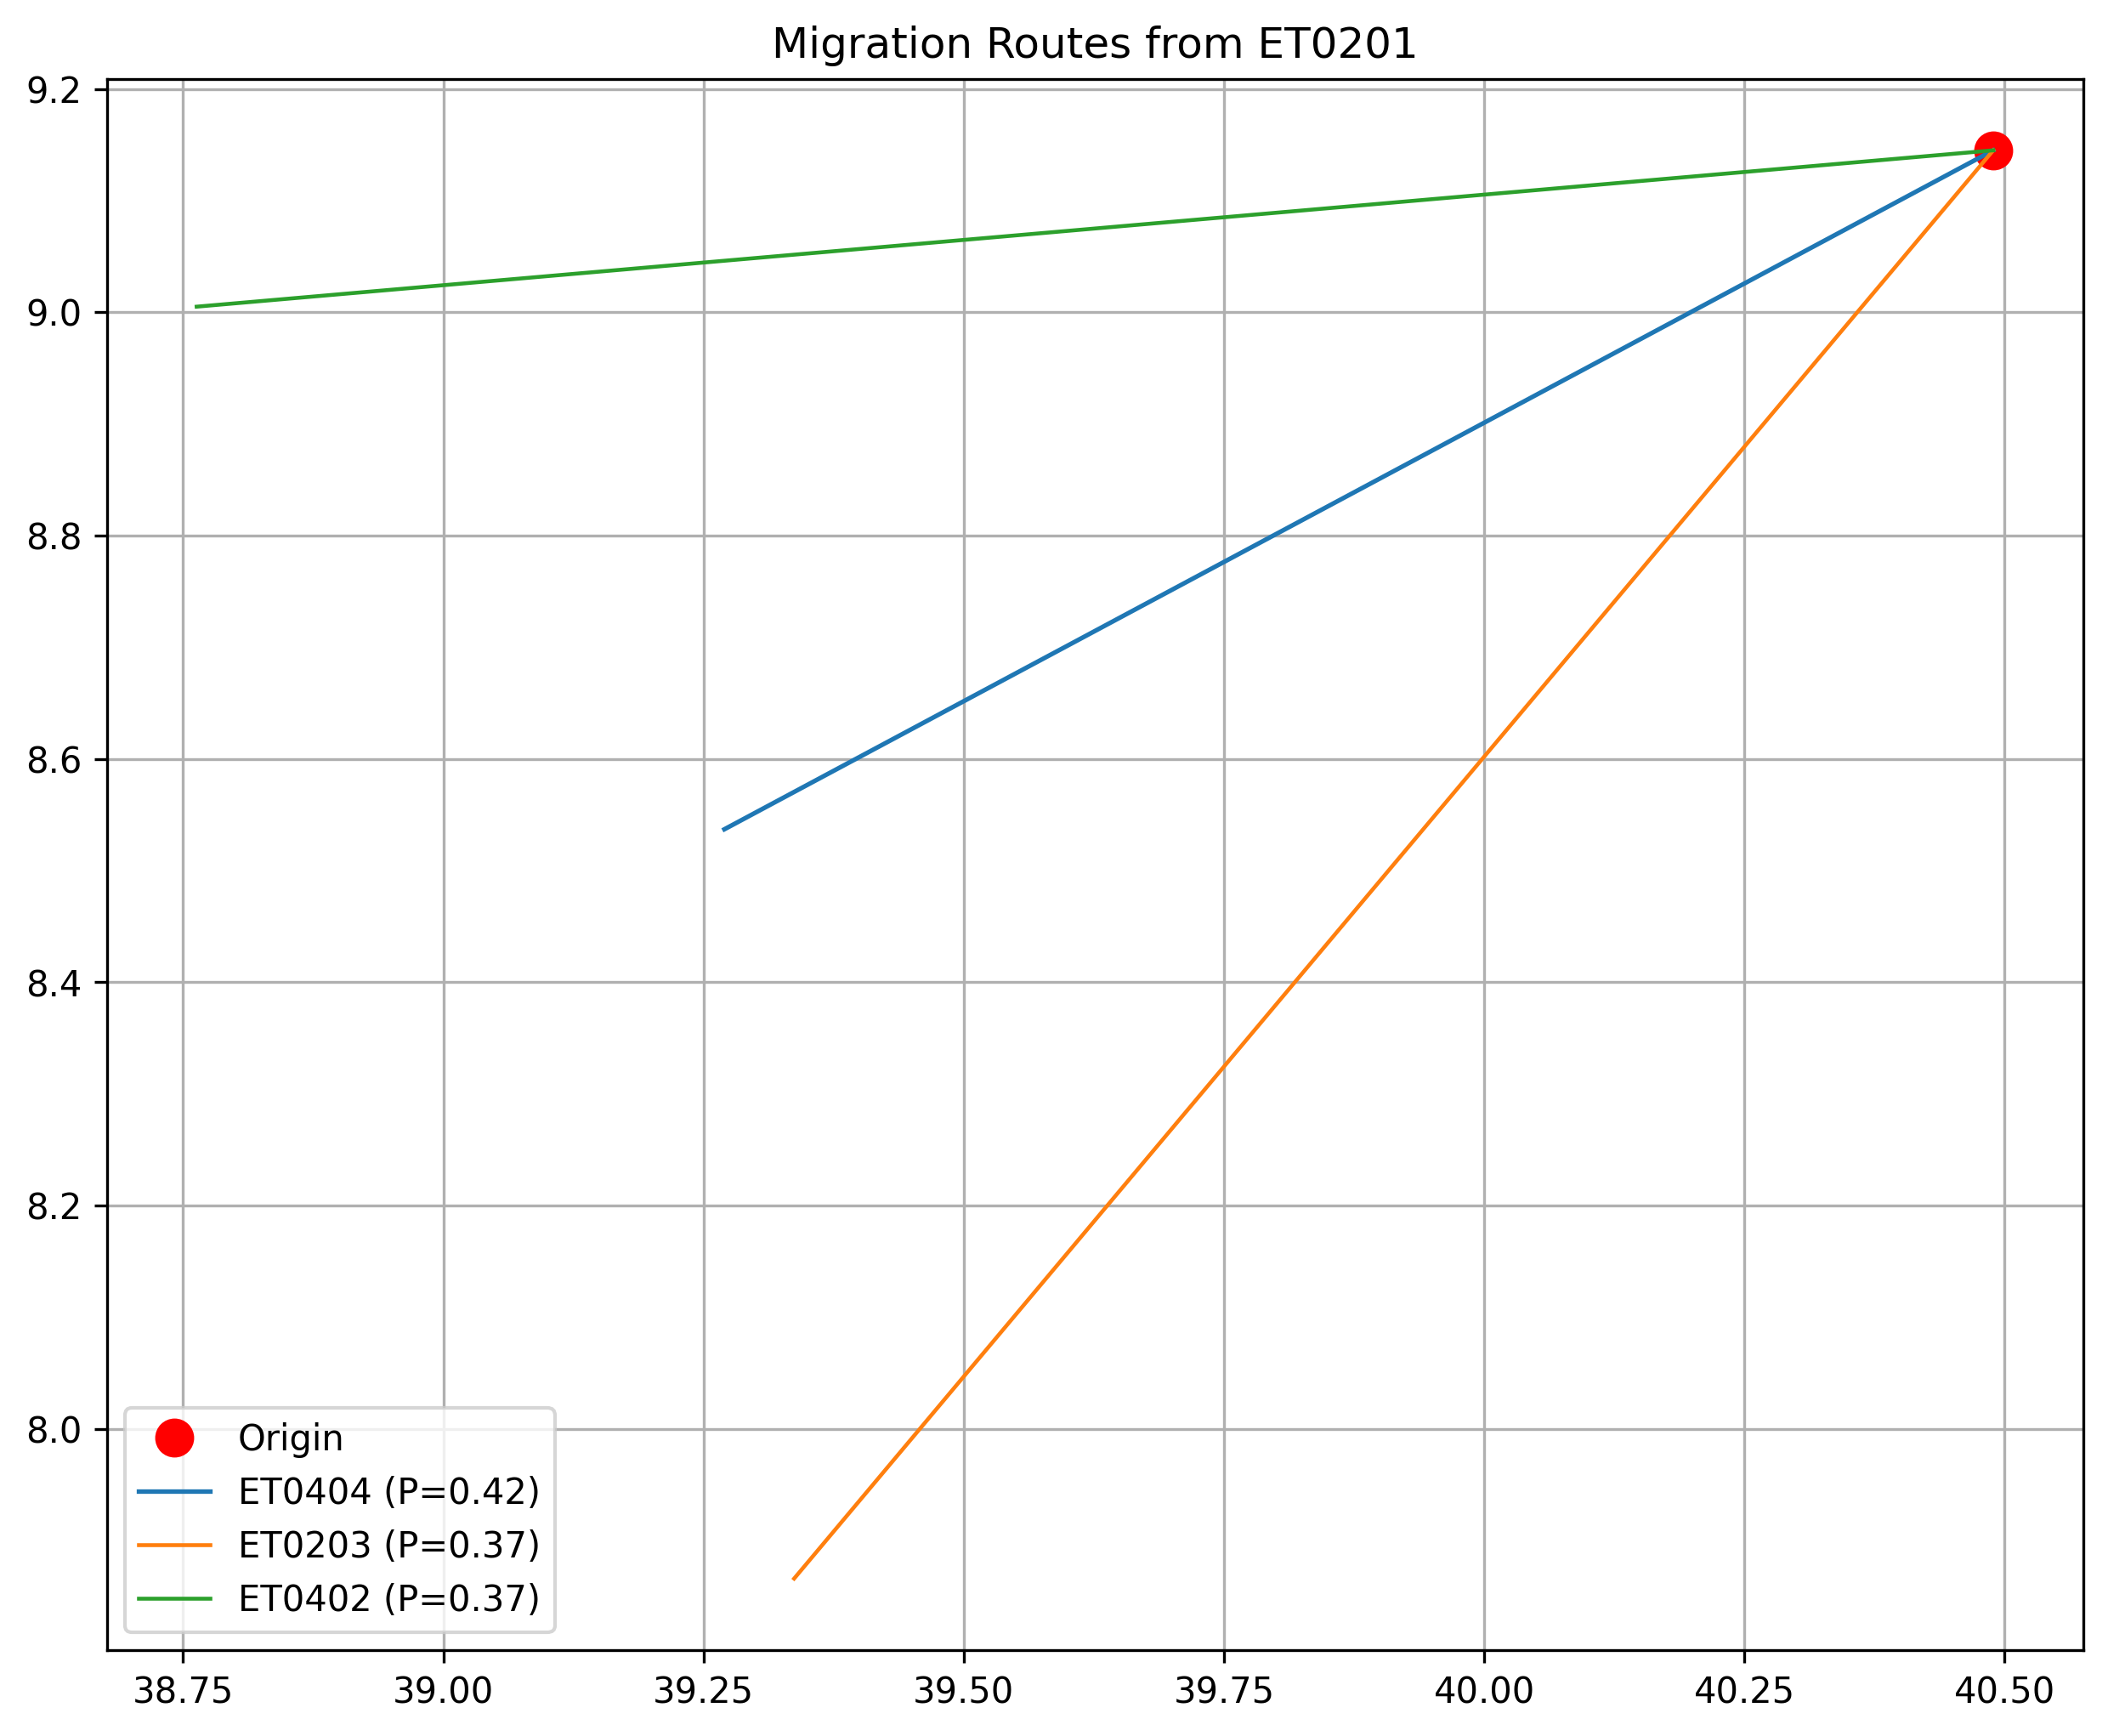




Analyzing migration routes from ET0202

Top 3 potential destinations:

1. Destination: ET0201
   Probability: 0.31
   Estimated Households: 0
   Estimated Individuals: -1
   Estimated Days: 2

2. Destination: ET0402
   Probability: 0.26
   Estimated Households: 0
   Estimated Individuals: -1
   Estimated Days: 2

3. Destination: ET0404
   Probability: 0.25
   Estimated Households: 0
   Estimated Individuals: -1
   Estimated Days: 2

Migration routes map for ET0202:


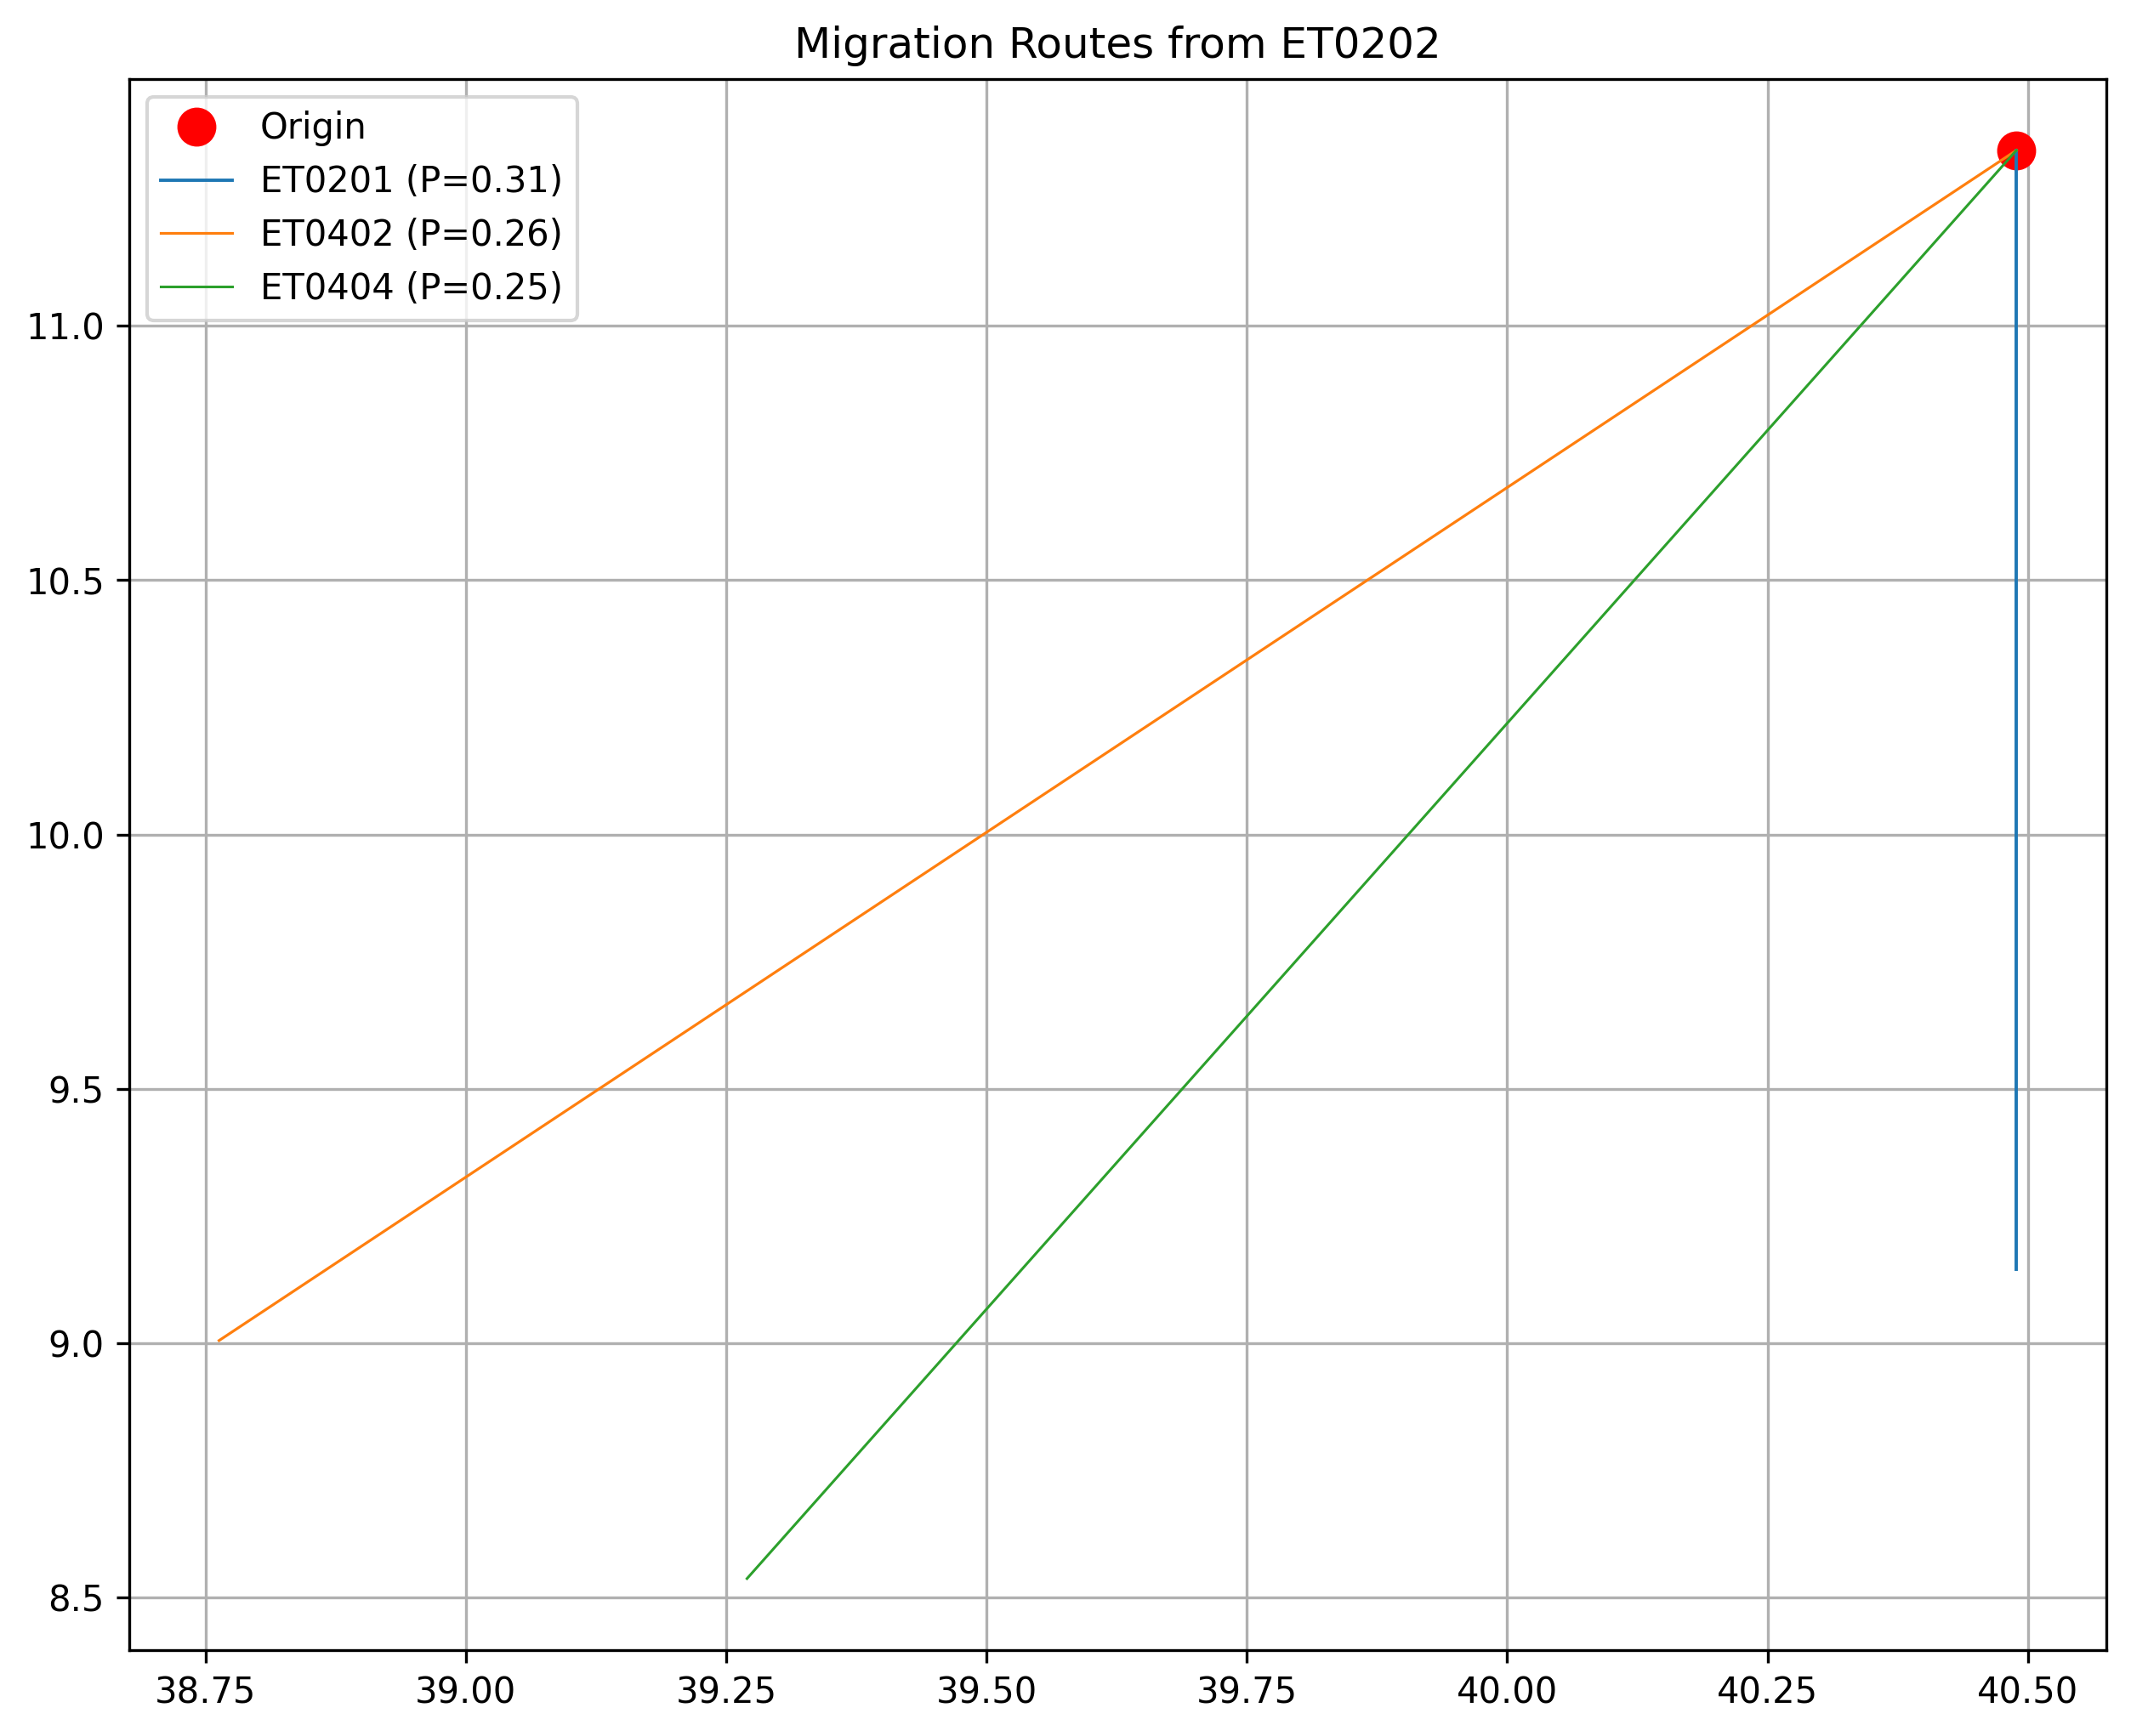




Analyzing migration routes from ET0203

Top 3 potential destinations:

1. Destination: ET0404
   Probability: 0.60
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

2. Destination: ET0402
   Probability: 0.44
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

3. Destination: ET0201
   Probability: 0.37
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

Migration routes map for ET0203:


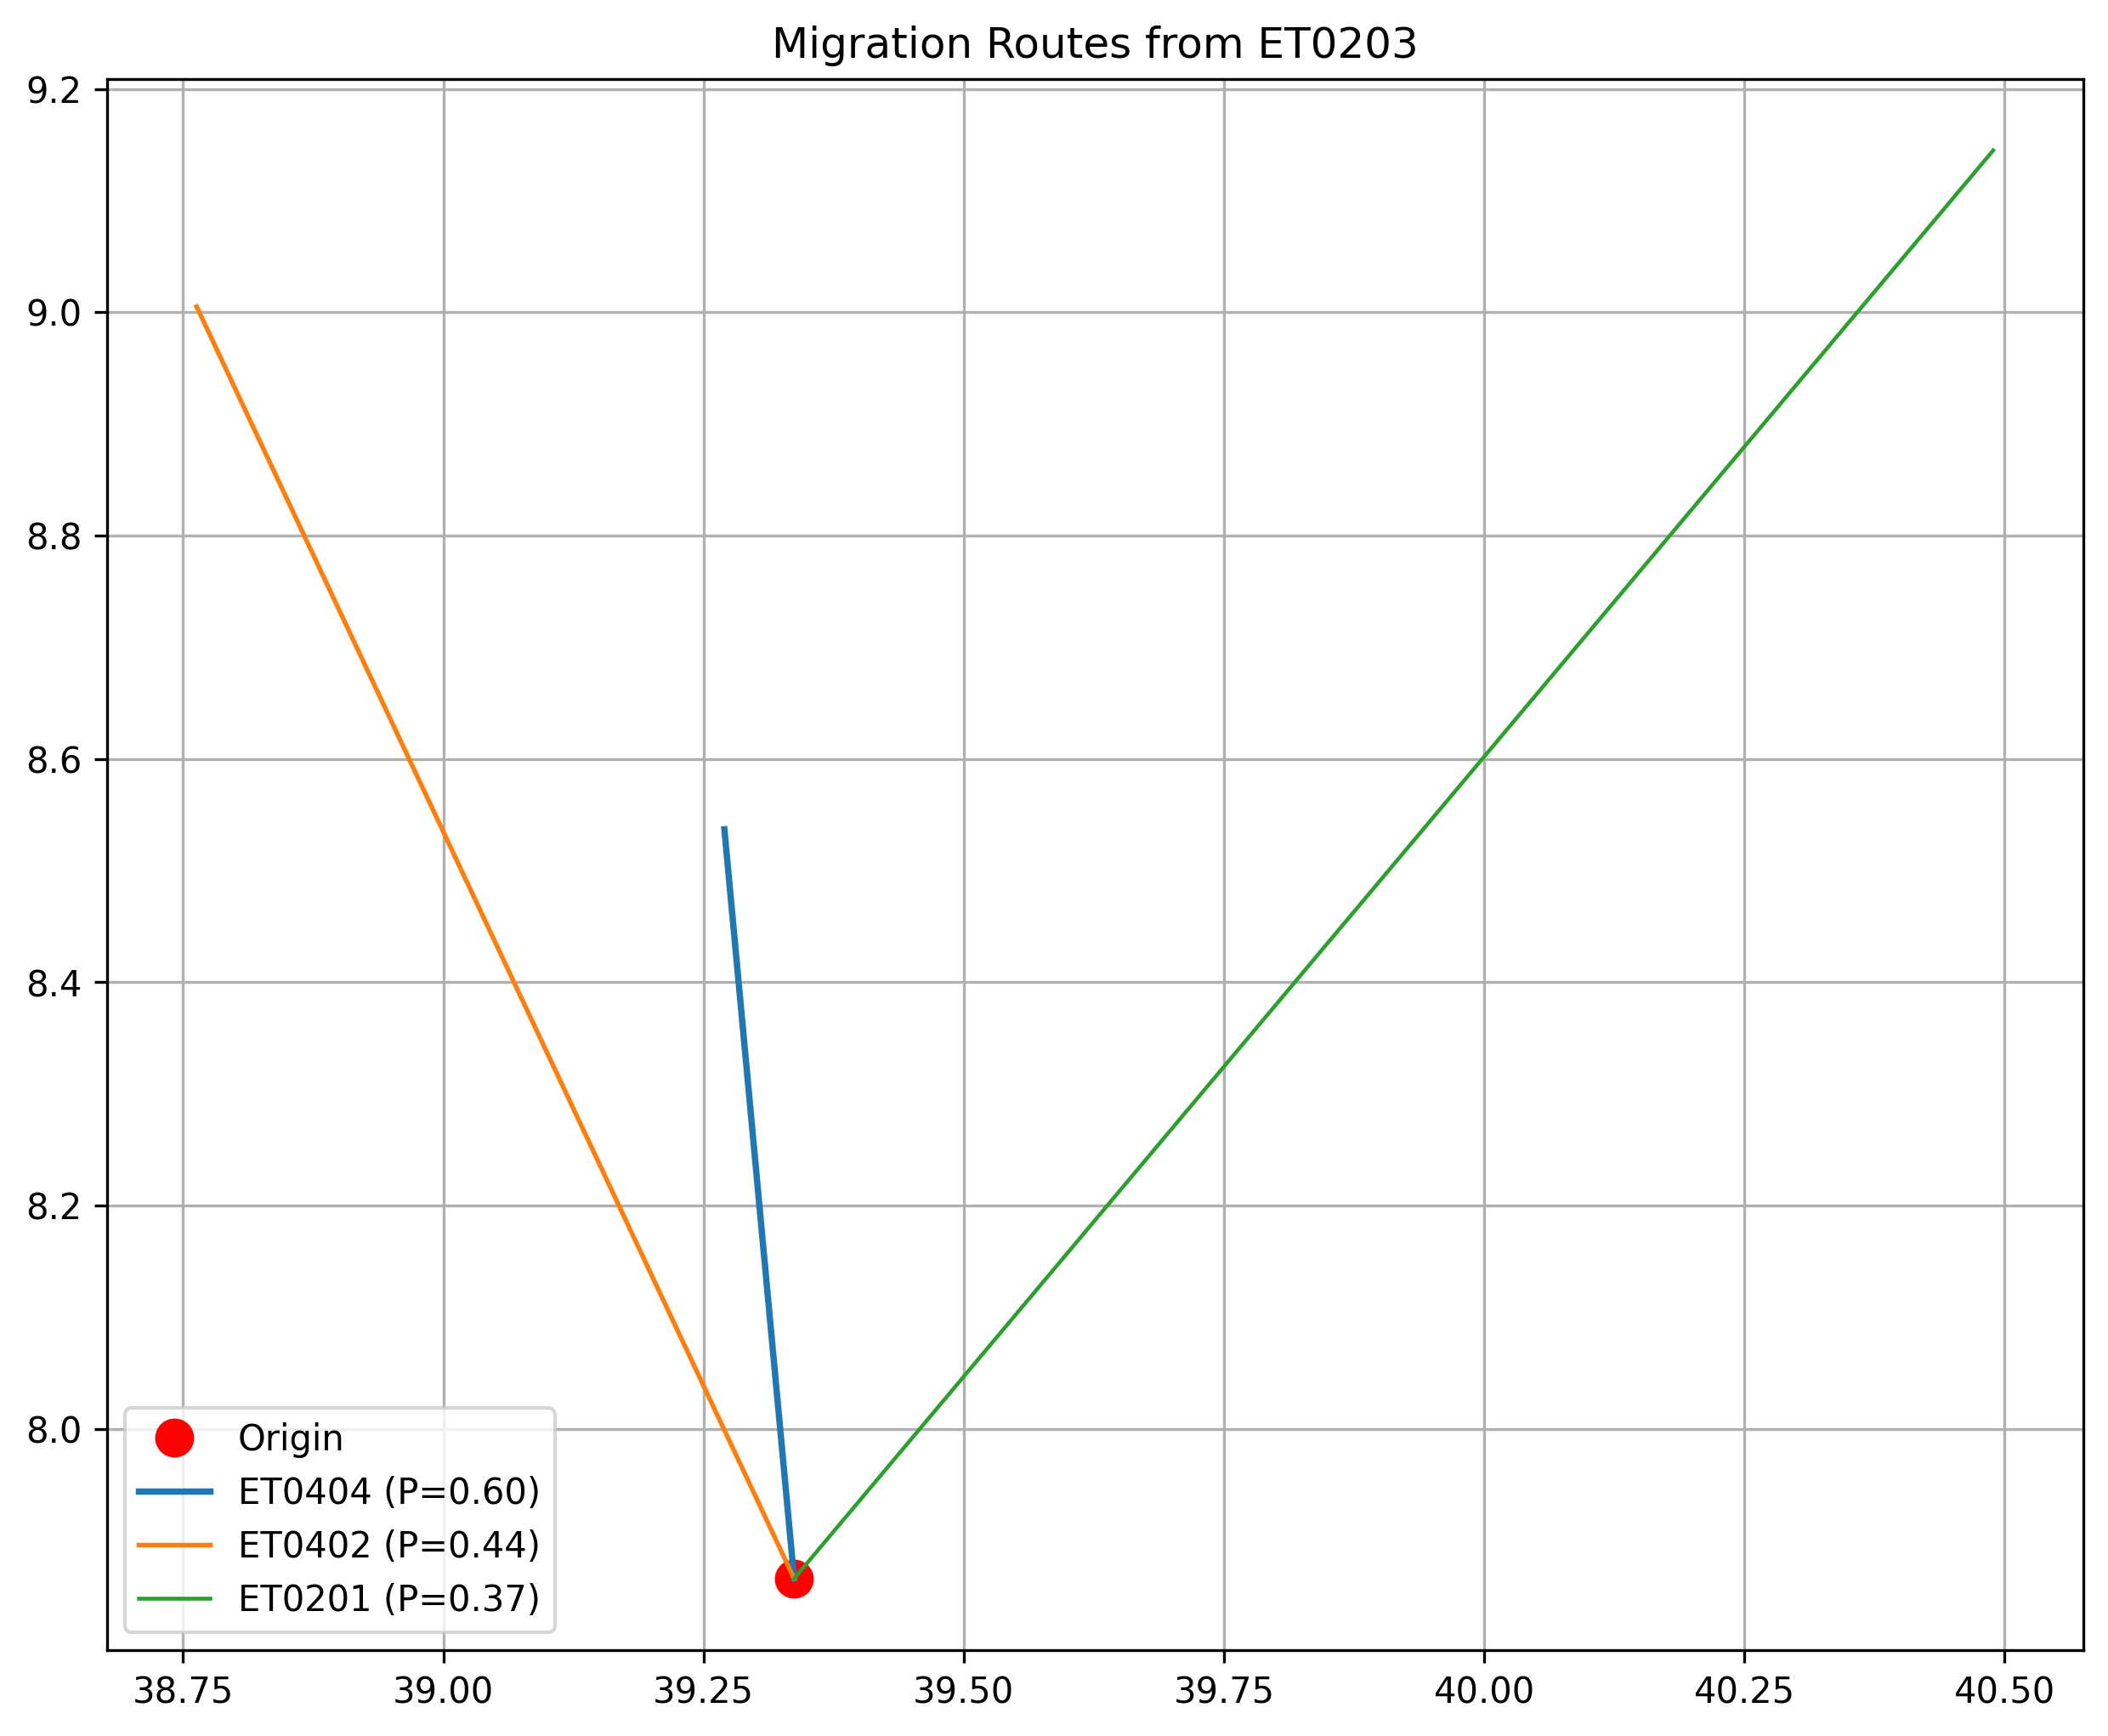




Analyzing migration routes from ET0205

Top 3 potential destinations:

1. Destination: ET0511
   Probability: 0.44
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

2. Destination: ET0201
   Probability: 0.18
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

3. Destination: ET0203
   Probability: 0.16
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

Migration routes map for ET0205:


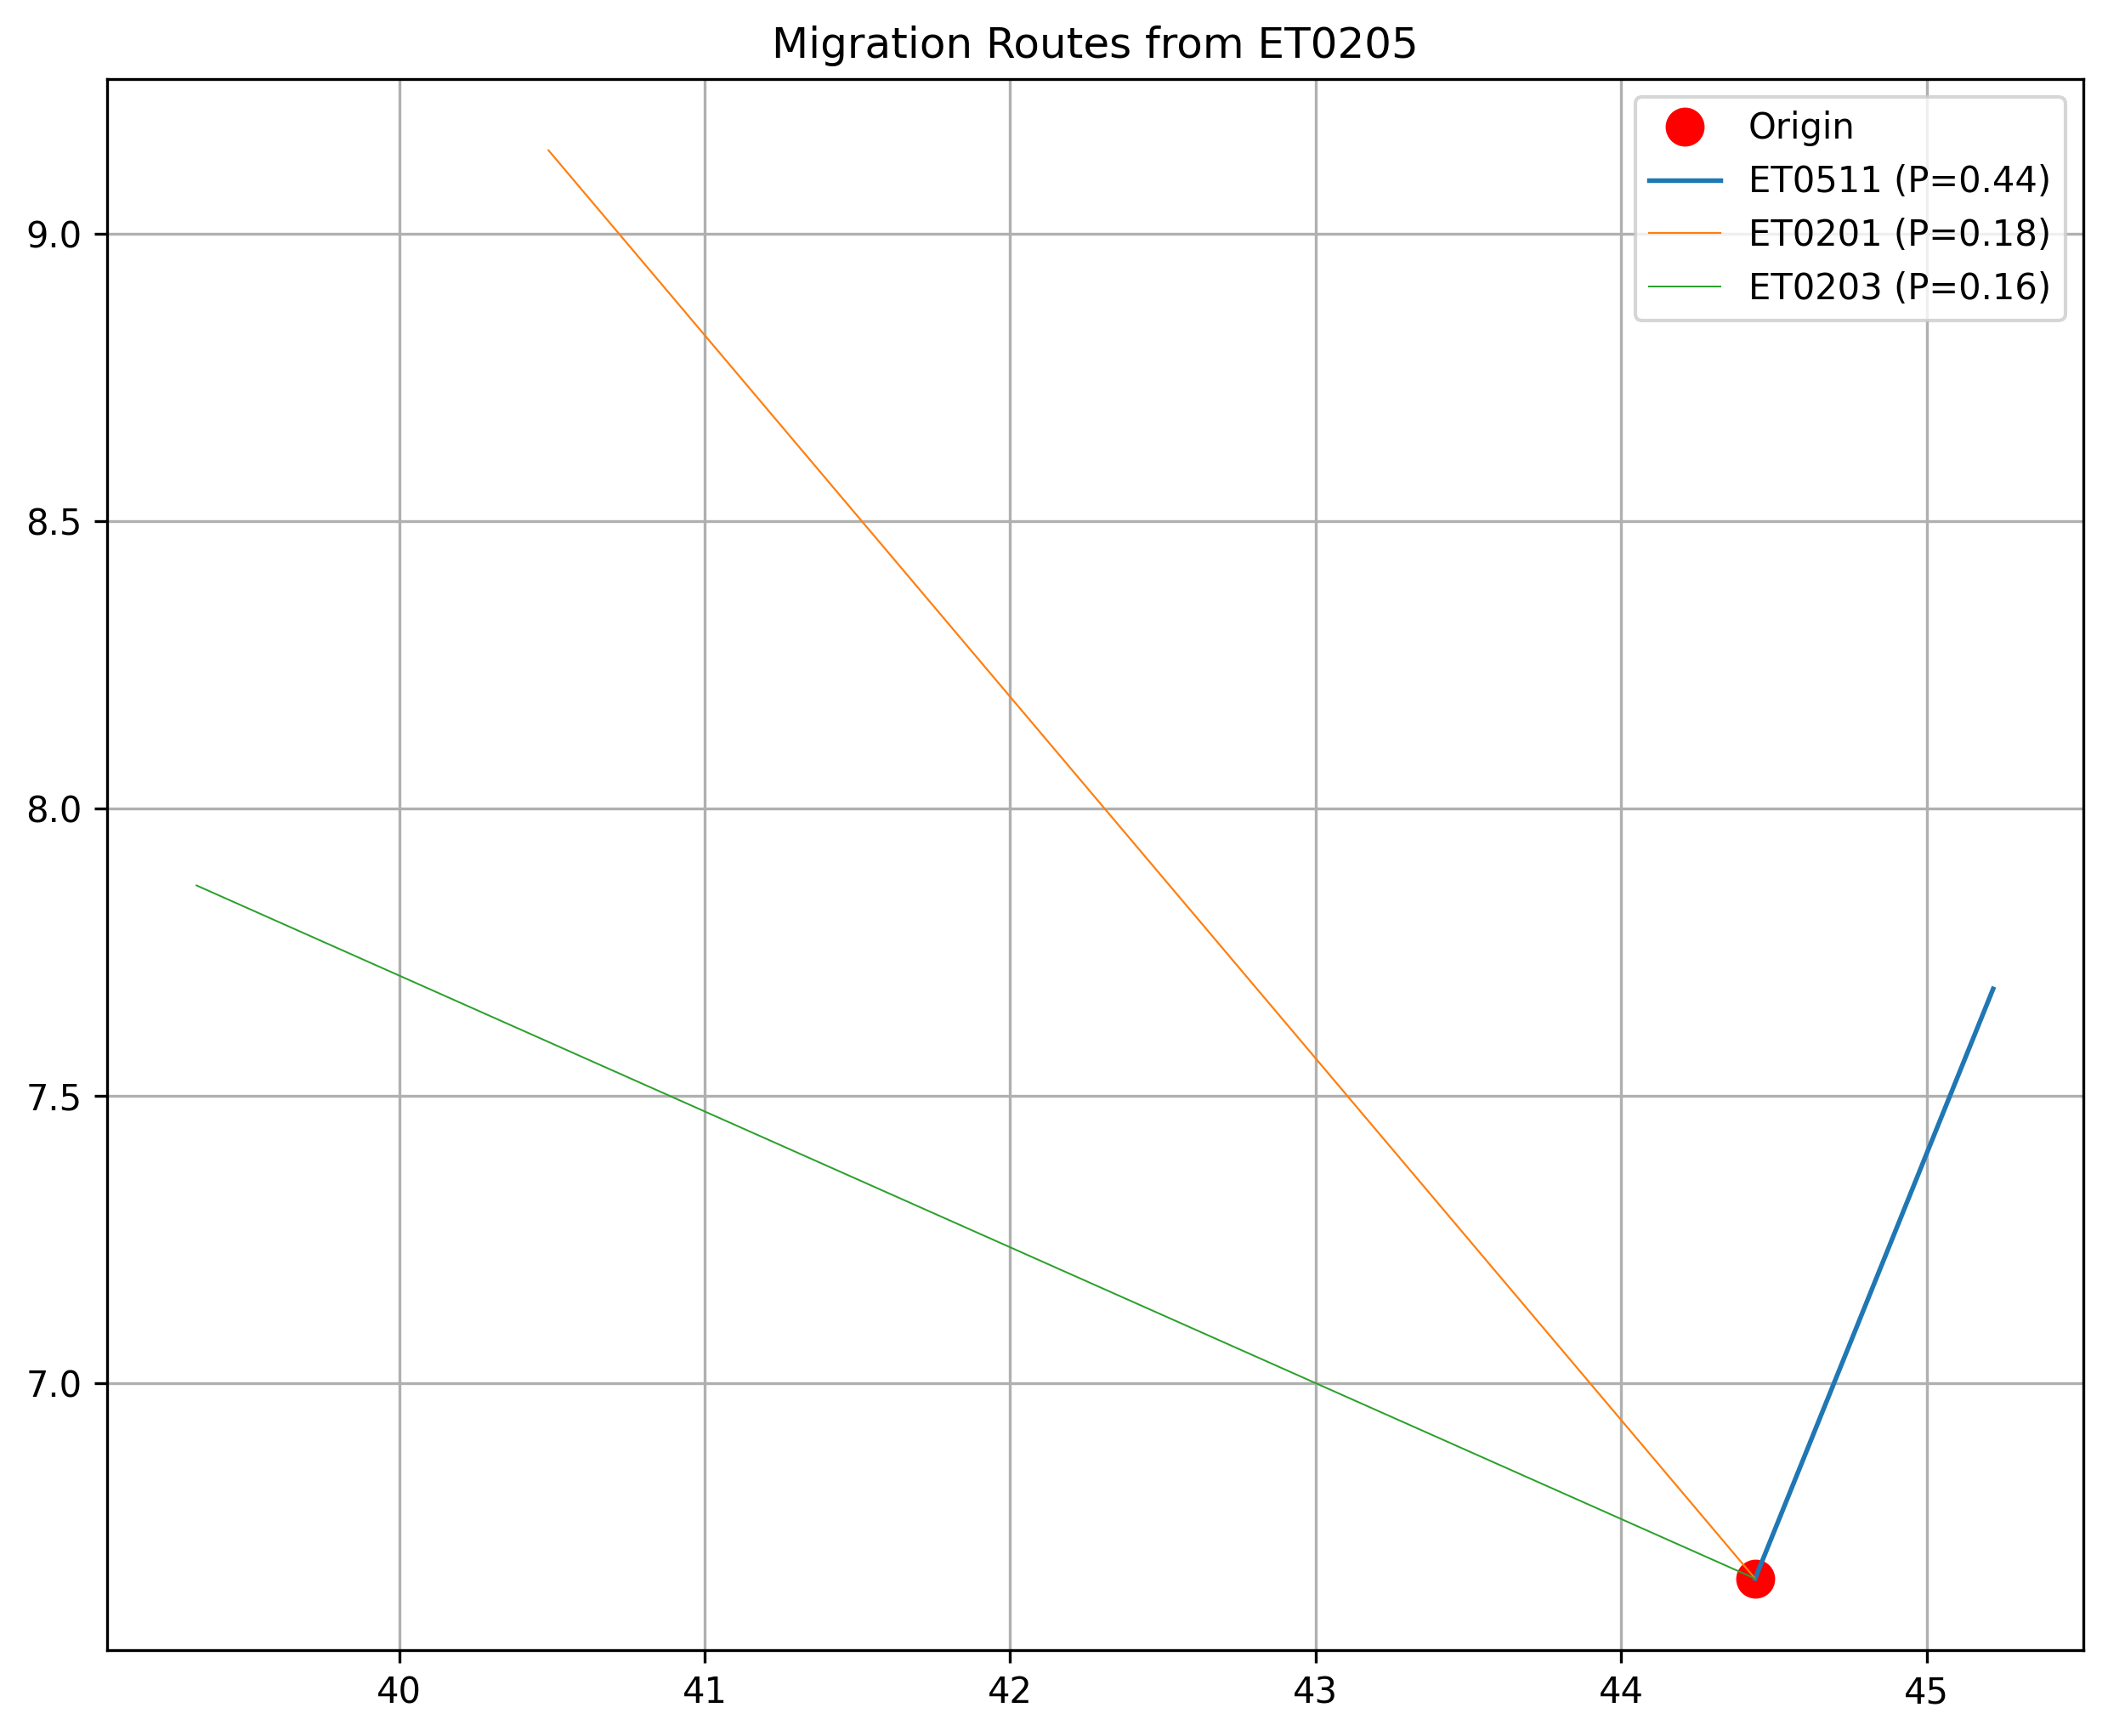




Analyzing migration routes from ET0402

Top 3 potential destinations:

1. Destination: ET0404
   Probability: 0.59
   Estimated Households: 0
   Estimated Individuals: 2
   Estimated Days: 2

2. Destination: ET0203
   Probability: 0.44
   Estimated Households: 0
   Estimated Individuals: 2
   Estimated Days: 2

3. Destination: ET0201
   Probability: 0.37
   Estimated Households: 0
   Estimated Individuals: 2
   Estimated Days: 2

Migration routes map for ET0402:


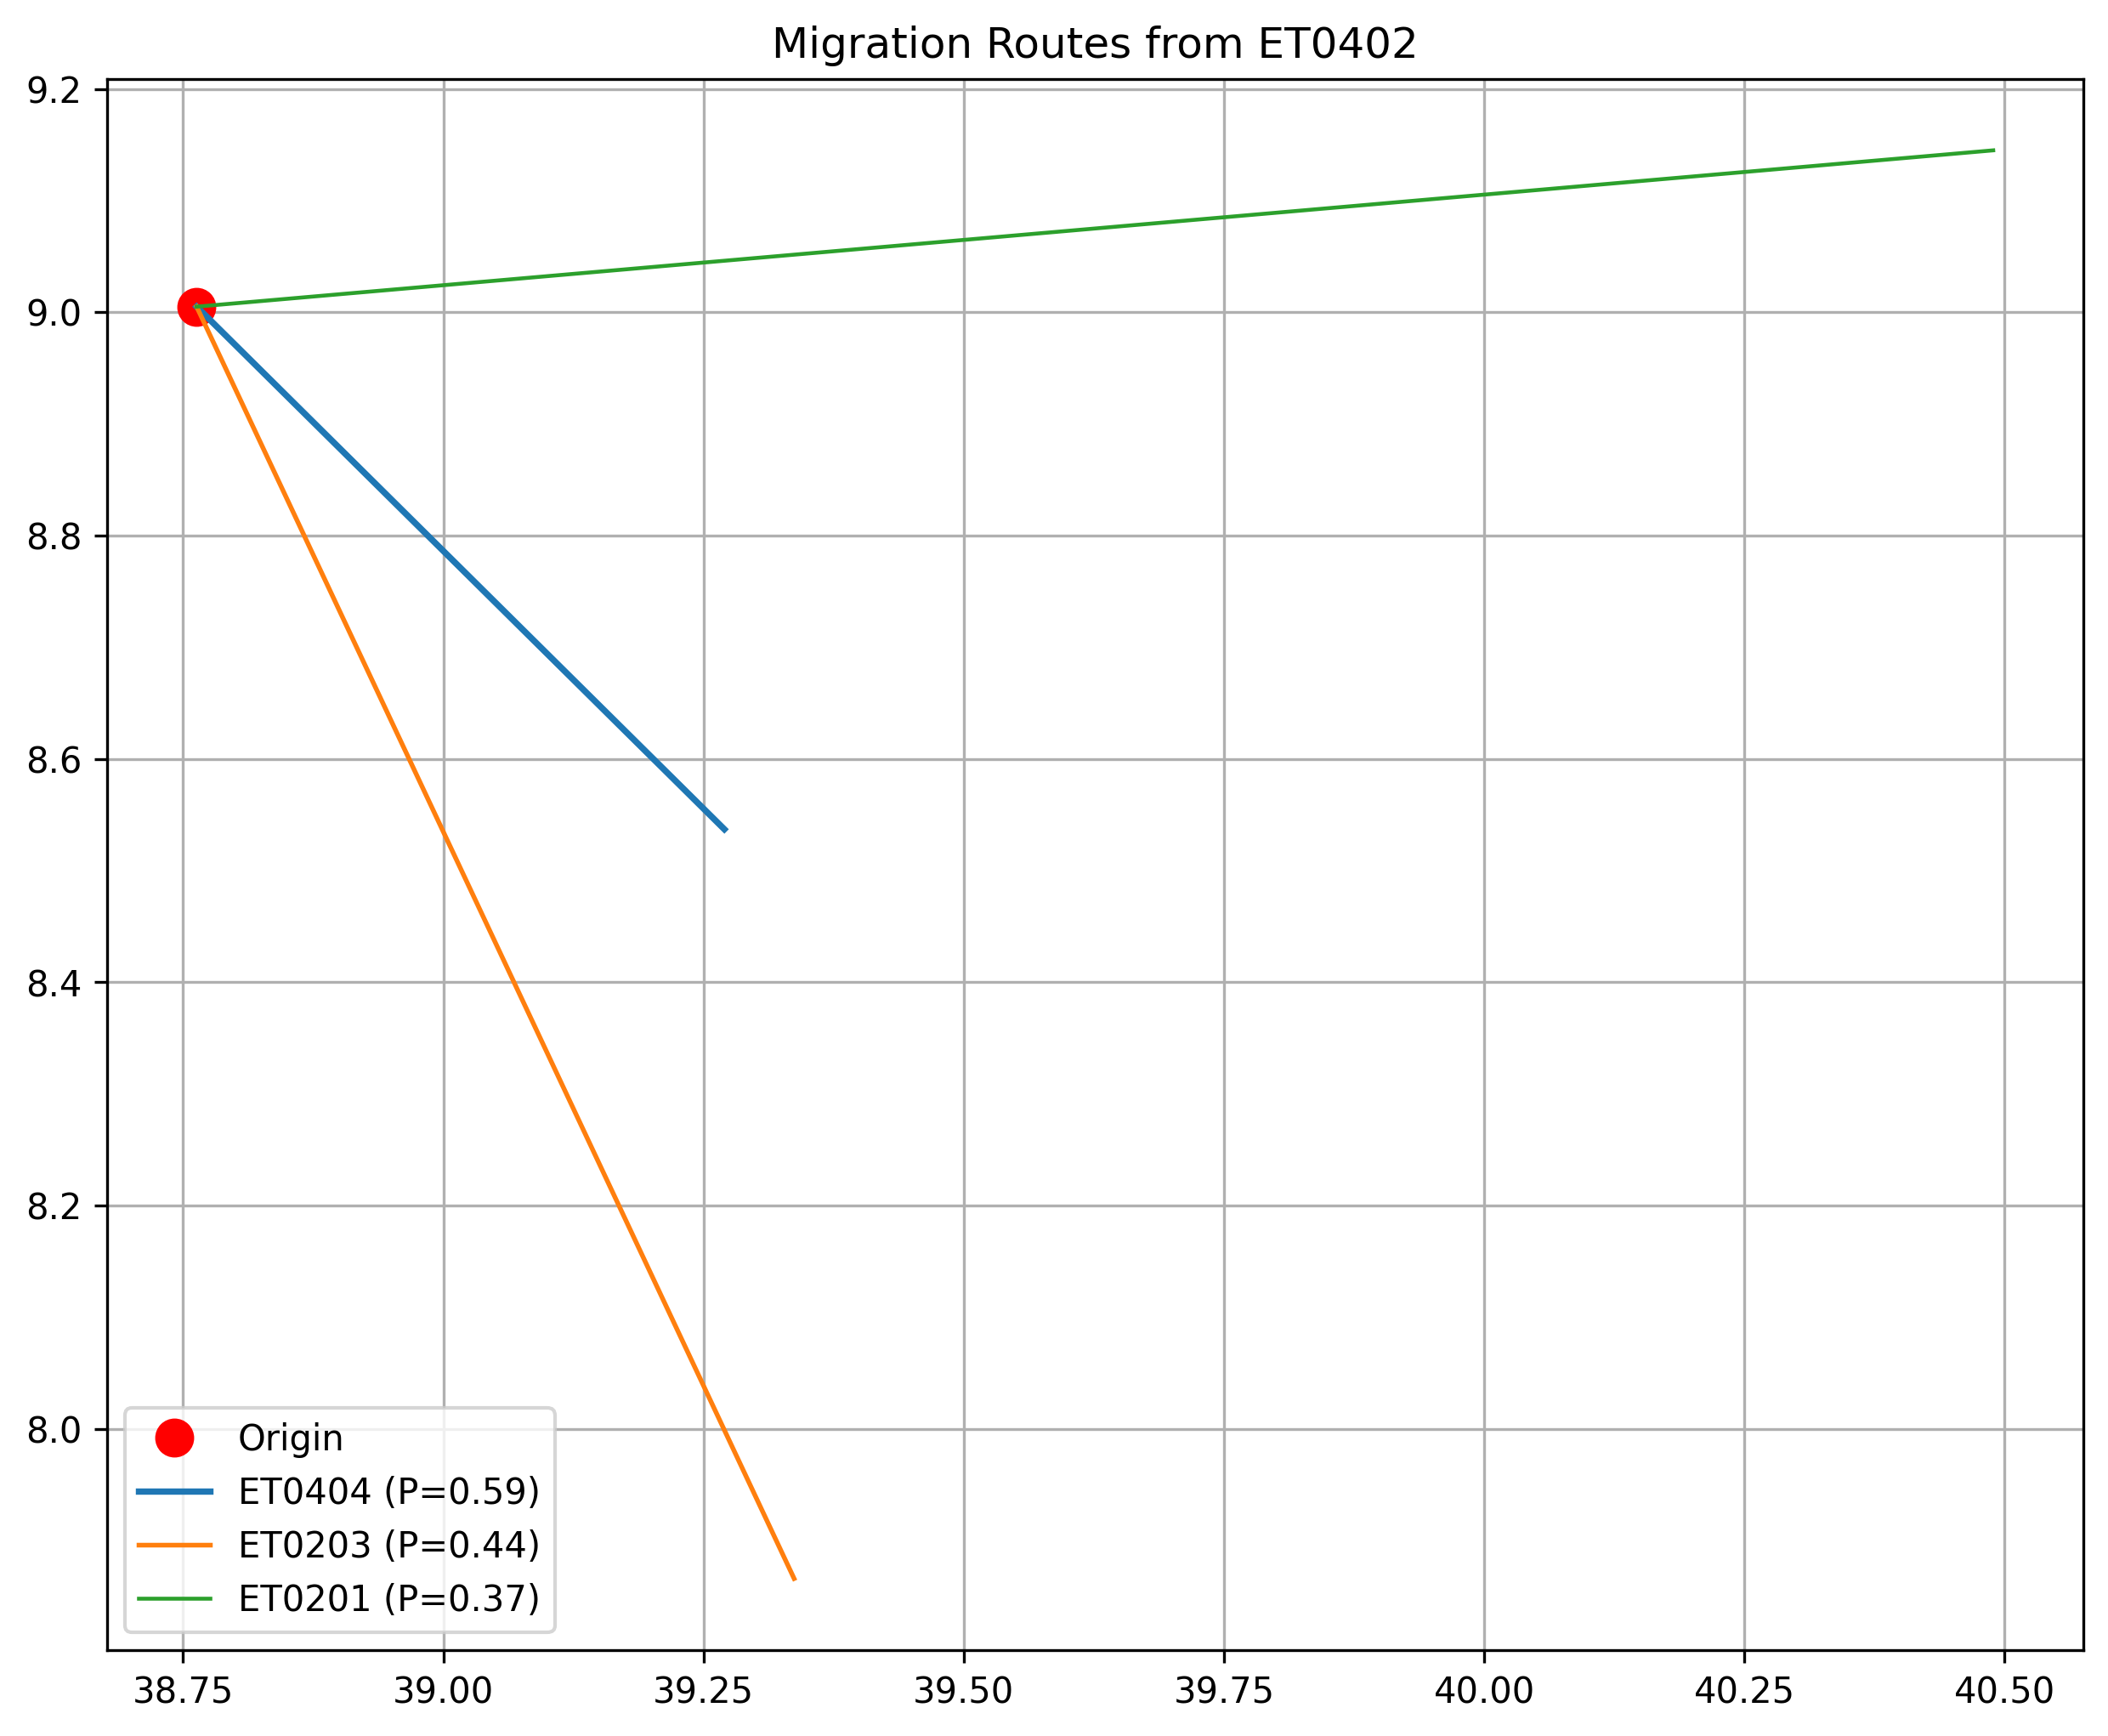




Analyzing migration routes from ET0404

Top 3 potential destinations:

1. Destination: ET0203
   Probability: 0.60
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

2. Destination: ET0402
   Probability: 0.59
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

3. Destination: ET0201
   Probability: 0.42
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: 0

Migration routes map for ET0404:


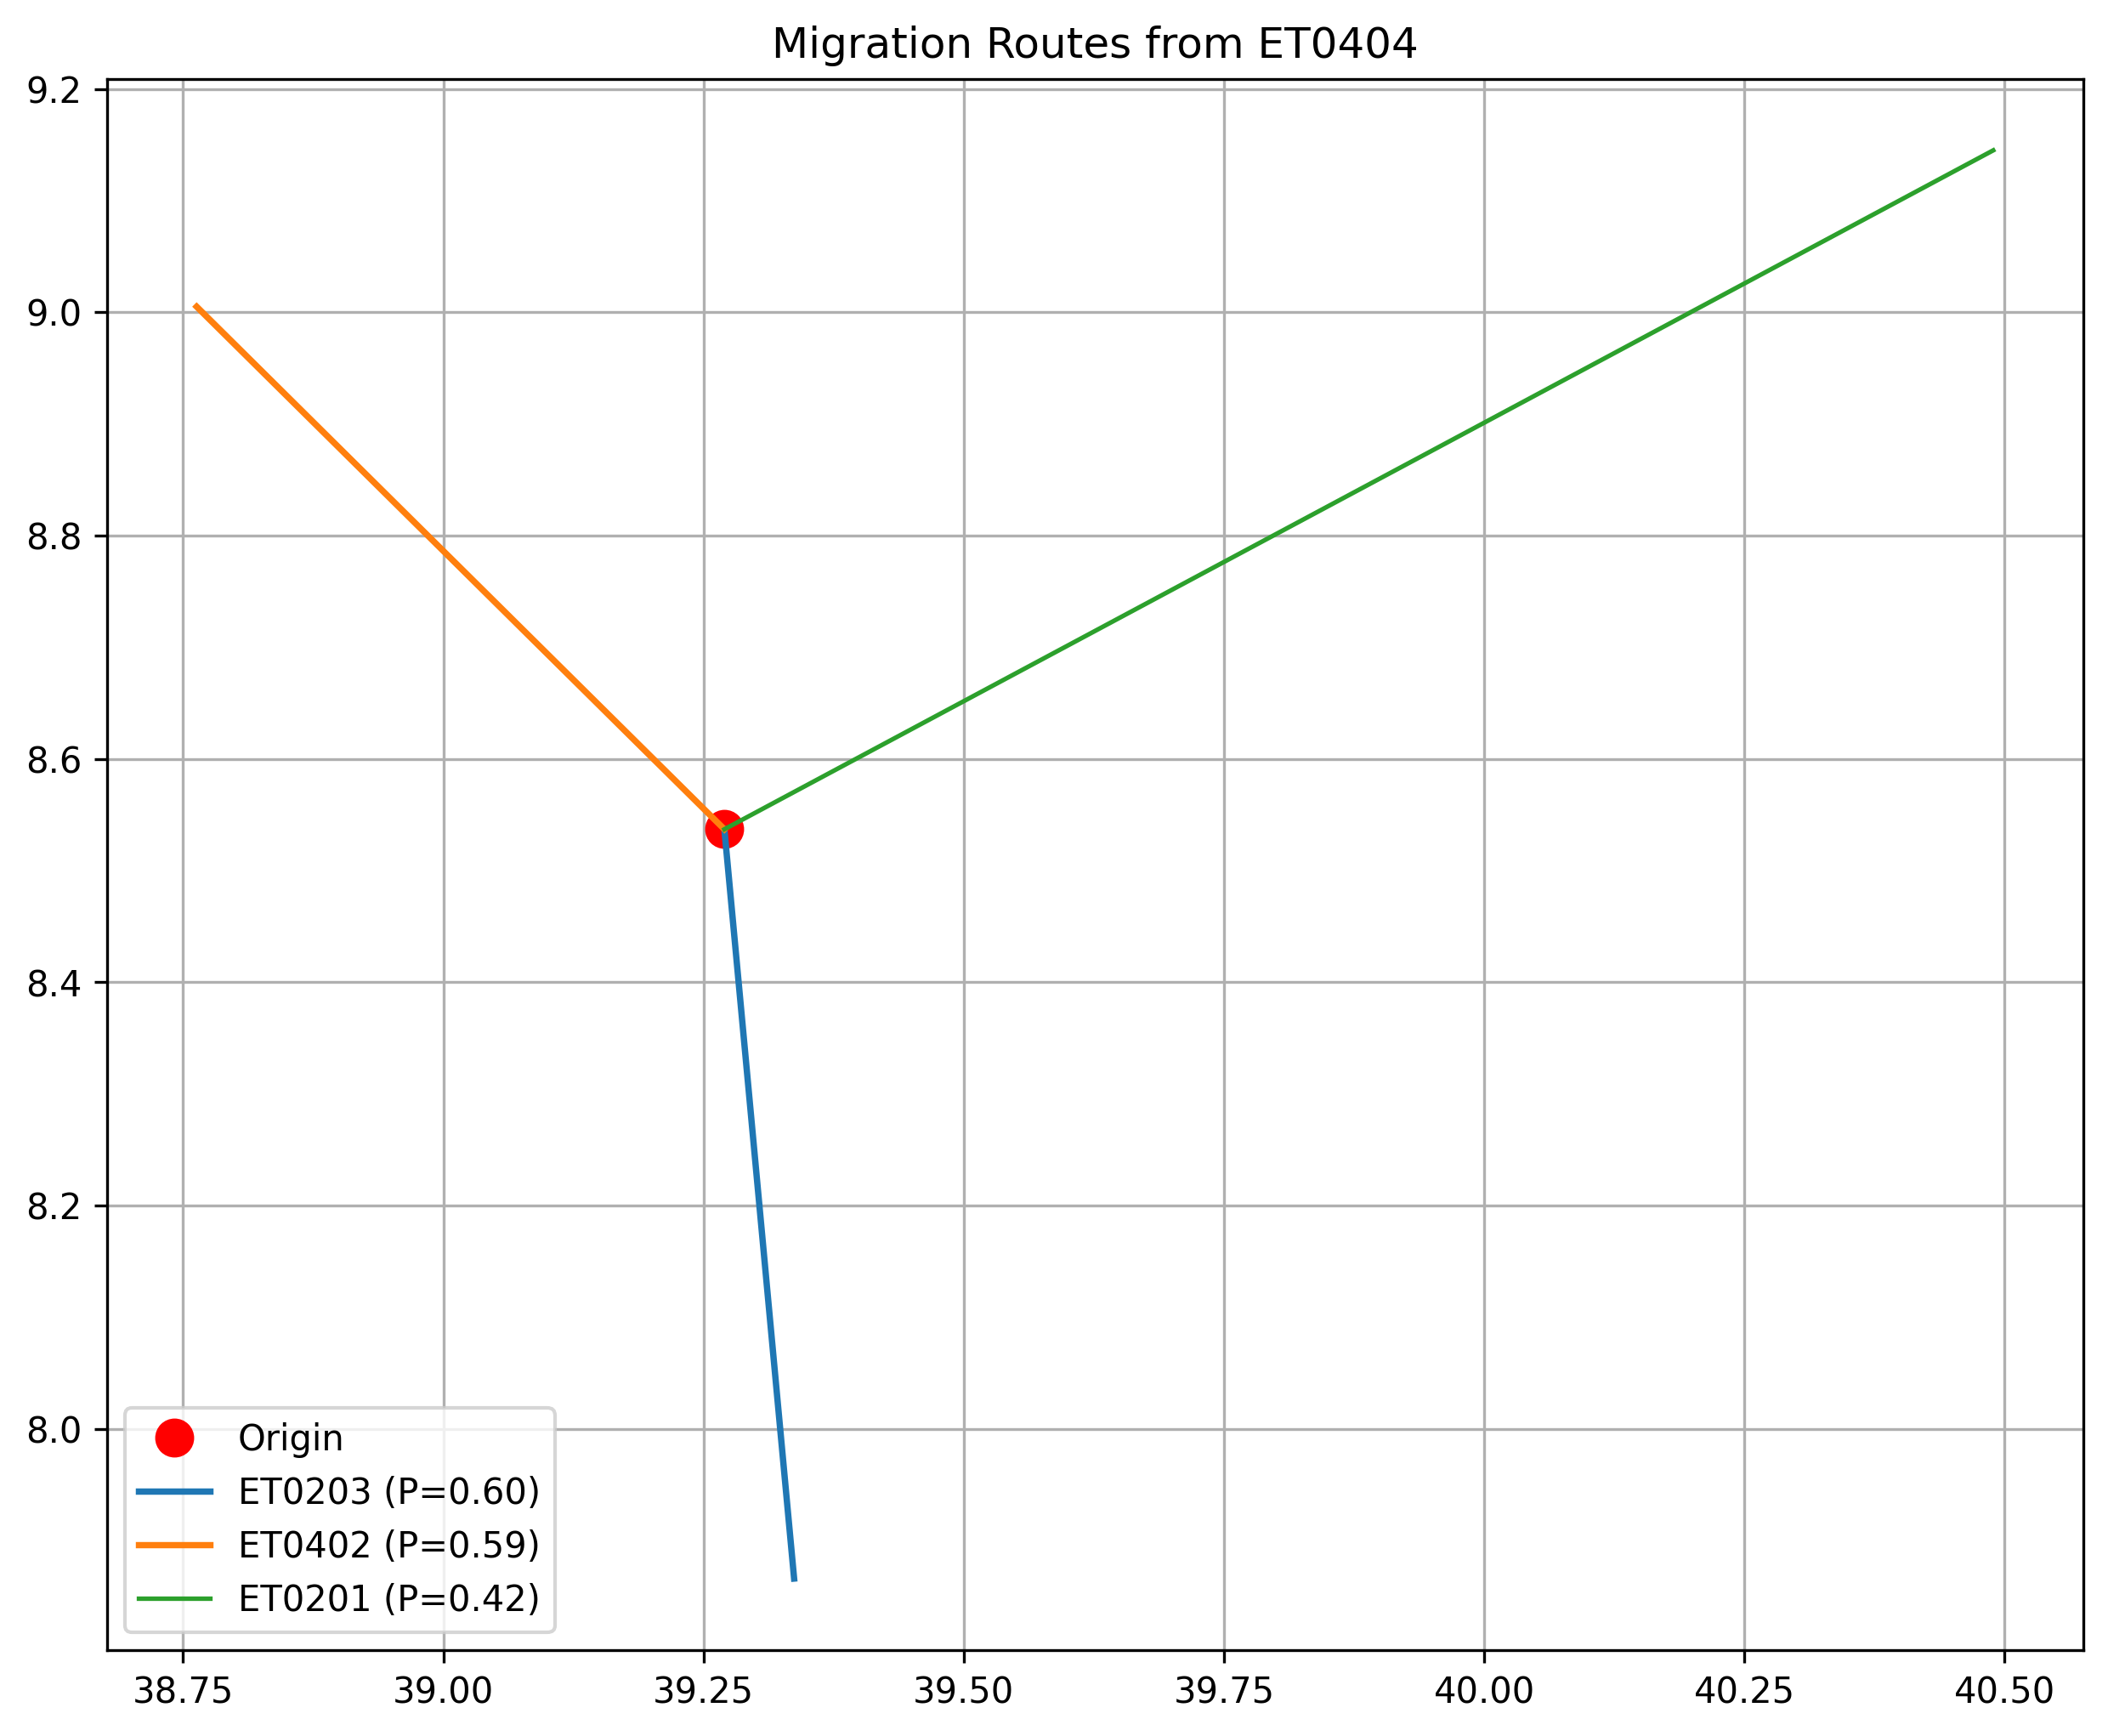




Analyzing migration routes from ET0511

Top 3 potential destinations:

1. Destination: ET0205
   Probability: 0.44
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: -1

2. Destination: ET0201
   Probability: 0.17
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: -1

3. Destination: ET0203
   Probability: 0.15
   Estimated Households: 0
   Estimated Individuals: 0
   Estimated Days: -1

Migration routes map for ET0511:


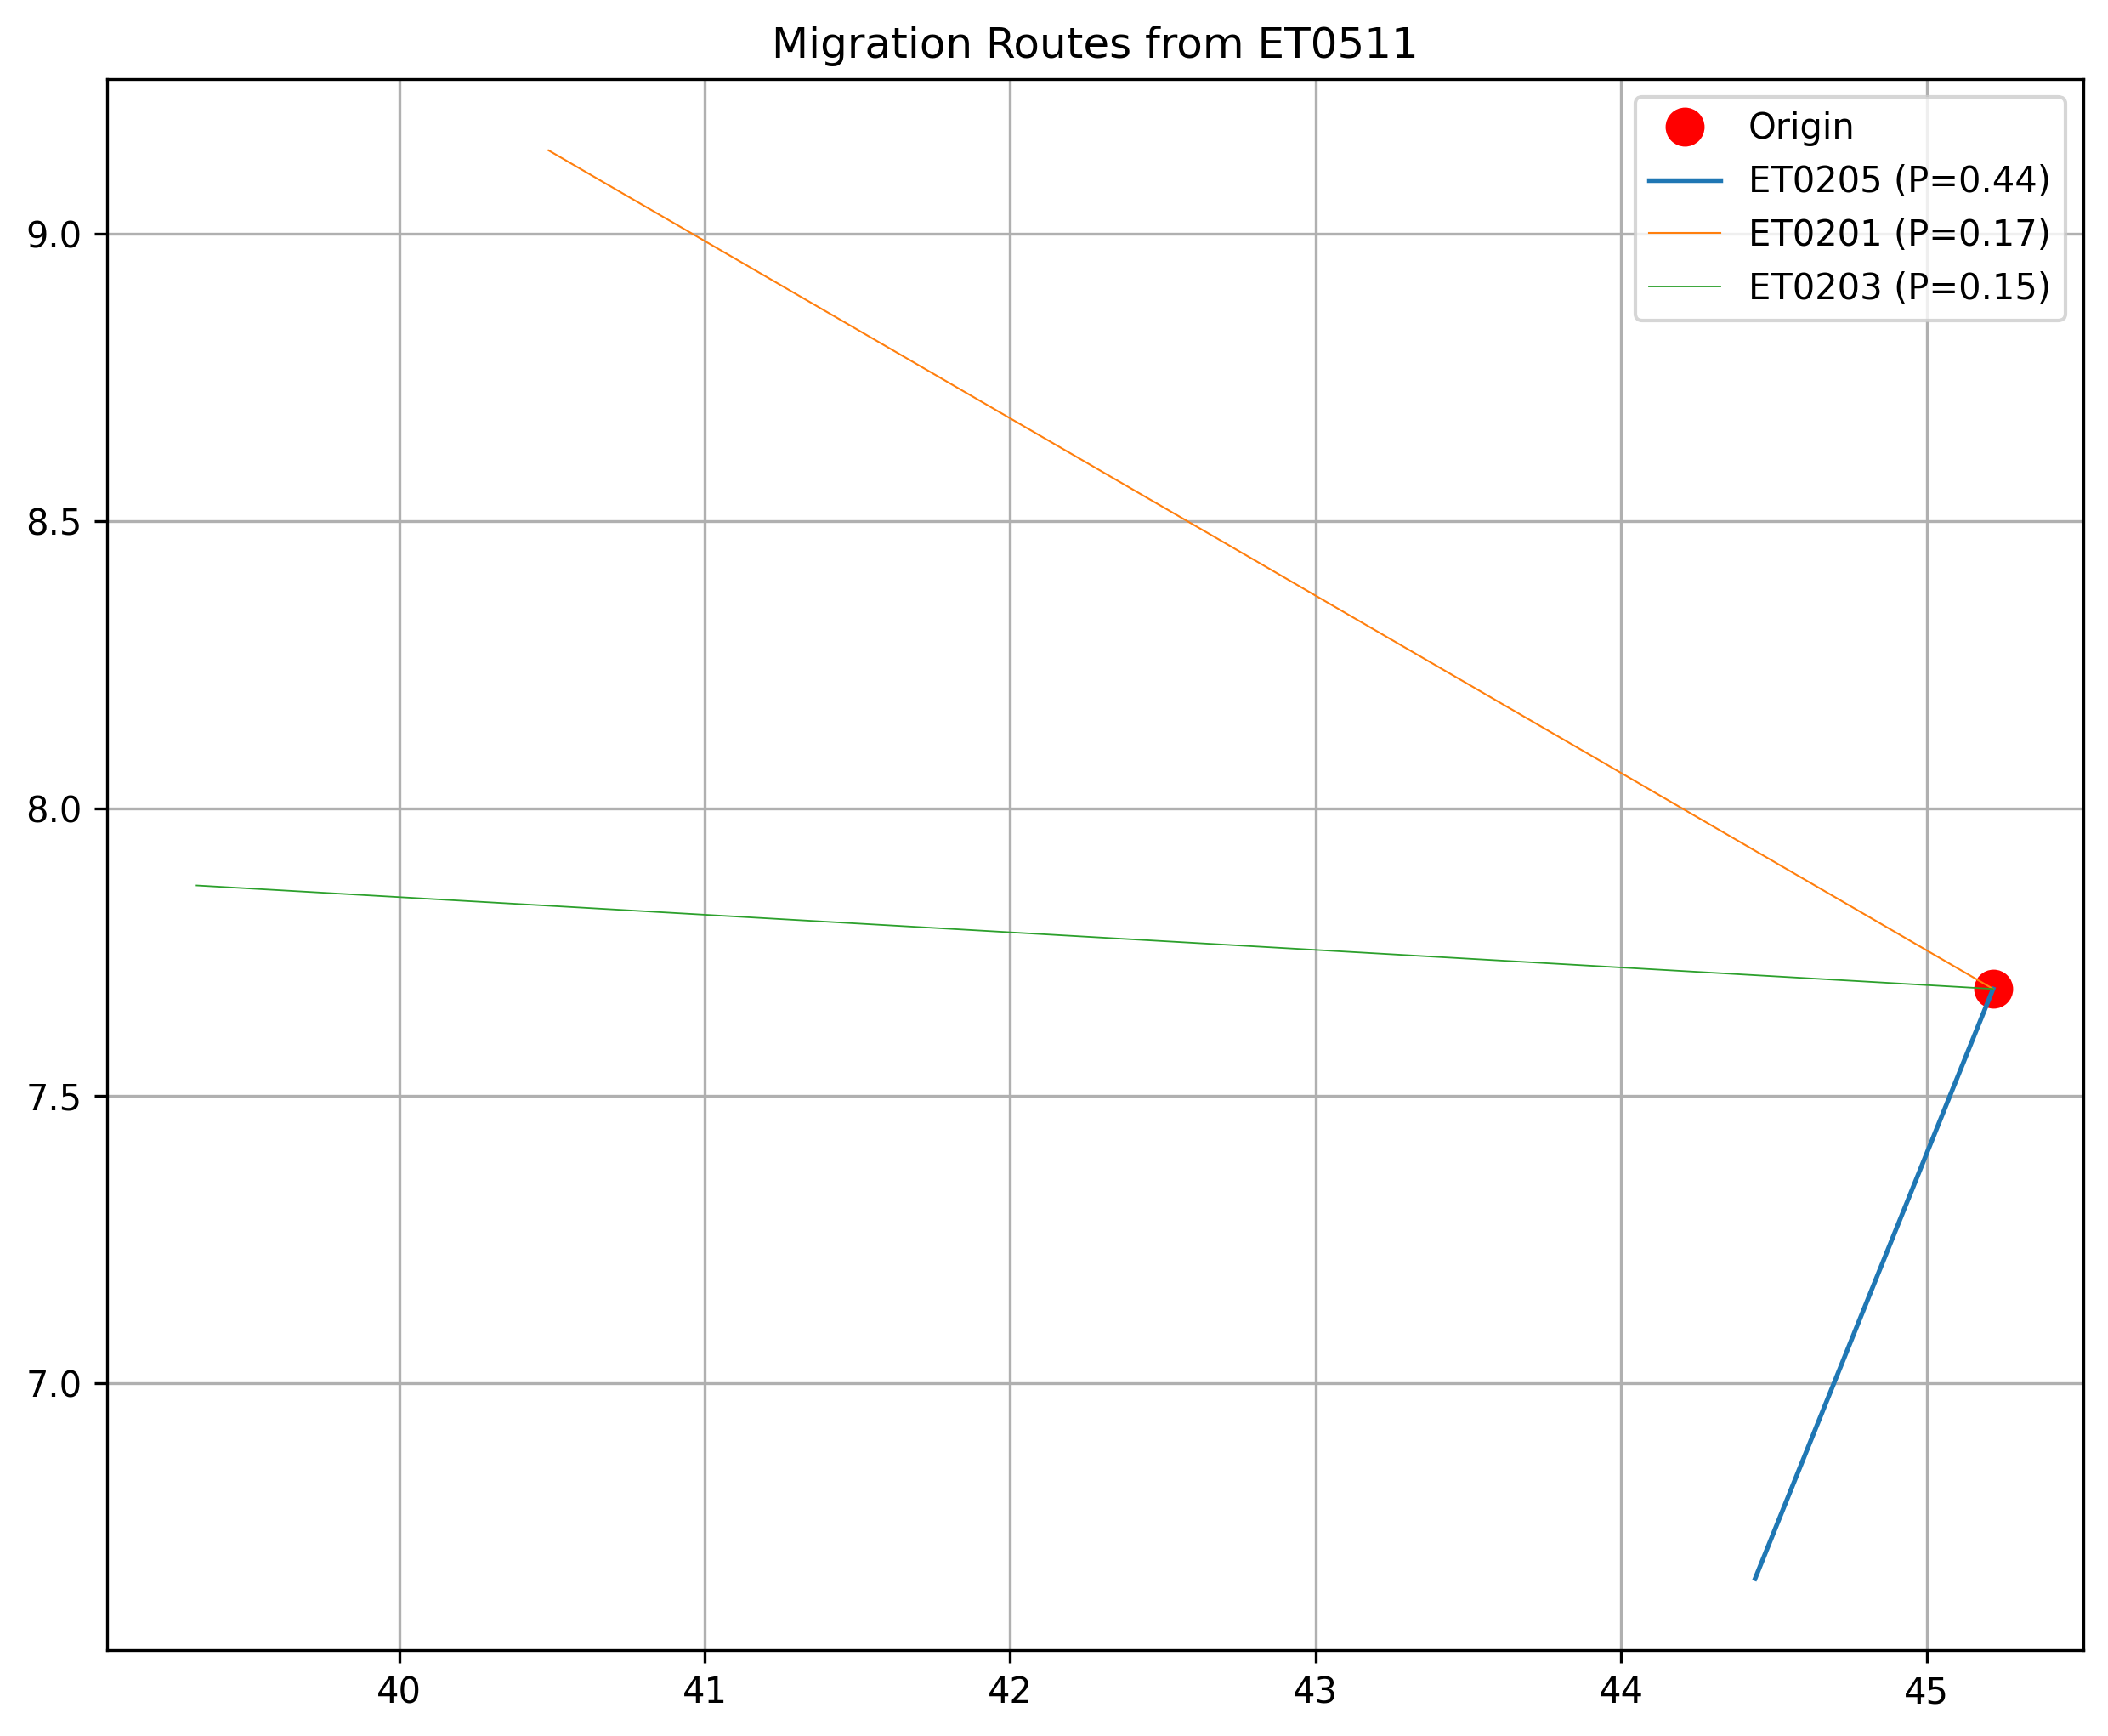

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
from IPython.display import display, HTML, Image
import joblib
import logging
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import os
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

class MigrationRoutePredictor:
    def __init__(self):
        self.data = None
        self.model = None
        self.scaler = StandardScaler()
        self.region_coords = {
            'ET0201': [9.145, 40.489],  # Oromia
            'ET0202': [11.345, 40.489],  # Amhara
            'ET0203': [7.866, 39.337],   # SNNP
            'ET0205': [6.660, 44.438],   # Somali
            'ET0402': [9.005, 38.763],   # Addis Ababa
            'ET0404': [8.537, 39.270],   # Dire Dawa
            'ET0511': [7.686, 45.217]    # Somali Region
        }

    def load_data(self, file_path):
        """데이터 로드 및 전처리"""
        try:
            self.data = pd.read_csv(file_path)

            # 수치형 특성만 선택
            self.features = [
                'Total_Households', 'Total_Individuals', 'Displacement_Duration',
                'Prevention_Factor_Ratio', 'Support_Need_Ratio'
            ]

            # 결측치 처리
            for feature in self.features:
                self.data[feature] = pd.to_numeric(self.data[feature], errors='coerce')
                self.data[feature] = self.data[feature].fillna(self.data[feature].mean())

            # 이상치 처리
            for feature in self.features:
                Q1 = self.data[feature].quantile(0.25)
                Q3 = self.data[feature].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                self.data[feature] = np.clip(self.data[feature], lower_bound, upper_bound)

            # 특성 스케일링
            self.data[self.features] = self.scaler.fit_transform(self.data[self.features])

            logging.info(f"Data loaded successfully: {len(self.data)} records")
            return True

        except Exception as e:
            logging.error(f"Error loading data: {str(e)}")
            return False

    def train_model(self):
        """모델 훈련"""
        X = self.data[self.features]
        y = self.data['Total_Individuals']

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # RandomForest 모델 파라미터 튜닝
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        self.model = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid,
            cv=5,
            n_jobs=-1,
            scoring='neg_mean_squared_error'
        )

        # 모델 학습
        self.model.fit(X_train, y_train)

        # 모델 성능 평가
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Model Performance:")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R2 Score: {r2:.2f}")

    def predict_migration_flow(self, origin_zone):
        """이주 흐름 예측"""
        if not self.model:
            self.train_model()

        predictions = []
        for dest_zone in self.region_coords.keys():
            if dest_zone != origin_zone:
                # 예측을 위한 특성 준비
                zone_data = self.data[self.data['Zone_P_CODE'] == origin_zone].iloc[0:1]

                if len(zone_data) > 0:
                    X_pred = zone_data[self.features]

                    # 예측
                    pred_individuals = self.model.predict(X_pred)[0]
                    pred_households = pred_individuals / 6  # 평균 가구 크기로 나눔

                    # 거리 기반 확률 계산
                    orig_coords = self.region_coords[origin_zone]
                    dest_coords = self.region_coords[dest_zone]
                    distance = np.sqrt(
                        (orig_coords[0] - dest_coords[0])**2 +
                        (orig_coords[1] - dest_coords[1])**2
                    )
                    probability = 1 / (1 + distance)

                    predictions.append({
                        'destination': dest_zone,
                        'probability': probability,
                        'estimated_households': int(pred_households),
                        'estimated_individuals': int(pred_individuals),
                        'estimated_days': int(zone_data['Displacement_Duration'].iloc[0])
                    })

        # 확률 기준 정렬
        predictions.sort(key=lambda x: x['probability'], reverse=True)
        return predictions

    def visualize_routes(self, predictions, origin_zone):
        """이주 경로 시각화"""
        m = folium.Map(
            location=[8.5, 40.5],  # 에티오피아 중심
            zoom_start=6
        )

        # 출발지 마커
        if origin_zone in self.region_coords:
            orig_lat, orig_lon = self.region_coords[origin_zone]
            folium.Marker(
                [orig_lat, orig_lon],
                popup=f'Origin: {origin_zone}',
                icon=folium.Icon(color='red', icon='info-sign')
            ).add_to(m)

        # 경로 그리기
        for pred in predictions:
            if pred['destination'] in self.region_coords:
                dest_lat, dest_lon = self.region_coords[pred['destination']]

                points = [(orig_lat, orig_lon), (dest_lat, dest_lon)]
                folium.PolyLine(
                    points,
                    weight=pred['probability'] * 5,
                    color='blue',
                    opacity=0.6,
                    popup=f"Probability: {pred['probability']:.2f}<br>"
                          f"Estimated Households: {pred['estimated_households']}<br>"
                          f"Estimated Individuals: {pred['estimated_individuals']}"
                ).add_to(m)

                folium.Marker(
                    [dest_lat, dest_lon],
                    popup=f"Destination: {pred['destination']}<br>"
                          f"Probability: {pred['probability']:.2f}",
                    icon=folium.Icon(color='green', icon='info-sign')
                ).add_to(m)

        return m

def main():
    predictor = MigrationRoutePredictor()
    if not predictor.load_data('/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설/data/enhanced_merged_data.csv'):
        return False

    # 필요한 라이브러리 임포트
    from IPython.display import display, HTML, Image
    import matplotlib.pyplot as plt

    # 모델 훈련
    predictor.train_model()

    # 테스트할 지역
    test_zones = ['ET0201', 'ET0202', 'ET0203', 'ET0205', 'ET0402', 'ET0404', 'ET0511']

    for zone in test_zones:
        print(f"\nAnalyzing migration routes from {zone}")
        predictions = predictor.predict_migration_flow(zone)

        if predictions:
            print("\nTop 3 potential destinations:")
            for i, pred in enumerate(predictions[:3], 1):
                print(f"\n{i}. Destination: {pred['destination']}")
                print(f"   Probability: {pred['probability']:.2f}")
                print(f"   Estimated Households: {pred['estimated_households']}")
                print(f"   Estimated Individuals: {pred['estimated_individuals']}")
                print(f"   Estimated Days: {pred['estimated_days']}")

            # 지도 생성
            m = predictor.visualize_routes(predictions, zone)

            # HTML 파일로 저장하고 표시
            html_file = f'migration_routes_{zone}.html'
            m.save(html_file)

            # HTML 직접 표시
            print(f"\nMigration routes map for {zone}:")
            with open(html_file, 'r', encoding='utf-8') as f:
                html_content = f.read()
            display(HTML(html_content))

            # matplotlib 시각화
            plt.figure(figsize=(10, 8))
            plt.title(f'Migration Routes from {zone}')

            # 출발지 표시
            orig_lat, orig_lon = predictor.region_coords[zone]
            plt.plot(orig_lon, orig_lat, 'ro', markersize=10, label='Origin')

            # 상위 3개 목적지에 대한 경로 표시
            for pred in predictions[:3]:
                if pred['destination'] in predictor.region_coords:
                    dest_lat, dest_lon = predictor.region_coords[pred['destination']]
                    plt.plot([orig_lon, dest_lon], [orig_lat, dest_lat],
                            '-', linewidth=pred['probability']*3,
                            label=f"{pred['destination']} (P={pred['probability']:.2f})")

            plt.grid(True)
            plt.legend()

            # PNG로 저장하고 표시
            png_file = f'migration_routes_{zone}.png'
            plt.savefig(png_file, bbox_inches='tight', dpi=300)
            plt.close()

            # PNG 파일 표시
            display(Image(filename=png_file))

            print("\n" + "="*50 + "\n")

if __name__ == "__main__":
    # matplotlib 기본 설정만 사용
    import matplotlib.pyplot as plt

    main()


##이주기간, 이주민 증감 모델 테스트

In [ ]:
import pandas as pd
import numpy as np
import joblib
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 모델 로드
base_path = '/content/drive/MyDrive/연세대학교캠프/2학년/인공지능건설'
model_path = f'{base_path}/result/enhanced_dual_prediction_model.joblib'
model = joblib.load(model_path)

def predict_displacement_dual(input_data):
    """
    이주 기간과 이주민 증감을 예측하는 함수
    """
    try:
        # 입력 데이터 전처리
        df = pd.DataFrame([input_data])

        # 모델의 feature_names_in_ 확인
        if hasattr(model, 'feature_names_in_'):
            required_features = model.feature_names_in_

            # 필요한 특성들을 기본값 0으로 초기화
            input_df = pd.DataFrame(0, index=[0], columns=required_features)

            # 제공된 특성값들로 업데이트
            for col in df.columns:
                if col in required_features:
                    input_df[col] = df[col]

            # 파생 특성 계산
            input_df['gdp_per_household'] = input_df['gdp_per_capita_usd'] * input_df['household_size']
            input_df['economic_vulnerability'] = (input_df['economic_pressure'] / input_df['gdp_per_household']) * 100
            input_df['support_needs_per_individual'] = input_df['Total_Support_Needs'] / (input_df['Total_Households'] * input_df['household_size'])
            input_df['prevention_factor_density'] = input_df['Total_Prevention_Factors'] / input_df['Total_Households']

            df = input_df

        # 예측 수행
        prediction = model.predict(df)[0]

        # 예측값을 이주 기간과 증감으로 변환
        # 이주 기간은 기본 예측값 사용
        predicted_days = max(0, prediction)

        # 이주민 증감은 가구 크기와 경제적 압박을 고려하여 계산
        total_individuals = input_data['Total_Households'] * input_data['household_size']
        economic_factor = input_data['economic_pressure'] / input_data['gdp_per_capita_usd']
        predicted_change = int(total_individuals * economic_factor * 0.1)  # 10% 기준으로 조정

        return {
            'predicted_days': predicted_days,
            'predicted_change': predicted_change
        }

    except Exception as e:
        print(f"예측 중 오류 발생: {str(e)}")
        print("모델 구조:", type(model))
        return None

# 테스트 케이스
test_cases = [
    {
        # 심각한 가뭄 지역 케이스
        'Total_Households': 150,
        'Total_Individuals': 750,
        'Total_Prevention_Factors': 2,  # 예방 요인 적음
        'Total_Support_Needs': 7,      # 지원 필요성 높음
        'household_size': 5,
        'gdp_per_capita_usd': 450,     # 더 낮은 GDP
        'trade_pct_gdp': 25,
        'remittances_pct_gdp': 15,
        'individuals_change': 0,
        'households_change': 0,
        'ind_3month_avg': 750,
        'ind_change_rate': 0,
        'economic_pressure': 180,       # 더 높은 경제적 압박
        'social_pressure': 0.7,         # 더 높은 사회적 압박
        'year': 2023,
        'month': 6,
        'season': 2,  # 봄철 가뭄
        'Displacement_Reason': 'Drought',
        'Origin_Zone': 'ET0202',        # Somali 지역
        'Region_P_CODE_ET02': 1,
        'Region_P_CODE_ET03': 0,
        'Region_P_CODE_ET04': 0,
        'Region_P_CODE_ET05': 0
    },
    {
        # 경미한 가뭄 지역 케이스
        'Total_Households': 200,
        'Total_Individuals': 800,
        'Total_Prevention_Factors': 4,   # 예방 요인 많음
        'Total_Support_Needs': 4,       # 지원 필요성 낮음
        'household_size': 4,
        'gdp_per_capita_usd': 600,
        'trade_pct_gdp': 35,
        'remittances_pct_gdp': 20,
        'individuals_change': 0,
        'households_change': 0,
        'ind_3month_avg': 800,
        'ind_change_rate': 0,
        'economic_pressure': 120,        # 더 낮은 경제적 압박
        'social_pressure': 0.4,         # 더 낮은 사회적 압박
        'year': 2023,
        'month': 7,
        'season': 3,  # 여름철 가뭄
        'Displacement_Reason': 'Drought',
        'Origin_Zone': 'ET0203',        # Afar 지역
        'Region_P_CODE_ET02': 1,
        'Region_P_CODE_ET03': 0,
        'Region_P_CODE_ET04': 0,
        'Region_P_CODE_ET05': 0
    }
]

# 예측 실행
print("\n이주 예측 시스템")
print("=" * 50)

for i, case in enumerate(test_cases, 1):
    print(f"\n[케이스 {i}] 테스트 데이터 설명")
    print(f"• 지역: 에티오피아 {case['Origin_Zone']} 구역")
    print(f"• 이주 원인: {case['Displacement_Reason']}")
    print(f"• 가구 정보: {case['Total_Households']}가구 (가구당 {case['household_size']}명)")
    print(f"• 경제 지표: 1인당 GDP ${case['gdp_per_capita_usd']}")
    print(f"• 취약성 지표:")
    print(f"  - 예방 요인 수: {case['Total_Prevention_Factors']}")
    print(f"  - 지원 필요 사항: {case['Total_Support_Needs']}")
    print(f"  - 경제적 압박: {case['economic_pressure']}")
    print(f"  - 사회적 압박: {case['social_pressure']:.2f}")

    # 예측 수행
    result = predict_displacement_dual(case)

    if result:
        print("\n예측 결과:")
        print(f"• 예상 이주 기간: {result['predicted_days']:.0f}일")
        print(f"• 예상 이주민 증감: {result['predicted_change']:+.0f}명")

        # 위험도 평가
        duration_risk = "높음" if result['predicted_days'] > 180 else "중간" if result['predicted_days'] > 90 else "낮음"
        change_risk = "높음" if abs(result['predicted_change']) > 100 else "중간" if abs(result['predicted_change']) > 50 else "낮음"

        print("\n위험도 평가:")
        print(f"• 이주 기간 위험도: {duration_risk}")
        print(f"• 이주민 증감 위험도: {change_risk}")

    print("-" * 50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

이주 예측 시스템

[케이스 1] 테스트 데이터 설명
• 지역: 에티오피아 ET0202 구역
• 이주 원인: Drought
• 가구 정보: 150가구 (가구당 5명)
• 경제 지표: 1인당 GDP $450
• 취약성 지표:
  - 예방 요인 수: 2
  - 지원 필요 사항: 7
  - 경제적 압박: 180
  - 사회적 압박: 0.70

예측 결과:
• 예상 이주 기간: 3120일
• 예상 이주민 증감: +30명

위험도 평가:
• 이주 기간 위험도: 높음
• 이주민 증감 위험도: 낮음
--------------------------------------------------

[케이스 2] 테스트 데이터 설명
• 지역: 에티오피아 ET0203 구역
• 이주 원인: Drought
• 가구 정보: 200가구 (가구당 4명)
• 경제 지표: 1인당 GDP $600
• 취약성 지표:
  - 예방 요인 수: 4
  - 지원 필요 사항: 4
  - 경제적 압박: 120
  - 사회적 압박: 0.40

예측 결과:
• 예상 이주 기간: 3133일
• 예상 이주민 증감: +16명

위험도 평가:
• 이주 기간 위험도: 높음
• 이주민 증감 위험도: 낮음
--------------------------------------------------
